# Classifiez automatiquement des biens de consommation

- **Projet 6 du parcours « Data Scientist » d’OpenClassrooms**
- **Mark Creasey**

## Partie 1 : Classification de textes


<!--TABLE OF CONTENTS-->

Contents:

- [1. Compréhension du problème](#1.-Compréhension-du-problème)
  - [1.1 Mission](#1.1-Mission)
  - [1.2 Requirements :Bibliothèques utilisées dans ce notebook](#1.2-Requirements-:-Bibliothèques-utilisées-dans-ce-notebook)
  - [1.3 Des fonctions utilitaires](#1.3-Des-fonctions-utilitaires)
- [2. Import, nettoyage et analyse exploratoire des données](#2.-Import,-nettoyage-et-analyse-exploratoire-des-données)
  - [2.1 Import des données](#2.1-Import-des-données)
  - [2.2 Nettoyage des données](#2.2-Nettoyage-des-données)
  - [2.3 Analyse exploratoire](#2.3-Analyse-exploratoire)
  - [2.4 Elimination des colonnes non pertinentes au problématique](#2.4-Elimination-des-colonnes-non-pertinentes-au-problématique)
- [3. Feature engineering / preprocessing](#3.-Feature-engineering-/-preprocessing)
  - [3.1 Préparation des catégories](#3.1-Préparation-des-catégories)
  - [3.2 Préparation (preprocessing) des descriptions des données](<#3.2-Préparation-(preprocessing)-des-déscriptions-des-données>)
  - [3.3 Pipeline pour création des features 'sentence' pour les modèles](#3.3-Pipeline-pour-création-des-features-'sentence'-pour-les-modeles)
  - [3.4 Verification des mots plus fréquents](#3.4-Verification-des-mots-plus-fréquents)
  - [3.5 Enregistre les données préparées](#3.5-Enregistre-les-données-préparées)
  - [3.6 Nettoyage des variables globales](#3.6-Nettoyage-des-variables-globales)
- [4. Fonctions communes pour modèles NLP](#4.-Fonctions-communs-pour-modèles-NLP)
  - [4.1 Lecture des données](#4.1-Lecture-des-données)
  - [4.2 Modélisation et évaluation des modèles:](#4.2-Modélisation-et-évaluation-des-modèles:)
  - [4.3 Visualisations de métriques de performance](#4.3-Visualisations-de-metriques-de-performance)
  - [4.4 Visualisation des clusters sur les 'reduced_dimensions'](#4.4-Visualisation-des-clusters-sur-les-'reduced_dimensions')
- [5. Bag-of-Words et TF-IDF](#5.-Bag-of-Words-et-TF-IDF)
  - [5.1 Essaie 1 : Bag of words (BOW)](<#5.1-Essaie-1-:-Bag-of-words-(BOW)>)
  - [5.2 Essaie 2 : TF-IDF](#5.2-Essaie-2-:-TF-IDF)
- [6. LDA - (Topic modelling)](<#6.-LDA---(Topic-modelling)>)
  - [6.1 Essaie 3 : LDA - Latent Dirichlet Allocation](#6.1-Essaie-3-:-LDA---Latent-Dirichlet-Allocation)
- [7. Word2Vec](#7.-Word2Vec)
  - [7.1 Essaie 4 :Word2Vec sur phrases lemmatizes](#7.1-Essaie-4-:-Word2Vec-sur-phrases-lemmatizes)
  - [Création de la matrice d'embedding](#Création-de-la-matrice-d'embedding)
  - [Création du modèle d'embedding](#Création-du-modèle-d'embedding)
  - [Exécution du modèle](#Exécution-du-modèle)
- [8. BERT](#8.-BERT)
  - [8.1 BERT - Fonctions communes](#8.1-BERT---Fonctions-communes)
  - [8.2 Essaie 5 : BERT HuggingFace](#8.2-Essaie-5-:-BERT-HuggingFace)
  - [8.3 Essaie 6 : BERT hub Tensorflow](#8.3-Essaie-6-:-BERT-hub-Tensorflow)
- [9. USE - Universal Sentence Encoder](#9.-USE---Universal-Sentence-Encoder)
  - [9.1 Essaie 7 : USE - Universal Sentence Encoder](#9.1-Essaie-7-:-USE---Universal-Sentence-Encoder)
- [9. Enregistrement des résultats](#9.-Enregistrement-des-résultats)


# 1. Compréhension du problème

## 1.1 Mission

Etudier la faisabilité d'un **moteur de classification** des articles en différentes catégories,
avec un niveau de précision suffisant.

- **réaliser une première étude de faisabilité d'un moteur de classification**, d'articles, basé sur
  une image et une description, pour l'automatisation de l'attribution de la catégorie de l'article.

- **analyser le jeu de données** en **réalisant un prétraitement** des descriptions des produits et
  des images, une **réduction de dimension**, puis un **clustering**, à présenter sous la forme de
  graphiques en deux dimensions, et confirmés par un calcul de similarité entre les catégories
  réelles et les clusters.
- illustre que les caractéristiques extraites permettent de regrouper des produits de même
  catégorie.

- démontrer, par cette approche de modélisation, la faisabilité de regrouper automatiquement des
  produits de même catégorie


## 1.2 Requirements : Bibliothèques utilisées dans ce notebook

- voir [`requirements.txt`](./requirements.txt) pour les versions des bibliothèques testées avec ce notebook


In [1]:
# si ce notebook ne marche pas avec les versions
# des bibliothèques dans votre environnement, alors
# decommentarise la ligne suivant pour des versions testées :

# %pip install -r requirements.txt


In [2]:
def install_libraries(required={}) -> None:
    """
    Installation des bibliothèques manquantes
    https://stackoverflow.com/questions/44210656/
    """
    import sys
    import subprocess
    import pkg_resources
    installed = {pkg.key for pkg in pkg_resources.working_set}
    missing = set(required) - set(installed)
    if missing:
        print(f'missing libraries: {missing}')
        python = sys.executable
        subprocess.check_call([python, '-m', 'pip', 'install', *missing],
                              stdout=subprocess.DEVNULL)


required_libraries = {'numpy', 'pandas',
                      'matplotlib', 'seaborn', 'scikit-learn',
                      'nltk',
                      'gensim',
                      'tensorflow',
                      'transformers',
                      'tensorflow_hub',
                      'tensorflow_text',
                      'wordcloud',
                      'plotly',
                      'kaleido'}
install_libraries(required_libraries)


missing libraries: {'tensorflow==2.8.0', 'tensorflow_hub', 'tensorflow_text', 'gensim==4.1.2', 'nltk==3.7'}


### 1.2.1 Import des bibliothèques


In [3]:
import json
from typing import List
import transformers
import tensorflow_hub
import tensorflow as tf
import gensim
import nltk
from sklearn import metrics
from sklearn import cluster
from sklearn import manifold, decomposition
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import preprocessing, pipeline
import re
import string
import pickle
import scipy
from yellowbrick.cluster import SilhouetteVisualizer
import plotly.io as pio
import IPython
import plotly.graph_objects as go
from wordcloud import WordCloud
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# Word clouds

# Sankey diagrams

# Silhouette Visualizer


# exploration of specification keys

# punctuation
# regular expressions

# feature preprocessing
# feature extraction

# model et parameter selection
# reduction de dimensions TSNE et PCA (et LDA topic modelling)
# clustering KMeans
# metrics de performance

# tokenize, stopwords, lemmatization

# TFAutoModel, TFAutoTokenizer

# Typing


### 1.2.2 Liste des versions des bibliothèques utilisées


In [4]:
from platform import python_version

python_version()
print('versions des bibliothèques utilisées:')
print('; '.join(f'{m.__name__}=={m.__version__}' for m in globals(
).values() if getattr(m, '__version__', None)))


versions des bibliothèques utilisées:
json==2.0.9; transformers==4.18.0; tensorflow_hub==0.12.0; tensorflow==2.8.0; gensim==4.1.2; nltk==3.7; re==2.2.1; scipy==1.7.3; IPython==7.29.0; seaborn==0.11.2; pandas==1.1.5; numpy==1.21.5


### 1.2.3 Configuration défauts d'affichage


In [5]:
from sklearn import set_config

pd.set_option('display.max_columns', 200)  # pour afficher toutes les colonnes
pd.set_option('display.max_rows', 20)  # pour afficher max 10 lignes
pd.set_option('display.max_colwidth', 100)  # pour afficher toutes la text
pd.set_option('display.precision', 2)
pd.options.display.float_format = '{:.2f}'.format  # currency, lat,lng

%matplotlib inline
sns.set_theme(style="white", context="notebook")
sns.set_color_codes("pastel")
sns.set_palette("tab20")

set_config(display='diagram')
# displays HTML representation in a jupyter context


### 1.2.4 Quelques constants


In [6]:
# Définir RANDOM_SEED = None pour des résultats variables
# Ici on définit RANDOM_SEED = constant seulement pour la reproductibilité
RANDOM_SEED = 42


## 1.3 Des fonctions utilitaires

### 1.3.1 Enregistrement des graphiques

Pour enregistrer les graphiques, define **`SAVE_IMAGES = True`**


In [7]:
SAVE_IMAGES = True
IMAGE_FOLDER = './images/analyse'
if not os.path.exists(IMAGE_FOLDER):
    os.makedirs(IMAGE_FOLDER)


In [8]:
def sanitize(fig_name: str) -> str:
    """Enlever les caractères interdits dans les filenames ou filepaths"""
    return fig_name.replace(' ', '_').replace(':', '-').replace(
        '.', '-').replace('/', '_').replace('>', 'gt.').replace('<', 'lt.')


def to_png(fig_name=None) -> None:
    """
    Register the current plot figure as an image in a file.
    Must call plt.show() or show image (by calling to_png() as last row in python cell)
    to apply the call 'bbox_inches=tight', to be sure to include the whole title / legend
    in the plot area.
    """

    def get_title() -> str:
        """find current plot title (or suptitle if more than one plot)"""
        if plt.gcf()._suptitle is None:  # noqa
            return plt.gca().get_title()
        else:
            return plt.gcf()._suptitle.get_text()  # noqa

    if SAVE_IMAGES:
        if fig_name is None:
            fig_name = get_title()
        elif len(fig_name) < 9:
            fig_name = f'{fig_name}_{get_title()}'
        fig_name = sanitize(fig_name)
        print(f'"{fig_name}.png"')
        plt.gcf().savefig(
            f'{IMAGE_FOLDER}/{fig_name}.png', bbox_inches='tight')


In [9]:
OUT_FOLDER = 'data/out'


def save_pickle(obj, filename, filepath=OUT_FOLDER):
    with open(f'{filepath}/{filename}.pickle', 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)


def load_pickle(filename, filepath=OUT_FOLDER):
    with open(f'{filepath}/{filename}.pickle', 'rb') as handle:
        return pickle.load(handle)


### 1.3.2 Vérifier que les colonnes sont dans le dataframe

- sans changer l'ordre des colonnes


In [10]:
def cols_in_df(df: pd.DataFrame, colonnes: list = None) -> list:
    """
    Procedure pour retourner les colonnes existantes dans le dataframe dans la même ordre.
    Utiliser pour assurer que les colonnes existe.
    """
    ret_cols = []
    for col in colonnes:
        if col in df.columns:
            ret_cols.append(col)
    return ret_cols


# 2. Import, nettoyage et analyse exploratoire des données

Un premier jeu de données d’articles avec la photo et une description associée :
[le lien pour télécharger](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Textimage+DAS+V2/Dataset+projet+pre%CC%81traitement+textes+images.zip)


## 2.1 Import des données

Une fois téléchargé, les données du fichier zip (329 Mo) sont extraites dans le dossier définit par DATA_FOLDER ci-dessous.


In [11]:
ENV = 'local'

if ENV == 'local':
    # local development
    DATA_FOLDER = 'data/raw'
    OUT_FOLDER = 'data/out'
    IMAGE_FOLDER = 'images/textes'

if ENV == 'colab':
    # Colaboratory - uncomment les 2 lignes suivant pour connecter à votre drive
    # from google.colab import drive
    # drive.mount('/content/drive')
    DATA_FOLDER = '/content/drive/MyDrive/data/OC6'
    OUT_FOLDER = '/content/drive/MyDrive/data/OC6'
    IMAGE_FOLDER = '/content/drive/MyDrive/images/OC6/nettoyage'


In [12]:
# Données (DATA_FOLDER)
ZIPPED_DATA_FILENAME = f'Dataset+projet+prétraitement+textes+images.zip'
RAW_DATA_FILENAME = 'Flipkart/flipkart_com-ecommerce_sample_1050.csv'


def os_make_dir(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)


def os_path_join(folder, file):
    """remplacement pour `os.path.join(folder, file)` sur windows"""
    return f'{folder}/{file}'


os_make_dir(IMAGE_FOLDER)
RAW_DATA = os_path_join(DATA_FOLDER, RAW_DATA_FILENAME)
DATA_ZIPPED = os_path_join(DATA_FOLDER, ZIPPED_DATA_FILENAME)
print(f'data file: {RAW_DATA}')


data file: data/raw/Flipkart/flipkart_com-ecommerce_sample_1050.csv


In [13]:
def unzip_data_si_besoin(env=ENV):
    """
    procedure pour unzip sur Google Drive via Google Colab
    """
    if os.path.exists(RAW_DATA):
        print(f'data CSV file exists ({RAW_DATA})')
    else:
        print(f'data CSV file does not exist ({RAW_DATA})')
        if env == 'colab' and os.path.exists(DATA_ZIPPED):
            # uncomment les 3 lignes suivantes
            print(f'unzipping {DATA_ZIPPED}')
            !unzip {DATA_ZIPPED} - d {DATA_FOLDER}
            print(f'{DATA_ZIPPED} has been unzipped')
            if os.path.exists(RAW_DATA):
                print(f'data CSV file now exists ({RAW_DATA})')
        else:
            print(f'zipped data does not exist ({DATA_ZIPPED})')


unzip_data_si_besoin(ENV)


data CSV file exists (data/raw/Flipkart/flipkart_com-ecommerce_sample_1050.csv)


In [14]:
def read_file_rows(file_path=RAW_DATA, nb_rows=1):
    fp = open(file_path, encoding='UTF-8')
    for i in range(nb_rows + 1):
        row = fp.readline()
        print(f'Line {i} :\n{row}')


read_file_rows(RAW_DATA, nb_rows=1)


Line 0 :
uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications

Line 1 :
55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdgthcts?pid=CRNEG7BKMFFYHQ8Z,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"[""Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do...""]",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with 

#### Format des données :

- La premiere ligne contient les en-têtes (column names)
- Les données semblent séparées par virgule
- On utilise `encoding = UTF-8`
- La colonne `product_specifications` est composé de key values.


In [15]:
df_data = pd.read_csv(RAW_DATA, sep=',', header=0, encoding='UTF-8')
df_data.head(2)


uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   

                                                                                           product_url  \
0  http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdg...   
1           http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH   

                                                 product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
1                                  Sathiyas Cotton Bath Towel   

                                                                                 product_category_tree  \
0  ["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstrac...   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cot...   

                pid  retail_price  discounted_price  \
0  CRNEG7BKMFFYHQ8Z       1899.00            899.00   
1  BTWEGFZHGBXPHZUH        600.00            449.00   

                                  image  is_FK_Advantage_product  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg                    False   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg                    False   

                                                                                           description  \
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...   
1  Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...   

        product_rating       overall_rating     brand  \
0  No rating available  No rating available  Elegance   
1  No rating available  No rating available  Sathiyas   

                                                                                product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "value"=>"Elegance"}, {"key"=>"Designed For", "value...  
1  {"product_specification"=>[{"key"=>"Machine Washable", "value"=>"Yes"}, {"key"=>"Material", "val...

## 2.2 Nettoyage des données


In [16]:
df_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

### Données manquantes

Il y a peu de données manquantes (voir df_data.info() non-null count):

- 1 prix non indiqué
- 25% des données n'ont pas de brand


#### Remplissage de données manquantes


In [17]:
def fill_missing_values(df: pd.DataFrame):
    if 'brand' in df.columns:
        df = df.copy()
        df['brand'] = df['brand'].fillna('missing')
    return df


df_cleaned = df_data.pipe(fill_missing_values)


### Données dupliquées


In [18]:
print(df_data.duplicated(subset=['uniq_id']).sum())
print(df_data.duplicated(subset=['pid']).sum())
print(df_data.duplicated(subset=['product_name']).sum())


0
0
0


In [19]:
for col in ['uniq_id', 'pid', 'product_name']:
    print(f'max_chars [{col}] = {df_data[col].map(len).max()}')


max_chars [uniq_id] = 32
max_chars [pid] = 16
max_chars [product_name] = 151


On peut utiliser `pid` comme identifiant du produit, supprimant `uniq_id`
Le `product_name` est unique dans cet échantillon mais pas nécessairement dans la population.


## 2.3 Analyse exploratoire

Analyse de la pertinence des colonnes pour la classification :

- les catégories
- les brands
- les noms de produits et descriptions
- les dates d'échantillon
- les prix


### 2.3.1 Les catégories

L'objectif est de pouvoir classifier les produits dans le `product_category_tree` (ou un autre classification) de façon automatique.


In [20]:
df_data['product_category_tree'].head()


0    ["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstrac...
1    ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cot...
2    ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotto...
3    ["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL ...
4    ["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Flo...
Name: product_category_tree, dtype: object

In [21]:
print(df_data['product_category_tree'].nunique())
print(df_data['product_category_tree'].str.lower().nunique())


642
639


Avec 1000 échantillons, il sera difficile d'automatiser la classification en 640 catégories.

On regarde les niveaux plus hauts de l'arbre.


In [22]:
def get_category_count(row):
    """
    Obtenir le nombre de catégories pour un produit.
    Il se peut qu'un produit a été attribué plus d'une catégorie
    """
    return row.count('[')


df_data['product_category_tree'].map(lambda x: get_category_count(x)).max()


1

- Chaque produit est associé à seulement une catégorie dans le category tree
- La colonne `product_category_tree` est un arbre, séparé par '>>'.

#### Quel est la profondeur de l'arbre ?


In [23]:
def get_depth(categorie: str) -> int:
    """Obtenir le nombre de niveaux de catégories"""
    return len(categorie.split(' >> '))


df_data['product_category_tree'].map(lambda x: get_depth(x)).max()


7

- Les produits ont jusqu'à 7 niveaux de catégorie


In [24]:

df_data['product_category_tree'].str.lstrip(
    '["').str.rstrip('"]').str.split(' >>', expand=True).head()


0                        1                  2  \
0  Home Furnishing   Curtains & Accessories           Curtains   
1        Baby Care         Baby Bath & Skin   Baby Bath Towels   
2        Baby Care         Baby Bath & Skin   Baby Bath Towels   
3  Home Furnishing                Bed Linen          Bedsheets   
4  Home Furnishing                Bed Linen          Bedsheets   

                                                      3  \
0   Elegance Polyester Multicolor Abstract Eyelet Do...   
1                             Sathiyas Baby Bath Towels   
2                              Eurospa Baby Bath Towels   
3                       SANTOSH ROYAL FASHION Bedsheets   
4                                Jaipur Print Bedsheets   

                                                      4     5     6  
0                                                  None  None  None  
1   Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y...  None  None  
2   Eurospa Cotton Terry Face Towel Set (20 PIECE FA...  None  None  
3   SANTOSH ROYAL FASHION Cotton Printed King sized ...  None  None  
4   Jaipur Print Cotton Floral King sized Double Bed...  None  None

In [25]:
categ_level_1 = (df_data['product_category_tree']
                 .str.lstrip('["').str.rstrip('"]')
                 .str.split(' >>', expand=True)).iloc[:, 0]
categ_level_1.value_counts()


Beauty and Personal Care      150
Kitchen & Dining              150
Baby Care                     150
Computers                     150
Watches                       150
Home Decor & Festive Needs    150
Home Furnishing               150
Name: 0, dtype: int64

### 2.3.2 Les brands


"Comptage_cumulative_de_brands_(nombre_unique_=_490).png"


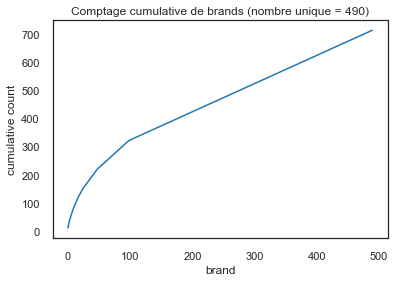

In [26]:
def plot_brands(df: pd.DataFrame):
    nb_brands = df['brand'].nunique()
    df['brand'].value_counts(normalize=False).cumsum(
    ).reset_index(drop=True).plot(kind='line')
    ax = plt.gca()
    # ax.tick_params(labelbottom=False)
    ax.set_xlabel('brand')
    ax.set_ylabel('cumulative count')
    plt.title(f'Comptage cumulative de brands (nombre unique = {nb_brands})')


plot_brands(df_data)
to_png()


"Top_20_brands_de_l'échantillon__[Autres_valeurs_=_582].png"


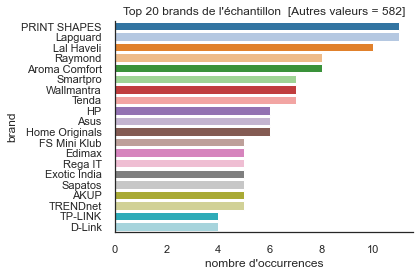

In [27]:
def top_n_freq(df: pd.DataFrame, col, nb=10, others=True, normalize=False):
    """
    Conter la fréquence des n tags plus fréquents
    return : value_counts comme un dataframe
    """
    nb = max(1, nb)
    counts_df = (df[col].value_counts(normalize=normalize)
                 .to_frame(name='freq')
                 .rename_axis(col)
                 )
    nb = min(nb, len(counts_df))
    top_n = counts_df.head(nb).copy()
    if others:
        top_n.loc['other', 'freq'] = counts_df.iloc[nb:, 0].sum()
    return top_n.reset_index()


def plot_bar_top_n(df: pd.DataFrame, col, nb=20, others=True, normalize=False, sort_values=False, palette=None,
                   ylabel=None, titre='', soustitre='', figsize=None):
    """Plot most frequent values of column as a bar chart, either as count or frequency"""
    data = top_n_freq(df, col, nb, others, normalize).copy()
    # print(data.columns.to_list())
    ax = None
    if not figsize is None:
        _, ax = plt.subplots(figsize=figsize)
    other_count = 0
    if others:
        filter_other = data[col] == 'other'
        other_count = data[filter_other]['freq'].values.sum()
        data = data[~filter_other]
    if sort_values:
        data = data.sort_values(by=col)
    if normalize:
        ax = sns.barplot(y=data[col], x=data['freq']
                         * 100, palette=palette, ax=ax)
        ax.set_xlabel('fréquence (%)')
    else:
        ax = sns.barplot(y=data[col], x=data['freq'], palette=palette, ax=ax)
        ax.set_xlabel("nombre d'occurrences")

    autres = ''
    if others and (other_count > 0):
        if normalize:
            other_count = f'{other_count * 100:.2f} %'
        else:
            other_count = f'{int(other_count)}'
        autres = f' [Autres valeurs = {other_count}]'
    if ylabel:
        ax.set_ylabel(ylabel)
    sns.despine()
    if len(titre) > 0:
        plt.suptitle(titre, y=1.05)
    plt.title(f'{soustitre} {autres}')
    plt.tight_layout()


plot_bar_top_n(df_data, 'brand', nb=20,
               soustitre="Top 20 brands de l'échantillon")
to_png()


In [28]:
df_data[['brand']].join(categ_level_1).value_counts().head(10)


brand           0                         
PRINT SHAPES    Computers                     11
Lapguard        Computers                     11
Lal Haveli      Home Decor & Festive Needs    10
Aroma Comfort   Home Furnishing                8
Raymond         Home Furnishing                8
Smartpro        Computers                      7
Tenda           Computers                      7
Home Originals  Home Furnishing                6
HP              Computers                      6
Asus            Computers                      6
dtype: int64

Le nom du brand aidera la classification (Netgear, Asus, HP seront classifiés dans la catégorie 'Computers')


### 2.3.3 Product name, description


In [29]:
df_data['product_name'].nunique()


1050

In [30]:
df_data.loc[0:3, ['brand', 'product_name', 'description']]


brand  \
0               Elegance   
1               Sathiyas   
2                Eurospa   
3  SANTOSH ROYAL FASHION   

                                                      product_name  \
0       Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
1                                       Sathiyas Cotton Bath Towel   
2                              Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet   

                                                                                           description  
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...  
1  Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...  
2  Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa ...  
3  Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet P...

On voit que le `brand` et `product_name` sont inclus dans `description` :

- ces 2 champs peuvent être supprimés
- on les garde pour voir si on peut catégoriser seulement basés sur brand ou nom du produit


### 2.3.4 Product specifications

La colonne `product_specifications` contient des key-value pairs pour les spécifications des produits


In [31]:
df_data.loc[0, ['product_specifications']].values


array(['{"product_specification"=>[{"key"=>"Brand", "value"=>"Elegance"}, {"key"=>"Designed For", "value"=>"Door"}, {"key"=>"Type", "value"=>"Eyelet"}, {"key"=>"Model Name", "value"=>"Abstract Polyester Door Curtain Set Of 2"}, {"key"=>"Model ID", "value"=>"Duster25"}, {"key"=>"Color", "value"=>"Multicolor"}, {"key"=>"Length", "value"=>"213 cm"}, {"key"=>"Number of Contents in Sales Package", "value"=>"Pack of 2"}, {"key"=>"Sales Package", "value"=>"2 Curtains"}, {"key"=>"Material", "value"=>"Polyester"}]}'],
      dtype=object)

number of unique specification_keys : 430
"Top_Specification_Keys__[Autres_valeurs_=_2795].png"


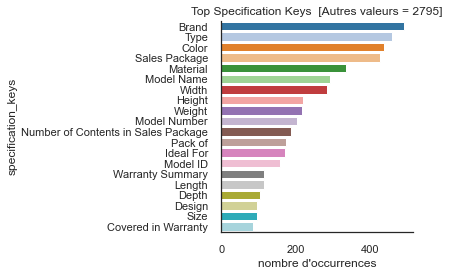

In [32]:
# import json


def get_spec_keys(spec_text):
    try:
        items = json.loads(spec_text)
        return [item['key'] for item in items]
    except:
        return np.NaN


specification_keys = (df_data['product_specifications']
                      .str.replace('=>', ':')
                      .str.lstrip('{"product_specification":')
                      .str.rstrip('}')
                      .map(lambda x: get_spec_keys(x))
                      .rename('specification_keys')
                      )

spec_keys = specification_keys.explode().to_frame()

print(
    f"number of unique specification_keys : {spec_keys['specification_keys'].nunique()}")

plot_bar_top_n(spec_keys, 'specification_keys',
               soustitre='Top Specification Keys')
to_png()


Il semble que les `value` de chaque key-value pair sont inclus dans le champs `description`

- donc on peut supprimer ce champ.


### 2.3.5 Dates des échantillons (crawl_timestamp)

- Est-ce que les données sont comparables (ils viennent des mêmes dates) ?
- Les échantillons viennent d'un période de 7 mois


"Distribution_des_dates_des_données.png"


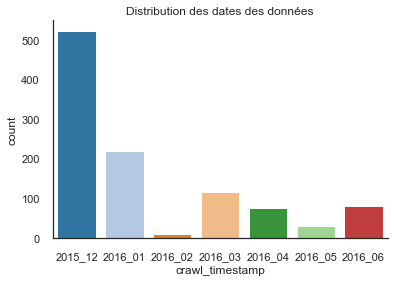

In [33]:
sns.countplot(x=pd.to_datetime(
    df_data['crawl_timestamp']).dt.strftime('%Y_%m').sort_values())
sns.despine()
plt.title('Distribution des dates des données')
to_png()


### 2.3.6 Distribution des prix

Les colonnes `retail_price` et `discounted_price` peuvent aider à classifier les produits entre les catégories, car on attend que des produits de soins soient moins chers que les ordinateurs, par exemple

Néanmoins, comme les données vient de dates différentes, on évite d'utiliser le prix pour la classification


"Distribution_de_prix_par_catégorie_(échelle_logarithmique).png"


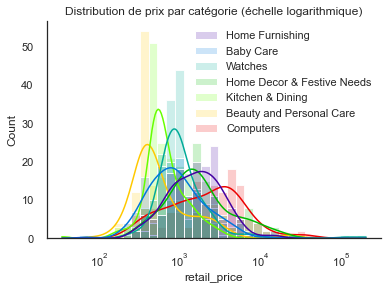

In [34]:
categ_level_1 = df_data['product_category_tree'].str.lstrip(
    '["').str.rstrip('"]').str.split(' >>', expand=True).iloc[:, 0]

sns.histplot(data=df_data, x='retail_price', hue=categ_level_1,
             palette='nipy_spectral',
             alpha=0.2,
             log_scale=True,
                     kde=True)
sns.despine()
plt.title(f'Distribution de prix par catégorie (échelle logarithmique)')
to_png()


## 2.4 Elimination des colonnes non pertinentes au problématique

Avant de faire du feature engineering, on supprime les colonnes non utilisées pour classification


In [35]:
print(list(df_data.columns))


['uniq_id', 'crawl_timestamp', 'product_url', 'product_name', 'product_category_tree', 'pid', 'retail_price', 'discounted_price', 'image', 'is_FK_Advantage_product', 'description', 'product_rating', 'overall_rating', 'brand', 'product_specifications']


In [36]:
def drop_unused_columns(df):
    """Supprimer les colonnes qui ne sont pas pertinentes"""
    colonnes_non_pertinentes = ['uniq_id', 'crawl_timestamp', 'product_url', 'retail_price', 'discounted_price',
                                'is_FK_Advantage_product', 'product_rating', 'overall_rating', 'product_specifications']
    cols_to_drop = cols_in_df(df_cleaned, colonnes_non_pertinentes)
    print(f'dropping {len(cols_to_drop)} unused columns')
    return df.drop(columns=cols_to_drop)


df_cleaned = (
    df_data
    .pipe(fill_missing_values)
    .pipe(drop_unused_columns)
)

print(f'{df_data.shape} --> {df_cleaned.shape}')


dropping 9 unused columns
(1050, 15) --> (1050, 6)


# 3. Feature engineering / preprocessing

Les features à créer pour classifier les textes :

- préparation des **catégories** à partir du `product_category_tree`
- préparation des **descriptions nettoyées** pour entrer dans des modèles
- création des **topics** (sujets) basé sur ces descriptions nettoyées (pour comparer avec les catégories de `product_category_tree`)


## 3.1 Préparation des catégories

Features à créer à partir du `product_category_tree` :

- `categ_level_1` : les catégories à la racine de l'arbre
- `categ_level_2` : les sous-catégories (divisions dans `categ_level_1`)
- `categ_level_3` : les mini-catégories (divisions dans `categ_level_2`)
- etc


In [37]:
def remove_brackets(node: str):
    node = node.replace('["', '').replace('"]', '')
    return node


def create_categ_level(df):
    if not 'product_category_tree' in df.columns:
        return df
    else:
        df_cat = (df['product_category_tree']
                  .map(lambda x: remove_brackets(x))
                  .str.split(' >> ', expand=True))
        print(f'create_categ_level, shape= {df_cat.shape}')
        depth = len(df_cat.columns)
        df_cat.columns = [f'categ_level_{i}' for i in range(1, depth+1)]
        return pd.concat([df, df_cat], axis=1)


df_cleaned = (
    df_data
    .pipe(fill_missing_values)
    .pipe(drop_unused_columns)
    .pipe(create_categ_level)
)


dropping 0 unused columns
create_categ_level, shape= (1050, 7)


In [38]:
for col in df_cleaned.columns:
    if 'categ_level_' in col:
        print(f'{col}.nunique() = {df_cleaned[col].nunique()}')


categ_level_1.nunique() = 7
categ_level_2.nunique() = 62
categ_level_3.nunique() = 241
categ_level_4.nunique() = 349
categ_level_5.nunique() = 297
categ_level_6.nunique() = 117
categ_level_7.nunique() = 57


### 3.1.1 Categories - niveau 1

- On va d'abord essayer de classifier par niveau 1


['Home Furnishing', 'Baby Care', 'Watches', 'Home Decor & Festive Needs', 'Kitchen & Dining', 'Beauty and Personal Care', 'Computers']
"Catégories_de_niveau_1_.png"


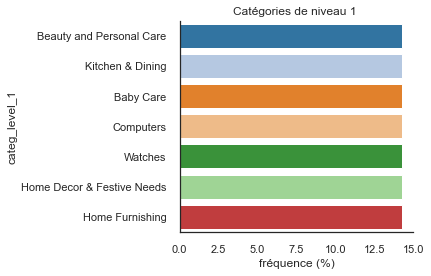

In [39]:
print(df_cleaned['categ_level_1'].unique().tolist())
plot_bar_top_n(df_cleaned, 'categ_level_1', normalize=True,
               soustitre='Catégories de niveau 1')
to_png()


### 3.1.2 Catégories - niveau 2


62
"Catégories_de_niveau_2__[Autres_valeurs_=_16-67_%].png"


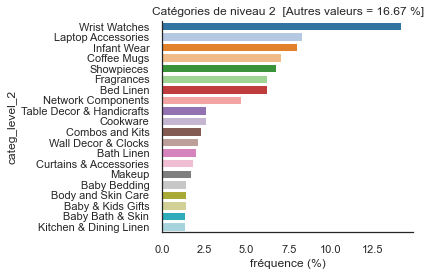

In [40]:
print(df_cleaned['categ_level_2'].nunique())
plot_bar_top_n(df_cleaned, 'categ_level_2', normalize=True,
               soustitre='Catégories de niveau 2')
to_png()


In [41]:
pd.concat([df_cleaned[['categ_level_2', 'categ_level_1']].value_counts().head(20),
           df_cleaned[['categ_level_2', 'categ_level_1']].value_counts(
).cumsum().head(20).rename('cum_sum'),
], axis=1)


0  cum_sum
categ_level_2               categ_level_1                           
Wrist Watches               Watches                     149      149
Laptop Accessories          Computers                    87      236
Infant Wear                 Baby Care                    84      320
Coffee Mugs                 Kitchen & Dining             74      394
Showpieces                  Home Decor & Festive Needs   71      465
Bed Linen                   Home Furnishing              65      530
Fragrances                  Beauty and Personal Care     65      595
Network Components          Computers                    49      644
Table Decor & Handicrafts   Home Decor & Festive Needs   27      671
Cookware                    Kitchen & Dining             27      698
Combos and Kits             Beauty and Personal Care     24      722
Wall Decor & Clocks         Home Decor & Festive Needs   22      744
Bath Linen                  Home Furnishing              21      765
Curtains & Accessories      Home Furnishing              19      784
Makeup                      Beauty and Personal Care     18      802
Baby Bedding                Baby Care                    15      817
Body and Skin Care          Beauty and Personal Care     15      832
Baby & Kids Gifts           Baby Care                    15      847
Decorative Lighting & Lamps Home Decor & Festive Needs   14      861
Baby Bath & Skin            Baby Care                    14      875

Pour l'arbre de categories, même s'il y a 62 catégories de niveau 2, environ 90% des produits sont dans les 20 plus grandes catégories de niveau 2.

- On peut aussi évaluer la performance de classification à niveau 2, pour mieux comprendre les descriptions qui sont les mieux classifiés dans chaque catégorie principal.


### 3.1.3 Catégories - niveau 3


241
"Catégories_de_niveau_3__[Autres_valeurs_=_45-37_%].png"


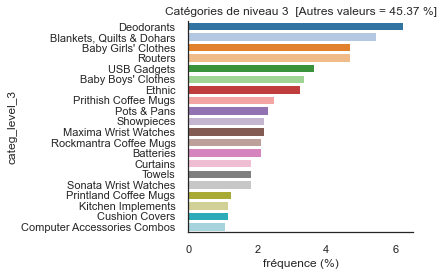

In [42]:
print(df_cleaned['categ_level_3'].nunique())
plot_bar_top_n(df_cleaned, 'categ_level_3', normalize=True,
               soustitre='Catégories de niveau 3')
to_png()


Avec seulement 1050 données, il sera très difficile de classifier entre 241 différentes catégories de niveau 3.

- Par exemple, distinguer entre les marques de 'Coffee Mugs'


## 3.2 Préparation (preprocessing) des descriptions des données

On essaie d'utiliser le champ `description` des produits pour les classifier dans les catégories de niveaux 1, 2, 3...

Il faut préparer les descriptions avant de les fournir aux modèles de machine learning :

- mettre tout en minuscule
- retirer les mots de liaison
- retirer la ponctuation
- enlever les chiffres (si besoin)
- transformer les phrases en liste de tokens (en liste de mots)
- retirer mots de liaison ou qui n’apportant pas de sens (**stopwords**)
- lemmatizer
- reformer les phrases avec les mots restants

#### Références

- <https://inside-machinelearning.com/preprocessing-nlp-tutoriel-pour-nettoyer-rapidement-un-texte/>


### 3.2.1 Features à créer à partir du `description` :

Chaque modèle a des requisites différents :

- `sentence_bow` : descriptions en minuscule, sans mots inutiles, mais pas lemmatizés pour BOW (Bag-of-Words) et TF-IDF (term frequency-inverse document frequency)
  - On utilisera ces 'bag-of-words' pour les 'baseline' model
- `sentence_bow_lem` : traitement de `sentence_bow`, lemmatizés pour BOW, TF-IDF et Word2Vec
- `sentence_dl` : descriptions nettoyées


#### Options pour nettoyage :

- bibliothèque NLTK
- bibliothèque gensims.utils
- Notre propre bibliothèque


#### 3.2.1.2 Import de NLTK pour nettoyage des champs de texte

On utilise la librairie nltk (Natural Language Toolkit), pour aider le nettoyage

On télécharge les stopwords, ponctuation et lemmatization

- <https://www.nltk.org/data.html>


In [43]:
# import nltk

# stopwords
nltk.download('stopwords')
# punctuation
nltk.download('punkt')
# lemmatization
nltk.download('wordnet')
# Open Multilingual Wordnet Project lemmatizations
nltk.download('omw-1.4')
pass

# Définir la langue qu'on veut utiliser pour nettoyer le champ de texte `description`
NTLK_LANGUAGE = 'english'


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\mc\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### 3.2.2 Mots fréquents dans les descriptions

Avant nettoyage des descriptions, on regarde les mots les plus utilisés


In [44]:
STOP_WORDS_EN = list(set(nltk.corpus.stopwords.words('english')))


def word_filter(list_words, stop_w=STOP_WORDS_EN):
    return [w for w in list_words if not w in stop_w]


tokenizer = nltk.RegexpTokenizer(r'[a-z]+')


def freq_words(sentences: pd.Series,
               token_fct=tokenizer.tokenize,
               filter_fct=word_filter,
               exclude=STOP_WORDS_EN,
               include=None,
               show_freq=True,
               normalize=True,
               nb=10) -> pd.DataFrame:
    """
    Comptage de la fréquence d'occurrences de chaque mot

    Parameters
    ----------
        sentences   series de phrases (ou mots) à compter les fréquences des mots
        token_fct   fonction pour diviser les phrases en tokens (mots)
        filter_fct  fonction pour filtrer les mots (avant le comptage)
        exclude     mots à exclure (après le comptage)
        include     mots à inclure dans le comptage
        show_freq   si vrai, retourner les fréquences/effectifs des mots, sinon retourner seulement les mots
        normalize   si vrai, retourner la fréquence (%), si faux, retourner l'effectif (count)
        nb          nombre de mots à retourner

    Returns
    ---------
        les mots plus fréquents, optionnellement avec leurs fréquences ou effectifs
    """

    corpus = sentences.str.lower().map(lambda x: token_fct(x))
    corpus = corpus.map(lambda x: filter_fct(x)).explode()

    # corpus = ' '.join(sentences)
    # corpus = nltk.word_tokenize(corpus)

    # exclure les stopwords standard - trop fréquent
    if not exclude is None:
        corpus = [w for w in corpus if not w in exclude]

    word_count = ((pd.Series(corpus)
                  .value_counts(normalize=normalize)
                   .to_frame('freq'))
                  .rename_axis('word')
                  .reset_index()
                  )

    if not include is None:
        # inclure seulement les mots sélectionnées
        # faire après value_counts pour fréquence en pourcentage
        word_count = word_count[word_count['word'].isin(include)]

    nb = min(nb, len(word_count))
    word_count = word_count.head(nb)

    if show_freq == False:
        # retourne seulement les top mots
        word_count = word_count.drop('freq', axis=1).T
    elif normalize:
        # retourne les top mots et fréquence (%)
        word_count['freq'] *= 100
    else:
        # retourne les top mots et effectif (comptage)
        word_count = word_count.rename(columns={'freq': 'count'})

    # retourne est transposé pour réduire l'espace d'affichage
    return word_count.T


print("mots plus fréquent dans 'product_name'")
print(freq_words(df_cleaned['product_name']))
print('----------------------------')
print("mots plus fréquent dans 'description'")
print(freq_words(df_cleaned['description']))
freq_words(df_cleaned['description'], nb=20, show_freq=True)


mots plus fréquent dans 'product_name'
          0    1       2    3          4     5      6    7        8    9
word  watch  set  analog   cm  showpiece  baby  combo  men  ceramic  mug
freq   2.23 2.00    1.94 1.63       1.56  1.39   1.38 1.16     1.16 1.13
----------------------------
mots plus fréquent dans 'description'
        0         1     2    3         4         5        6     7  \
word   rs  products  free  buy  delivery  shipping  genuine  cash   
freq 1.60      1.11  1.09 1.02      1.00      0.99     0.99  0.99   

                8    9  
word  replacement   cm  
freq         0.98 0.98  


0         1     2    3         4         5        6     7   \
word   rs  products  free  buy  delivery  shipping  genuine  cash   
freq 1.60      1.11  1.09 1.02      1.00      0.99     0.99  0.99   

               8    9    10        11   12         13      14        15  \
word  replacement   cm  day  flipkart  com  guarantee  online  features   
freq         0.98 0.98 0.95      0.84 0.83       0.83    0.70      0.69   

                  16     17     18     19  
word  specifications  price  watch  color  
freq            0.65   0.62   0.58   0.58

On voit que les 20 mots les plus fréquents ne semblent pas descriptifs d'une catégorie spécifique, sauf le mot 'watch'

- ils sont plutôt les mots de publicité, dimensions ou couleur.

On vérifie si ces mots sont présents plus dans chaque catégorie


In [45]:
def freq_words_by_category(df: pd.DataFrame,
                           categ_col='categ_level_1',
                           desc_col='description',
                           exclude=STOP_WORDS_EN,
                           include=None,
                           show_freq=True,
                           normalize=True,
                           nb=10) -> pd.DataFrame:
    """
    Trouver la fréquence des mots dans desc_col, grouped by categ_col
    exclude sont les mots à exclure du comptage
    include sont les mots à inclure dans la liste
    - si include=None, renvoie un la fréquence des nb mots les plus fréquents
    - si include, renvoie un dataframe avec index=catégorie, columns =[0..nb], values = words"""

    df_top = pd.DataFrame({}, columns=[categ_col])

    categories = df[categ_col].unique()
    for categ in categories:
        item_descriptions = df[df[categ_col] == categ][desc_col]
        df_categ_words = freq_words(item_descriptions, exclude=exclude, include=include,
                                    show_freq=show_freq, normalize=normalize, nb=nb)
        if show_freq:
            df_categ_words = df_categ_words.T.set_index('word').T
        else:
            df_categ_words = df_categ_words.T
        df_categ_words[categ_col] = categ
        df_top = df_top.append(df_categ_words, ignore_index=True)

    return df_top


freq_words_by_category(df_cleaned, desc_col='description', show_freq=False)


categ_level_1         0            1        2         3  \
0             Home Furnishing        cm           rs   cotton      pack   
1                   Baby Care      baby       cotton  details      girl   
2                     Watches     watch       analog      men        rs   
3  Home Decor & Festive Needs        cm    showpiece       rs  products   
4            Kitchen & Dining       mug      ceramic   coffee   perfect   
5    Beauty and Personal Care  flipkart          com       rs  products   
6                   Computers    laptop  replacement      usb  warranty   

        4         5               6            7          8          9  
0   cover  products             buy       design       free       cash  
1  fabric     dress  specifications        ideal    general         rs  
2     day       buy        products      genuine  guarantee     online  
3    best      free             buy          day     online     prices  
4      rs      mugs        material           ml        day   features  
5     set      free           combo  replacement   delivery        day  
6      rs   adapter            free      battery      power  guarantee

#### 3.4.1 Visualise comme word clouds


"Mots_fréquents_dans_chaque_catégorie_de_niveau_1.png"


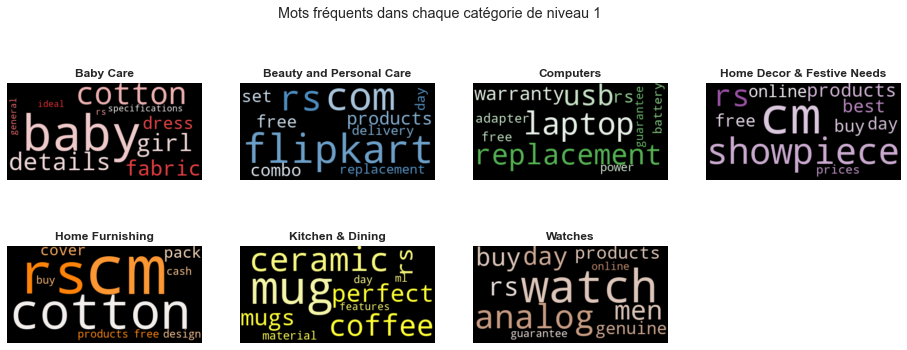

In [46]:
# from wordcloud import WordCloud

def plot_wordcloud(sentences: pd.Series, cmap='nipy_spectral', ax=None, nb=20):
    cloud = WordCloud(stopwords=None, background_color=None,
                      colormap=cmap)
    topwords: pd.DataFrame = freq_words(sentences, nb=nb).T.set_index('word')
    topword_dict = dict(zip(list(topwords.index), list(topwords['freq'])))
    # print (topword_dict)
    cloud.generate_from_frequencies(topword_dict)
    if ax is None:
        plt.figure()
        ax = plt.gca()
    ax.imshow(cloud, interpolation="bilinear")
    plt.axis("off")


def plot_wordclouds_by_categ(df, feature='description', categ_col='categ_level_1',
                             cmap='nipy_spectral', nb=10):
    categories = sorted(list(df[categ_col].unique()))
    colors = sns.color_palette(cmap, n_colors=len(categories)).as_hex()
    # print(colors)
    # print(categories)
    n_cols = 4
    n_rows = len(categories) // n_cols + (len(categories) % n_cols > 0)
    _ = plt.figure(figsize=(n_cols*4, n_rows*3))
    for n, category in enumerate(categories):
        ax = plt.subplot(n_rows, n_cols, n + 1)
        sentences = df[df[categ_col] == category][feature]
        color = sns.color_palette(f'light:{colors[n]}', as_cmap=True)
        plot_wordcloud(sentences, ax=ax, cmap=color, nb=nb)
        plt.title(category, fontweight='bold')

    plt.subplots_adjust(hspace=0, wspace=0.2)


plot_wordclouds_by_categ(df_cleaned, feature='description',
                         categ_col='categ_level_1', cmap='Set1')
plt.suptitle('Mots fréquents dans chaque catégorie de niveau 1')
to_png()


Les mots de publicité sont présents plus dans certaines catégories

- ils sont des faux indicateurs de catégorie, car probablement ajoutés si le produit manque de description, ou après catégorisation du produit.

On compare avec les mots les plus fréquents dans 'product_name'


In [47]:
freq_words_by_category(df_cleaned, desc_col='product_name', show_freq=False)


categ_level_1          0        1         2       3  \
0             Home Furnishing     cotton   single  abstract  double   
1                   Baby Care       baby     girl       boy   dress   
2                     Watches      watch   analog       men   women   
3  Home Decor & Festive Needs  showpiece       cm      wall    inch   
4            Kitchen & Dining        mug  ceramic  prithish       l   
5    Beauty and Personal Care      combo      set     cream     kit   
6                   Computers        usb   laptop      cell     led   

           4           5        6          7           8          9  
0     floral       cover  blanket     quilts  multicolor  polyester  
1     cotton         set  printed      shirt        blue    sticker  
2       boys      maxima   sonata    digital       girls       gold  
3     lights      haveli      lal       rice      wooden      brass  
4     kadhai  rockmantra   design  printland          ml     bottle  
5  jewellery           e      spf     vanity     massage    vitamin  
6    battery       light        n         hp      router         dv

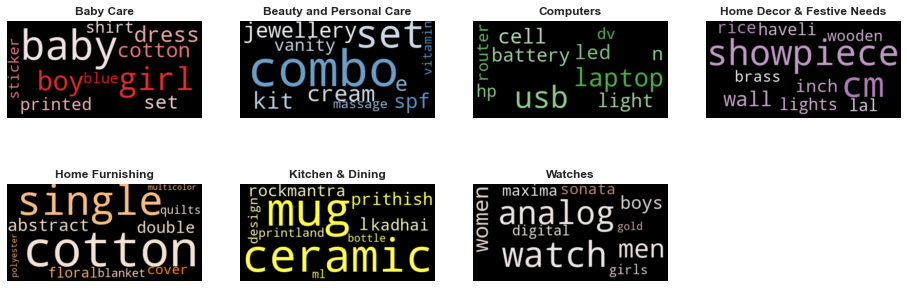

In [48]:
plot_wordclouds_by_categ(df_cleaned, feature='product_name',
                         categ_col='categ_level_1', cmap='Set1')


On demande si la classification marchera mieux sur product_name, car c'est plus propre.


In [49]:
# seed = np.random.randint(0, 1050)
seed = 18
print(f"[{seed}] : {df_data['product_name'][seed]}")
print(f"[{seed}] : {df_data['description'][seed]}")


[18] : Franck Bella FB74C Analog Watch  - For Boys, Men
[18] : Franck Bella FB74C Analog Watch  - For Boys, Men - Buy Franck Bella FB74C Analog Watch  - For Boys, Men  FB74C Online at Rs.780 in India Only at Flipkart.com. - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!


### 3.2.3 Suppression de la publicité "flipkart" (adwords)

On voit que beaucoup des descriptions contient des phrases qui n'ont rien à voir avec le produit.

Pour les produits qui n'ont pas une description ou specification, peut-être flipkart ont ajouté ces phrases de publicité pour ne laisse pas l'espace de description vide


In [50]:
print(df_data['description'][795])
print(df_data['description'][263])
print(df_data['description'][746])


Rana Watches Bw-Prsmd Barbie Analog Watch  - For Girls - Buy Rana Watches Bw-Prsmd Barbie Analog Watch  - For Girls  Bw-Prsmd Online at Rs.199 in India Only at Flipkart.com. - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!
Buy Woodino Handicrafts Showpiece  -  6.5 cm for Rs.399 online. Woodino Handicrafts Showpiece  -  6.5 cm at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.
Buy eCraftIndia Floral Cushions Cover at Rs. 404 at Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!


Par exemple :

> '**Buy** eCraftIndia Floral Cushions Cover at Rs. 404 **at Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!**'

Ces phrases font du bruit et réduit la discrimination entre les produits


In [51]:
ADVERTS = [
    'Buy', 'Only Genuine Products', '!', 'Cash On Delivery', 'Free Shipping', '30 Day Replacement Guarantee',
    'Online', 'at Flipkart.com', 'from Flipkart.com', 'Flipkart.com', 'best prices', 'Lowest Prices',
    'Great Discounts', 'in India Only'
]


def get_useless_adwords(df, adverts=ADVERTS):
    """
    Trouve les phrases de publicité dans les descriptions, qui ne décrit
    pas le produit
     """
    df = df.copy()
    ad_cols = []
    for idx, ad in enumerate(adverts):
        ad_col = f'AD_{idx}'
        ad_cols.append(ad_col)
        df[ad_col] = df['description'].str.lower().str.contains(ad.lower())

    print(df[ad_cols].sum(axis=0))


get_useless_adwords(df_data)


AD_0     578
AD_1     564
AD_2     435
AD_3     564
AD_4     564
AD_5     469
AD_6     390
AD_7     226
AD_8     150
AD_9     384
AD_10    185
AD_11     17
AD_12    134
AD_13    134
dtype: int64


#### Suppression des phrases de publicité dans les descriptions

Les publicités semblent être ajoutées come phrases

- on les supprime ici comme une phrase

Note : Un alternatif sera d'ajouter les mots aux 'stopwords', mais

- on risque de perdre les mêmes mots hors du contexte des publicités
- cette procédure n'est pas appelée dans le prétraitement de deep learning.


In [52]:
# import re


def remplace(sentence: str, old_str: str, new_str: str = ' ', case_sensitive=False) -> str:
    """
    Remplace une chaine dans phrase avec une nouvelle chaine
    """
    if case_sensitive:
        return sentence.replace(old_str, new_str)
    else:
        return re.sub(re.escape(old_str), new_str, sentence, flags=re.IGNORECASE)


def remove_useless_adwords(sentence: str, adverts=ADVERTS):
    """Supprime les phrases de publicité dans UNE description"""
    for ad in adverts:
        sentence = remplace(sentence, ad, ' ')
    return sentence


TEST_ADVERTS = df_data['description'][746]
print(TEST_ADVERTS)
TEST_DESCRIPTION_1 = remove_useless_adwords(TEST_ADVERTS)
print(TEST_DESCRIPTION_1)


Buy eCraftIndia Floral Cushions Cover at Rs. 404 at Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!
  eCraftIndia Floral Cushions Cover at Rs. 404  .  .  .   


### 3.2.4 Suppression des prix dans la description des produits

On peut considérer que le prix n'est pas une description du produit :

- Les produits ont été obtenus à des dates diverses
- Les prix dépendent du vendeur, date, devises..


In [53]:

def remove_prices(sentence: str) -> str:
    """Supprimer les prix dans les descriptions"""
    # \bRs.[0-9]*\.[0-9]*\b , tested at https://regex101.com/
    if isinstance(sentence, list):
        sentence = (' ').join(sentence)
    # Supprime l'espace entre Rs. et le montant, si besoin
    sentence = remplace(sentence, 'Rs. ', 'Rs.')
    sentence = remplace(sentence, 'at Rs.', 'Rs.')
    sentence = remplace(sentence, 'only for Rs.', 'Rs.')
    sentence = remplace(sentence, 'for Rs.', 'Rs.')
    sentence = remplace(sentence, 'Price Rs.', 'Rs.')
    sentence = remplace(sentence, 'Price:', ' ')
    # si le montant est en décimales
    sentence = re.sub(r'\b[Rr]s.[0-9]*[\.,][0-9]*\b', ' ', sentence).strip()
    # si le montant est sans point decimal
    sentence = re.sub(r'\b[Rr]s.[0-9]*\b', ' ', sentence).strip()
    # suppression des doubles espaces laissés par suppression des mots
    sentence = re.sub('\s+', ' ', sentence)
    return sentence


print(TEST_DESCRIPTION_1)
TEST_DESCRIPTION_2 = remove_prices(TEST_DESCRIPTION_1)
print(TEST_DESCRIPTION_2)


  eCraftIndia Floral Cushions Cover at Rs. 404  .  .  .   
eCraftIndia Floral Cushions Cover . . .


#### Test des procedures pour supprimer les publicités et prix

Les procedures ci-dessus sont améliorés en testant aléatoirement sur le jeu de données


In [54]:
# seed = np.random.randint(0, 1050)
seed = 237
test_description = df_data['description'][seed]
test_cleaned = remove_prices(remove_useless_adwords(test_description))
print(f'original [{seed}] : \n{test_description}')
print(f'cleaned [{seed}] : \n{test_cleaned}')


original [237] : 
Buy Lal Haveli Iron Wall Decorative Musician Showpiece  -  50.8 cm for Rs.6949 online. Lal Haveli Iron Wall Decorative Musician Showpiece  -  50.8 cm at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.
cleaned [237] : 
Lal Haveli Iron Wall Decorative Musician Showpiece - 50.8 cm . Lal Haveli Iron Wall Decorative Musician Showpiece - 50.8 cm at with & . . .


### 3.2.4 Tokenization

Tokenization est le processus de convertir une chaine en tokens (en général, mots et ponctuation)


In [55]:
# from typing import List
# import string
# import nltk
# import re

def lower_start_fct(list_words: List[str]) -> List[str]:
    """lower case et alpha"""
    lw = [w.lower() for w in list_words if (not w.startswith("@"))
          #                                   and (not w.startswith("#"))
          and (not w.startswith("http"))]
    return lw


def tokenizer_fct(sentence: str, language=NTLK_LANGUAGE, sans_ads=False) -> List[str]:
    """
    return tokens as space-separated string
    - alternative : `tokens = gensim.utils.simple_preprocess(sentence)`
    """
    if sans_ads:
        sentence = remove_useless_adwords(sentence)
        sentence = remove_prices(sentence)

    sentence = re.sub('\S*@\S*\s?', '', sentence)  # remove emails
    sentence = re.sub('\s+', ' ', sentence)  # remove newline chars
    sentence = re.sub("\'", "", sentence)  # remove single quotes
    # supprime le ponctuation
    sentence = ''.join([i for i in sentence if i not in string.punctuation])
    # supprime les valeurs numériques
    sentence = ''.join(i for i in sentence if not i.isdigit())
    # assure words are recognised
    sentence = sentence.lower()
    sentence_clean = (sentence.replace('-', ' ')
                      .replace('+', ' ')
                      .replace('/', ' ')
                      #   .replace('.', '. ')
                      .replace(',', ', ')
                      .replace('#', ' '))
    word_tokens = nltk.tokenize.word_tokenize(
        sentence_clean, language=language)
    return word_tokens


print(tokenizer_fct(TEST_ADVERTS, sans_ads=True))


['ecraftindia', 'floral', 'cushions', 'cover']


### 3.2.5 Stop words

Les stopwords dans du contexte pour les autres mots.
On ne le supprime pas pour deep-learning comme BERT et USE

Pour les autres algorithmes :

- On supprime les stopwords de la librairie NLTK (dans la langue des descriptions)
- on analyse les mots les plus fréquents qui reste

- On élimine :
  - les mots les plus fréquentes non discriminatoires (bruit)
  - les mots qui ne sont pas discriminatoire de produit ('key features', ')
  - les mots oubliés de publicité


In [56]:
STOP_WORDS_EN = list(set(nltk.corpus.stopwords.words('english')))
print(STOP_WORDS_EN[:40])


['her', 'up', 'in', 'on', 'their', 'just', 'above', 'd', "didn't", "you've", "shouldn't", 'itself', 'them', 'because', 'theirs', 'while', 'very', 'yourselves', 'what', 'but', 'o', 'had', 'before', 'now', 'when', 'been', 'has', 'such', 'than', 'couldn', 'isn', "shan't", 'himself', 'again', 've', 'have', 'once', 'll', 'until', 'yours']


In [57]:
# from typing import List


def lower_start_fct(list_words: List[str]) -> List[str]:
    """lower case et alpha"""
    lw = [w.lower() for w in list_words if (not w.startswith("@"))
          #                                   and (not w.startswith("#"))
          and (not w.startswith("http"))]
    return lw


def stop_word_en_filter(list_words: List[str], stop_w=STOP_WORDS_EN) -> List[str]:
    """Stop words"""
    filtered_w = [w for w in list_words if not w in stop_w]
    return filtered_w


print(stop_word_en_filter(tokenizer_fct(TEST_ADVERTS, sans_ads=True)))


['ecraftindia', 'floral', 'cushions', 'cover']


#### Trouver les mots le plus fréquents dans le corpus

On cherche les mots fréquents non-discriminatoires.

- Certain des mots fréquents sont utiles pour classification, d'autres non


In [58]:
# from typing import List

def get_corpus_freq(descriptions: pd.Series, nb=20, stop_w=STOP_WORDS_EN) -> List[str]:
    word_lists = descriptions.str.lower().map(lambda x: tokenizer_fct(x))
    corpus = word_lists.explode()
    print(f'unique words: {corpus.nunique()}')
    corpus_2 = pd.Series(stop_word_en_filter(corpus, stop_w=stop_w))
    most_freq = corpus_2.value_counts()[:nb]

    return most_freq


cleaned_corpus = df_data['description'].map(
    lambda x: remove_prices(remove_useless_adwords(x)))

most_freq = get_corpus_freq(cleaned_corpus, nb=40)
print(f'most_freq: {most_freq.index.to_list()}')


unique words: 5681
most_freq: ['cm', 'features', 'watch', 'mug', 'color', 'pack', 'baby', 'material', 'type', 'set', 'box', 'general', 'cotton', 'package', 'sales', 'analog', 'number', 'warranty', 'quality', 'girls', 'details', 'brand', 'product', 'model', 'key', 'ceramic', 'design', 'laptop', 'showpiece', 'fabric', 'made', 'perfect', 'boys', 'inch', 'men', 'size', 'usb', 'specifications', 'ideal', 'dimensions']


#### Création d'une liste de stopwords spécifique pour ce corpus

On ajoute itérativement des stopwords spécifiques de ce corpus à fin de réduire les mots de bruit dans le corpus.

- les mots les plus fréquents
- les mots les moins fréquents
- les mots avec un score IDF (Inverse Document Frequency) très bas

- <https://kavita-ganesan.com/tips-for-constructing-custom-stop-word-lists/>


In [59]:
stop_frequent = freq_words(df_cleaned['description'], nb=20)
stop_frequent = stop_frequent.T['word'].tolist()
for word in ['watch', 'box', 'set', 'pack', 'color', 'cm']:
    if word in stop_frequent:
        stop_frequent.remove(word)
stop_frequent.extend(['details'])
print(stop_frequent)


['rs', 'products', 'free', 'buy', 'delivery', 'shipping', 'genuine', 'cash', 'replacement', 'day', 'flipkart', 'com', 'guarantee', 'online', 'features', 'specifications', 'price', 'details']


In [60]:
# from sklearn.feature_extraction.text import TfidfVectorizer

def get_low_idf_words(sentences: pd.Series):
    tfv = TfidfVectorizer(use_idf=True)
    sentences = sentences.map(lambda x: (' ').join(
        stop_word_en_filter(tokenizer_fct(x))))
    tfv.fit_transform(sentences)
    df_idf = pd.DataFrame({'word': tfv.get_feature_names_out(),
                           'idf': tfv.idf_})
    return df_idf.sort_values(by='idf')


idf = get_low_idf_words(df_cleaned['description'])
idf.head(30).T


4204  1963      3842 667       1303     2060  748       4412 1255  \
word   rs  free  products  buy  delivery  genuine  cash  shipping  day   
idf  1.14  1.57      1.58 1.60      1.62     1.62  1.62      1.62 1.73   

             4072       2194    3403         1900   3806     2053      1807  \
word  replacement  guarantee  online  flipkartcom  price  general  features   
idf          1.76       1.80    1.99         2.00   2.12     2.31      2.38   

     568   5133   4243     3486    3346  459    952    582   3485    3809  \
word  box  type  sales  package  number  best  color  brand  pack  prices   
idf  2.44  2.54   2.57     2.57    2.58  2.59   2.59   2.62  2.62    2.63   

          3004 2649 908    2165  
word  material  key   cm  great  
idf       2.64 2.65 2.72   2.84

In [61]:
stop_low_idf = idf.head(20)['word'].to_list()
# on garde les mots fréquents indicatifs de certain catégories
# 'watch' pour catégorie 'watches'
for word in ['watch', 'box', 'set', 'pack', 'color', 'cm']:
    if word in stop_low_idf:
        stop_low_idf.remove(word)
print(stop_low_idf)


['rs', 'free', 'products', 'buy', 'delivery', 'genuine', 'cash', 'shipping', 'day', 'replacement', 'guarantee', 'online', 'flipkartcom', 'price', 'general', 'features', 'type', 'sales', 'package']


In [62]:
# import time

STOP_WORDS_BASIC = ['[', ']', ',', '.', ':', '!',
                    '?', '(', ')', '%', '&', "'", "''", "'s"]

# frequent
# stop_frequent = ['key', 'general', 'detail', 'details',
#                  'feature', 'features', 'specification', 'specifications']
stop_id = ['brand', 'product', 'products', 'id', 'model']
stop_pub = ['sales', 'price', 'warranty']
stop_adjectives = ['best', 'design', 'yes']


# STOP_WORDS_CUSTOM = [*stop_frequent, *stop_id, *stop_pub, *stop_adjectives]
STOP_WORDS_CUSTOM = list({*stop_frequent, *stop_low_idf})
# STOP_WORDS_CUSTOM = list(set([*stop_low_idf]))
print(f'stop_words_custom : {STOP_WORDS_CUSTOM}')

timestr = time.strftime("%Y-%m-%d-%H.%M.%S")
pd.DataFrame(STOP_WORDS_CUSTOM).to_csv(
    f'{IMAGE_FOLDER}/stopwords_custom_{timestr}.csv')

STOP_WORDS_ALL = list(
    set([*STOP_WORDS_EN, *STOP_WORDS_BASIC, *STOP_WORDS_CUSTOM]))
most_freq = get_corpus_freq(cleaned_corpus, stop_w=STOP_WORDS_ALL, nb=40)
print(f'most_frequent other words: {most_freq.index.to_list()}')


stop_words_custom : ['free', 'flipkartcom', 'day', 'features', 'details', 'type', 'online', 'com', 'shipping', 'rs', 'cash', 'replacement', 'flipkart', 'sales', 'buy', 'products', 'genuine', 'price', 'specifications', 'delivery', 'package', 'general', 'guarantee']
unique words: 5681
most_frequent other words: ['cm', 'watch', 'mug', 'pack', 'color', 'baby', 'material', 'set', 'box', 'cotton', 'analog', 'number', 'warranty', 'quality', 'girls', 'brand', 'product', 'model', 'key', 'ceramic', 'design', 'laptop', 'showpiece', 'fabric', 'made', 'perfect', 'boys', 'inch', 'men', 'usb', 'size', 'multicolor', 'dimensions', 'ideal', 'skin', 'home', 'contents', 'combo', 'x', 'water']


In [63]:
stop_w_en = list(set([*STOP_WORDS_EN, *STOP_WORDS_BASIC]))

freq_words(df_data['description'].str.lower(),
           exclude=stop_w_en,
           include=STOP_WORDS_CUSTOM)


0         1     2    3         4         5        6     7   \
word   rs  products  free  buy  delivery  shipping  genuine  cash   
freq 1.60      1.11  1.09 1.02      1.00      0.99     0.99  0.99   

               8    10  
word  replacement  day  
freq         0.98 0.95

In [64]:
freq_words(df_data['description'].str.lower(),
           exclude=stop_w_en,
           include=STOP_WORDS_CUSTOM,
           normalize=False)


0         1     2    3         4         5        6     7   \
word    rs  products  free  buy  delivery  shipping  genuine  cash   
count  911       631   618  581       567       564      564   564   

                8    10  
word   replacement  day  
count          559  540

In [65]:
# fréquence de custom stopwords dans description
freq_words_by_category(df_cleaned, desc_col='description',
                       include=STOP_WORDS_CUSTOM)


categ_level_1   rs products  buy free cash shipping flipkart  \
0             Home Furnishing 1.92     1.16 1.16 1.14 1.11     1.11     1.11   
1                   Baby Care 1.07      NaN  NaN 0.51  NaN      NaN      NaN   
2                     Watches 2.44     2.34 2.34 2.34 2.34     2.34      NaN   
3  Home Decor & Festive Needs 1.51     0.97 0.88 0.89  NaN     0.82      NaN   
4            Kitchen & Dining 1.36     0.67 0.56 0.57  NaN      NaN      NaN   
5    Beauty and Personal Care 2.01     1.96  NaN 1.68 1.55     1.55     2.50   
6                   Computers 1.44     0.99 0.99 1.16 0.98     0.98      NaN   

  genuine  com delivery details specifications general package sales features  \
0    1.11 1.11     1.11     NaN            NaN     NaN     NaN   NaN      NaN   
1     NaN  NaN      NaN    1.95           1.12    1.08    0.99  0.95     0.94   
2    2.34  NaN      NaN     NaN            NaN     NaN     NaN   NaN      NaN   
3    0.82  NaN     0.83     NaN            NaN     NaN     NaN   NaN      NaN   
4     NaN  NaN     0.50     NaN           0.82     NaN     NaN   NaN     0.90   
5     NaN 2.44     1.58     NaN            NaN     NaN     NaN   NaN      NaN   
6     NaN  NaN     0.98     NaN            NaN     NaN     NaN   NaN      NaN   

  type price  day guarantee online replacement  
0  NaN   NaN  NaN       NaN    NaN         NaN  
1 0.91  0.64  NaN       NaN    NaN         NaN  
2  NaN   NaN 2.37      2.34   2.34         NaN  
3  NaN   NaN 0.87      0.82   0.84         NaN  
4 0.51  0.86 0.95       NaN    NaN         NaN  
5  NaN   NaN 1.55       NaN    NaN        1.61  
6  NaN   NaN 1.00      1.00    NaN        1.83

In [66]:
# fréquence de custom stopwords dans product_name
freq_words_by_category(df_cleaned, desc_col='product_name',
                       include=STOP_WORDS_CUSTOM)


categ_level_1  buy free products  day replacement
0             Home Furnishing 0.11 0.11      NaN  NaN         NaN
1                   Baby Care  NaN 0.11      NaN  NaN         NaN
2                     Watches  NaN  NaN      NaN  NaN         NaN
3  Home Decor & Festive Needs  NaN  NaN     0.20  NaN         NaN
4            Kitchen & Dining  NaN 0.12      NaN 0.36         NaN
5    Beauty and Personal Care  NaN 0.09      NaN  NaN         NaN
6                   Computers  NaN  NaN      NaN  NaN        0.79

In [67]:
def stop_word_filter_fct(list_words: List[str], stop_w=STOP_WORDS_ALL) -> List[str]:
    """Stop words"""
    filtered_w = [w for w in list_words if not w in stop_w]
    return filtered_w


print(lower_start_fct(stop_word_filter_fct(
    tokenizer_fct("The movie was not good at all."))))


['movie', 'good']


In [68]:


print(lower_start_fct(stop_word_filter_fct(
    tokenizer_fct(df_data['description'][6]), stop_w=STOP_WORDS_ALL)))


['camerii', 'wm', 'elegance', 'analog', 'watch', 'men', 'boys', 'camerii', 'wm', 'elegance', 'analog', 'watch', 'men', 'boys', 'wm', 'india', 'great', 'discounts']


### 3.2.5 Lemmatization


In [69]:
# from typing import List
# from nltk.stem import WordNetLemmatizer


def lemma_fct(list_words: List[str]) -> List[str]:
    """
    Lemmatizer (base d'un mot)
    """
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w


# test de lemmatizer (bug: men -> man ?)
TEST_LEMMA = 'boys girls men and women shows lots of highs and lows qualities in inches'.split(
    ' ')
print(TEST_LEMMA)
print(lemma_fct(TEST_LEMMA))


['boys', 'girls', 'men', 'and', 'women', 'shows', 'lots', 'of', 'highs', 'and', 'lows', 'qualities', 'in', 'inches']
['boy', 'girl', 'men', 'and', 'woman', 'show', 'lot', 'of', 'high', 'and', 'low', 'quality', 'in', 'inch']


### 3.2.6 Préparation commune des traitements

Pour analyser les descriptions


#### Création de feature `sentence_dl` pour deep learning

Les modèles de deep learning comme [BERT](https://arxiv.org/abs/1810.04805) et [USE](https://arxiv.org/abs/1803.11175) traitent les mots dans le contexte de leurs phrases

- BERT : Bidirectional Encoder Representations from Transformers
- USE : Universal Sentence Encoder

Avec BERT et USE, il ne faut pas trop traiter les textes, sinon, vous perdez le contexte (racine, lemmatisation) ou modifier purement et simplement les textes (suppression des mots vides).

Les descriptions des produits semblent déjà traités, donc on essaie d'eviter de supprimer les stopwords et lemmatization.


In [70]:
print(lower_start_fct(stop_word_filter_fct(
    tokenizer_fct("The movie was not good at all."))))


['movie', 'good']


In [71]:

def transform_dl_fct(desc_text: str) -> str:
    """
    Fonction de préparation du texte pour le Deep learning
    (USE et BERT)
    With BERT you don't process the texts; otherwise, you lose the context (stemming, lemmatization)
    or change the texts outright (stop words removal).
    """
    desc_text = remove_useless_adwords(desc_text)
    desc_text = remove_prices(desc_text)
    word_tokens = tokenizer_fct(desc_text)
    # sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    transf_desc_text = ' '.join(lw)
    return transf_desc_text


TEST_TRANSFORM = df_data['description'][142]
print('---Original------')
print(TEST_TRANSFORM)
print('---Transformed----')
transform_dl_fct(TEST_TRANSFORM)


---Original------
Rockmantra Abstracts 16 Ceramic Mug (5.5 l)
                         Price: Rs. 199
				
Size : 3.5" X 4"icg yet fresh start to your day. An exclusive creation by Rockmantra, this mug features porcelain crafting ensuring the design stays permanent for years to come and making it a perfect pick to gift your loved ones too!Dishwasher and microwave safe. Product details and specifications :
Size : 3.5" X 4"icet fresh start to your day. An exclusive creation by Rockmantra, this mug features porcelain crafting ensuring the design stays permanent for years to come and making it a perfect pick to gift your loved ones too!Dishwasher and microwave safe. Product details and specifications :
---Transformed----


'rockmantra abstracts ceramic mug l give a thrilling yet fresh start to your day an exclusive creation by rockmantra this mug features porcelain crafting ensuring the design stays permanent for years to come and making it a perfect pick to gift your loved ones too dishwasher and microwave safe product details and specifications material ceramic size x give a thrilling yet fresh start to your day an exclusive creation by rockmantra this mug features porcelain crafting ensuring the design stays permanent for years to come and making it a perfect pick to gift your loved ones too dishwasher and microwave safe product details and specifications material ceramic size x'

#### Création de feature `sentence_bow`


In [72]:
def transform_bow_fct(desc_text: str) -> str:
    """
    Fonction de préparation du texte pour le bag of words
    (Countvectorizer et Tf_idf, Word2Vec)
    """
    desc_text = remove_useless_adwords(desc_text)
    desc_text = remove_prices(desc_text)

    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lw)
    return transf_desc_text


transform_bow_fct(TEST_TRANSFORM)


'rockmantra abstracts ceramic mug l give thrilling yet fresh start exclusive creation rockmantra mug porcelain crafting ensuring design stays permanent years come making perfect pick gift loved ones dishwasher microwave safe product material ceramic size x give thrilling yet fresh start exclusive creation rockmantra mug porcelain crafting ensuring design stays permanent years come making perfect pick gift loved ones dishwasher microwave safe product material ceramic size x'

#### Création de feature `sentence_bow_lem`


In [73]:

def transform_bow_lem_fct(desc_text: str) -> str:
    """
    Fonction de préparation du texte pour le bag of words
    avec lemmatization (Countvectorizer et Tf_idf, Word2Vec)
    """
    desc_text = remove_useless_adwords(desc_text)
    desc_text = remove_prices(desc_text)
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text


print(TEST_ADVERTS)
print(transform_bow_lem_fct(TEST_ADVERTS))
print(TEST_TRANSFORM)
print(transform_bow_lem_fct(TEST_TRANSFORM))


Buy eCraftIndia Floral Cushions Cover at Rs. 404 at Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!
ecraftindia floral cushion cover
Rockmantra Abstracts 16 Ceramic Mug (5.5 l)
                         Price: Rs. 199
				
Size : 3.5" X 4"icg yet fresh start to your day. An exclusive creation by Rockmantra, this mug features porcelain crafting ensuring the design stays permanent for years to come and making it a perfect pick to gift your loved ones too!Dishwasher and microwave safe. Product details and specifications :
Size : 3.5" X 4"icet fresh start to your day. An exclusive creation by Rockmantra, this mug features porcelain crafting ensuring the design stays permanent for years to come and making it a perfect pick to gift your loved ones too!Dishwasher and microwave safe. Product details and specifications :
rockmantra abstract ceramic mug l give thrilling yet fresh start exclusive creation rockmantra mug porcelain crafting ensuring design stay permanent year c

In [74]:
def transform_bow_lem_ads_fct(desc_text: str) -> str:
    """
    Fonction de préparation du texte pour le bag of words
    avec lemmatization (Countvectorizer et Tf_idf, Word2Vec)
    """
    # desc_text = remove_useless_adwords(desc_text)
    # desc_text = remove_prices(desc_text)
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text


print(TEST_ADVERTS)
transform_bow_lem_ads_fct(TEST_ADVERTS)


Buy eCraftIndia Floral Cushions Cover at Rs. 404 at Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!


'ecraftindia floral cushion cover'

### 3.2.7 Transformation de textes prêts pour les modèles


In [75]:

def transform_field(df: pd.DataFrame, text_col: str = 'description') -> pd.DataFrame:
    df = df.copy()
    df['sentence_bow'] = df[text_col].apply(lambda x: transform_bow_fct(x))
    df['sentence_bow_lem'] = df[text_col].apply(
        lambda x: transform_bow_lem_fct(x))
    df['product_name_bow_lem'] = df['product_name'].apply(
        lambda x: transform_bow_lem_fct(x))
    df['sentence_bow_lem_ads'] = df[text_col].apply(
        lambda x: transform_bow_lem_ads_fct(x))
    df['sentence_dl'] = df[text_col].apply(lambda x: transform_dl_fct(x))
    print(f'transform_field [{text_col}], df.shape={df.shape}')
    return df


df_cleaned = df_cleaned.pipe(transform_field)
df_cleaned.head(1)


transform_field [description], df.shape=(1050, 27)


uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   

                                                                                           product_url  \
0  http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdg...   

                                                 product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain   

                                                                                 product_category_tree  \
0  ["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstrac...   

                pid  retail_price  discounted_price  \
0  CRNEG7BKMFFYHQ8Z       1899.00            899.00   

                                  image  is_FK_Advantage_product  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg                    False   

                                                                                           description  \
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...   

        product_rating       overall_rating     brand  \
0  No rating available  No rating available  Elegance   

                                                                                product_specifications  \
0  {"product_specification"=>[{"key"=>"Brand", "value"=>"Elegance"}, {"key"=>"Designed For", "value...   

     categ_level_1           categ_level_2 categ_level_3  \
0  Home Furnishing  Curtains & Accessories      Curtains   

                                         categ_level_4 categ_level_5  \
0  Elegance Polyester Multicolor Abstract Eyelet Do...          None   

  categ_level_6 categ_level_7  \
0          None          None   

                                                                                          sentence_bow  \
0  key elegance polyester multicolor abstract eyelet door curtain floral curtainelegance polyester ...   

                                                                                      sentence_bow_lem  \
0  key elegance polyester multicolor abstract eyelet door curtain floral curtainelegance polyester ...   

                                         product_name_bow_lem  \
0  elegance polyester multicolor abstract eyelet door curtain   

                                                                                  sentence_bow_lem_ads  \
0  key elegance polyester multicolor abstract eyelet door curtain floral curtainelegance polyester ...   

                                                                                           sentence_dl  
0  key features of elegance polyester multicolor abstract eyelet door curtain floral curtaineleganc...

### 3.2.9 Calcul de la longueur des phrases (nombre de mots)

Certaines modèles ont besoin de savoir la longueur des phrase comme hyper paramètre


In [76]:

def calc_length_bow(df: pd.DataFrame):
    def tokenizer_(x): return len(nltk.tokenize.word_tokenize(x))
    df = df.copy()
    df['length_bow'] = df['sentence_bow'].apply(tokenizer_)
    print(f"max length bow : {df['length_bow'].max()}")
    df['length_dl'] = df['sentence_dl'].apply(tokenizer_)
    print(f"max length dl : {df['length_dl'].max()}")
    return df


## 3.3 Pipeline pour création des features 'sentence' pour les modèles


In [77]:

df_cleaned = (
    pd.read_csv(RAW_DATA, sep=',', encoding='UTF-8')
    .pipe(fill_missing_values)
    .pipe(drop_unused_columns)
    .pipe(create_categ_level)
    .pipe(transform_field, 'description')
    .pipe(calc_length_bow))

df_cleaned.head(1)


dropping 9 unused columns
create_categ_level, shape= (1050, 7)
transform_field [description], df.shape=(1050, 18)
max length bow : 347
max length dl : 560


product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain   

                                                                                 product_category_tree  \
0  ["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstrac...   

                pid                                 image  \
0  CRNEG7BKMFFYHQ8Z  55b85ea15a1536d46b7190ad6fff8ce7.jpg   

                                                                                           description  \
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...   

      brand    categ_level_1           categ_level_2 categ_level_3  \
0  Elegance  Home Furnishing  Curtains & Accessories      Curtains   

                                         categ_level_4 categ_level_5  \
0  Elegance Polyester Multicolor Abstract Eyelet Do...          None   

  categ_level_6 categ_level_7  \
0          None          None   

                                                                                          sentence_bow  \
0  key elegance polyester multicolor abstract eyelet door curtain floral curtainelegance polyester ...   

                                                                                      sentence_bow_lem  \
0  key elegance polyester multicolor abstract eyelet door curtain floral curtainelegance polyester ...   

                                         product_name_bow_lem  \
0  elegance polyester multicolor abstract eyelet door curtain   

                                                                                  sentence_bow_lem_ads  \
0  key elegance polyester multicolor abstract eyelet door curtain floral curtainelegance polyester ...   

                                                                                           sentence_dl  \
0  key features of elegance polyester multicolor abstract eyelet door curtain floral curtaineleganc...   

   length_bow  length_dl  
0         139        217

## 3.4 Verification des mots plus fréquents


In [78]:

print('---- bag-of-words ------')
get_corpus_freq(df_cleaned['sentence_bow'])
print('---- bag-of-words with lemmatization ------')
get_corpus_freq(df_cleaned['sentence_bow_lem'])
print('---- sentence for deep learning ------')
get_corpus_freq(df_cleaned['sentence_dl'])
pass


---- bag-of-words ------
unique words: 5548
---- bag-of-words with lemmatization ------
unique words: 5146
---- sentence for deep learning ------
unique words: 5681


### 3.4.1 Visualise comme word clouds


"Mots_fréquents_dans_chaque_catégorie_de_niveau_1_après_nettoyage.png"


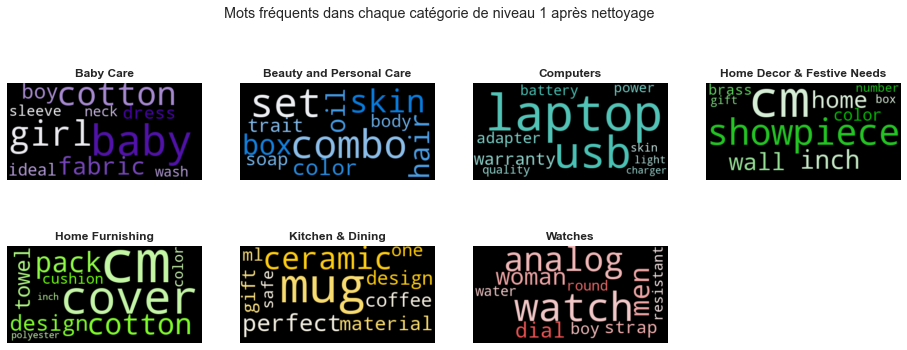

In [79]:
plot_wordclouds_by_categ(
    df_cleaned, feature='sentence_bow_lem', categ_col='categ_level_1')
plt.suptitle('Mots fréquents dans chaque catégorie de niveau 1 après nettoyage')
to_png()


## 3.5 Enregistre les données préparées


In [80]:
os_make_dir(OUT_FOLDER)
df_cleaned.to_csv(f'{OUT_FOLDER}/data_cleaned.csv',
                  encoding='UTF-8', index=False)


## 3.6 Nettoyage des variables globales


In [81]:
del df_data
del df_cleaned


---


# 4. Fonctions communes pour modèles NLP

- Lecture de données
- Scoring des modèles
- Visualisation de métriques de performance
- Visualisation des clusters


## 4.1 Lecture des données


In [82]:
data_T = pd.read_csv(f'{OUT_FOLDER}/data_cleaned.csv')
print(data_T.shape)


(1050, 20)


### 4.1.1 Variables pour comparer les catégories


In [83]:
# from sklearn.preprocessing import LabelEncoder
cat_encoder = preprocessing.LabelEncoder()

# list des catégories de niveau 1
list_categories = sorted(list(set(data_T['categ_level_1'])))

l_cat_num = cat_encoder.fit_transform(list_categories)

# map de catégories
cat_map = dict(zip(l_cat_num, list_categories))
print("catégories : ", cat_map)
cat_encoder.inverse_transform(l_cat_num)


y_cat_num = cat_encoder.transform(data_T['categ_level_1'])
# true catégorie
y_cat_txt = data_T['categ_level_1'].copy()


catégories :  {0: 'Baby Care', 1: 'Beauty and Personal Care', 2: 'Computers', 3: 'Home Decor & Festive Needs', 4: 'Home Furnishing', 5: 'Kitchen & Dining', 6: 'Watches'}


In [84]:
cat_encoder.inverse_transform([1, 0, 5, 6])


array(['Beauty and Personal Care', 'Baby Care', 'Kitchen & Dining',
       'Watches'], dtype='<U26')

## 4.2 Modélisation et évaluation des modèles :

- **Prétraitement** des données (choix de description, lemmatization, stopwords,...) - voir ci-dessus. On utilise 'feature' pour choisir la colonne des données prétraitées.

- **Extraction de features** (par Bag-of-Words, TF-IDF, Word2Vec etc)

- **Réduction de dimensions** (par t-SNE, PCA, NMF, truncatedSVD...)

- **Classification (clustering) non supervisée sur les dimensions réduites** (Gridsearch des hyperparamètres, sans ou avec choix de nombre de clusters)

  - par Kmeans (défaut)
  - par LDA (topic modelling)
  - par NMF (pas utilisé ici)

- **Evaluation de performance** :

  - distortion score (l'inertie ou somme d'erreurs carrés de chaque cluster)
  - score davies_bouldin (mesure de séparation des clusters)
  - score silhouette des clusters (+ visualisation des silhouettes de chaque cluster)
  - score stabilité des clusters (sur des sous-échantillons --> écart type)

- **Evaluation de correspondance avec les catégories définies**
  - ARI score
  - pourcentage des items mal classés
  - visualisation pour comparer les clusters sur les principaux dimensions réduits (TSNE ou PCA par exemple)
  - visualisation Sankey de correlations entre clusters


### 4.2.1 Scoring : performance d'un model

C'est compliqué à mettre en place un pipeline de preprocessing, feature extraction, dimension reduction, classification, scoring, car les librairies parfois retourne une matrice sparse, parfois pas.

Ci-dessous, ma procédure générique pour score d'un model

- on varie le paramètre k pour évaluer le nombre de clusters pour une meilleure performance

On peut facilement ajouter un param_grid et faire un GridSearch sur toutes les combinaisons des paramètres :

```python
    # generate parameter grid for classifier
    param_sets = ParameterGrid(param_grid)

    for params in param_sets:
        # print(f'score model for params = {params}')
        # set model parameters (usually just n_clusters for classifier)
        model.set_params(**params)
        model.fit...
```


In [85]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn import manifold # TSNE
# from sklearn import cluster # KMeans
# from sklearn import metrics
# import time
# import scipy
# from scipy.sparse import csr_matrix

param_grid = {'n_clusters': range(4, 11)}


def get_classname(estimator):
    return estimator.__class__.__name__


def score_model(df: pd.DataFrame,
                feature='sentence_bow_lem',
                labels_true=None,
                document_preprocessor=None,
                feature_extractor=TfidfVectorizer(
                    stop_words='english', min_df=3),
                dimension_reducer=manifold.TSNE(n_components=2, perplexity=30, n_iter=2000,
                                                init='pca', learning_rate=200, random_state=RANDOM_SEED),
                kmin=7, kmax=7):
    """Executer un traitement de données, extraire les features, réduire les dimensions, et faire du clustering
    Returns : scores, labels et matrice de 'reduced dimensions'
    Parameters
    ----------
    df:       Le dataframe qui contient les données
    feature   La colonne du dataframe qui contient les documents text à analyser
    document_preprocessor : (optionnel) un transformer capable de convertir les données (avec fit_transform api)
    feature_extractor: Extraire les features comme vectors à partir des documents
    dimension_reducer: Réduire le nombre de features
    kmin    min nombre de components (KMeans classification)
    kmax    max nombre de components (KMeans classification)

    Returns
    ----------
    un dataframe avec les scores de KMeans classification pour chaque fit de KMeans
    """

    # preprocess (normally done)
    if document_preprocessor is None:
        documents = df[feature]
    else:
        documents = document_preprocessor.fit_transform(df[feature])

    # extract features
    start_fit_extract = time.time()
    features = feature_extractor.fit_transform(documents)
    fit_time_extract = round(time.time()-start_fit_extract, 2)
    print(
        f'Extract_features ({get_classname(feature_extractor)}), fit time = {fit_time_extract} s')
    print(f'type(features) = {type(features)}')
    if isinstance(features, scipy.sparse.csr_matrix):
        print('converting features from sparse to dense array')
        # print(dir(features))
        features = features.toarray()

    print(f'features.shape ={features.shape}')
    # reduce dimensions
    start_fit_reduce = time.time()
    reduced_dimensions = dimension_reducer.fit_transform(features)
    fit_time_reduce = round(time.time()-start_fit_reduce, 2)
    print(
        f'Reduced dimensions [{reduced_dimensions.shape}] ({get_classname(dimension_reducer)}), fit time = {fit_time_reduce} s')

    df_scores = pd.DataFrame({})

    for k in range(kmin, kmax+1):
        clusterer = cluster.KMeans(n_clusters=k)

        #
        start_fit_clf = time.time()
        clusterer.fit(reduced_dimensions)
        fit_time_clf = round(time.time()-start_fit_clf, 2)
        # print(f'Clusterer fit time = {fit_time_clf} s')

        labels_pred = clusterer.labels_
        cluster_sizes = (pd.Series(labels_pred).value_counts(
            normalize=True).values*100).astype(int)

        min_cluster_pct = pd.Series(
            labels_pred).value_counts(normalize=True).min()
        res = {'k': k,
               'min_cluster_pct': round(min_cluster_pct*100, 2),
               'distortion_score': round(getattr(clusterer, 'inertia_', 0), 0),
               'davies_bouldin': round(metrics.davies_bouldin_score(reduced_dimensions, labels_pred), 2),
               'calinski_harabasz': round(metrics.calinski_harabasz_score(reduced_dimensions, labels_pred), 2),
               'silhouette_score': round(metrics.silhouette_score(reduced_dimensions, labels_pred), 3),
               'fit_time_cluster': fit_time_clf
               }

        # ARI ne fait pas partie de score d'un model non supervisée, car on ne fournit pas labels_true
        ARI = ''

        # Pour les modèles (semi) supervisées, on connais les 'vrai' labels,
        # c'est un bon moment à calculer la performance des previsions.
        if not labels_true is None:
            res['ARI'] = round(metrics.adjusted_rand_score(
                labels_true, labels_pred), 3)
            ARI = f" ARI = {res['ARI']},"
        print(
            f"k={k}, fit: {fit_time_clf} s, silhouette= {res['silhouette_score']:.3},{ARI} cluster sizes (%) = {cluster_sizes}")
        df_scores = df_scores.append(res, ignore_index=True)

    df_scores['feature_extraction'] = get_classname(feature_extractor)
    df_scores['dimension_reduction'] = get_classname(dimension_reducer)
    df_scores['classifier'] = get_classname(clusterer)
    df_scores['k'] = df_scores['k'].astype(int)

    if kmin == kmax:
        # utilise les derniers labels car ils sont aussi les premiers
        return df_scores, labels_pred, reduced_dimensions, k
    else:
        # fourni les labels du meilleur k (on peut plus inferer best_k = labels.nunique())
        best_score_idx = df_scores['silhouette_score'].idxmax()
        best_k = df_scores.loc[best_score_idx, 'k']
        clusterer = cluster.KMeans(n_clusters=best_k)
        clusterer.fit(reduced_dimensions)
        labels_pred = clusterer.labels_
        return df_scores, labels_pred, reduced_dimensions, best_k


scores, labels, red_dim, best_k = score_model(data_T, 'sentence_bow_lem',
                                              labels_true=data_T['categ_level_1'],
                                              kmin=4, kmax=12)
print(f'K for best silhouette: {best_k}')
scores


Extract_features (TfidfVectorizer), fit time = 0.11 s
type(features) = <class 'scipy.sparse.csr.csr_matrix'>
converting features from sparse to dense array
features.shape =(1050, 1382)
Reduced dimensions [(1050, 2)] (TSNE), fit time = 15.65 s
k=4, fit: 0.07 s, silhouette= 0.399, ARI = 0.38, cluster sizes (%) = [31 26 23 18]
k=5, fit: 0.16 s, silhouette= 0.411, ARI = 0.402, cluster sizes (%) = [25 24 22 14 12]
k=6, fit: 0.16 s, silhouette= 0.399, ARI = 0.447, cluster sizes (%) = [22 17 16 16 14 12]
k=7, fit: 0.18 s, silhouette= 0.405, ARI = 0.485, cluster sizes (%) = [19 17 14 14 11 11 10]
k=8, fit: 0.17 s, silhouette= 0.426, ARI = 0.525, cluster sizes (%) = [17 13 12 11 11 11 11  9]
k=9, fit: 0.25 s, silhouette= 0.432, ARI = 0.471, cluster sizes (%) = [16 13 11 10 10  9  9  9  8]
k=10, fit: 0.22 s, silhouette= 0.434, ARI = 0.479, cluster sizes (%) = [13 13 11 10 10  8  8  8  7  6]
k=11, fit: 0.2 s, silhouette= 0.439, ARI = 0.498, cluster sizes (%) = [13 13 10 10  8  8  8  8  7  6  3]
k

ARI  calinski_harabasz  davies_bouldin  distortion_score  fit_time_cluster  \
0 0.38             962.78            0.83       10260205.00              0.07   
1 0.40             990.61            0.80        8053755.00              0.16   
2 0.45            1033.54            0.79        6486149.00              0.16   
3 0.48            1054.52            0.81        5461639.00              0.18   
4 0.53            1130.24            0.76        4491193.00              0.17   
5 0.47            1184.89            0.75        3818784.00              0.25   
6 0.48            1194.37            0.72        3404519.00              0.22   
7 0.50            1201.37            0.70        3071996.00              0.20   
8 0.46            1211.45            0.72        2789242.00              0.20   

    k  min_cluster_pct  silhouette_score feature_extraction  \
0   4            18.10              0.40    TfidfVectorizer   
1   5            12.67              0.41    TfidfVectorizer   
2   6            12.95              0.40    TfidfVectorizer   
3   7            10.48              0.41    TfidfVectorizer   
4   8             9.81              0.43    TfidfVectorizer   
5   9             8.95              0.43    TfidfVectorizer   
6  10             6.76              0.43    TfidfVectorizer   
7  11             3.43              0.44    TfidfVectorizer   
8  12             3.43              0.43    TfidfVectorizer   

  dimension_reduction classifier  
0                TSNE     KMeans  
1                TSNE     KMeans  
2                TSNE     KMeans  
3                TSNE     KMeans  
4                TSNE     KMeans  
5                TSNE     KMeans  
6                TSNE     KMeans  
7                TSNE     KMeans  
8                TSNE     KMeans

## 4.3 Visualisations de métriques de performance

On s'inspire de yellowbrick KElbowVisualizer pour généraliser à d'autres métriques (stability par exemple)


In [86]:

def angle_between_vectors(v1, v2):
    """
    calculate angle between 2 vectors.
    use to find elbows
    """
    ang1 = np.arctan2(*v1[::-1])
    ang2 = np.arctan2(*v2[::-1])
    ang = np.rad2deg(abs(ang1 - ang2) % (2 * np.pi))
    if ang > 180:
        ang = ang-180
    return ang


print([
    angle_between_vectors([1, 1], [0, 0]),
    angle_between_vectors([1, 1], [0, 1]),
    angle_between_vectors([1, 1], [-1, 0]),
    angle_between_vectors([1, 1], [-1, -1]),
])


[45.0, 45.0, 135.0, 180.0]


In [87]:

def find_elbow(df: pd.DataFrame, x_col='k', y_col='distortion_score'):
    """find sharpest difference in angle for [k, score]"""
    df = df.copy().reset_index()
    # standardise scale to maximise angles between points

    x_scale = df[x_col].max()-df[x_col].min()
    y_min = df[y_col].min()
    y_mult = (df[y_col].max()-y_min)/x_scale
    df['y_scaled'] = (df[y_col]-y_min)/y_mult

    # calculate angles between consecutive points
    n = len(df)
    for i in range(0, n-2):
        point1 = df.loc[i, [x_col, 'y_scaled']]
        point2 = df.loc[i+1, [x_col, 'y_scaled']]
        point3 = df.loc[i+2, [x_col, 'y_scaled']]
        vec1 = point2-point1
        vec2 = point3-point2
        df.loc[i+1, 'angle'] = angle_between_vectors(vec1, vec2)
    # elbow is at highest difference in angle (assume monotonic function)
    row = df['angle'].idxmax()
    x_elbow = df.loc[row, x_col]
    y_score = df.loc[row, y_col]
    return x_elbow, y_score


In [88]:

k_best, distortion_score = find_elbow(scores, y_col='distortion_score')
print(f'Best score for k = {k_best}')
# check labels for best score have been returned
print(pd.Series(labels).nunique())


Best score for k = 9
11


### 4.3.1 Plot elbow visualiser


"Kmeans_Distortion_Score.png"


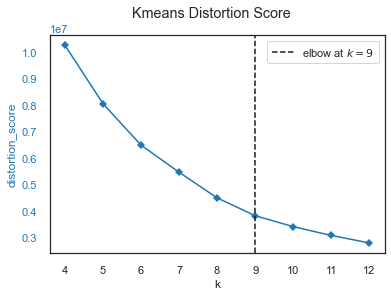

In [89]:

def plot_second_ax(df, x_col, y2_col, ax, color='grey'):
    """add a secondary y axis to a plot"""
    if y2_col in df.columns:
        ax2 = ax.twinx()
        ax2.plot(df[x_col], df[y2_col], label=y2_col,
                 c=color, marker='o', linestyle='--', alpha=0.75)
        ax2.tick_params(axis='y', colors=color)
        ax2.set_ylabel(y2_col, color=color)


def plot_elbow(df, x_col, y_col, ax):
    """draw a vertical line at elbow on a plot"""
    elbow_k, elbow_score = find_elbow(df, x_col, y_col)
    elbow_label = f'elbow at ${x_col}={elbow_k}$'
    ax.axvline(elbow_k, c='k', linestyle="--", label=elbow_label)
    ax.legend(frameon=True)


def plot_vline(df, x_col, y_col, ax, line_at='max'):
    """draw a vertical line at max or min value of y on a plot"""
    if line_at == 'max':
        row_idx = df[y_col].argmax()
    elif line_at == 'min':
        row_idx = df[y_col].argmin()
    line_x = df.loc[row_idx, x_col]
    line_label = f'{line_at} at ${x_col}={line_x}$'
    ax.axvline(line_x, c='k', linestyle="--", label=line_label)
    ax.legend(frameon=True)


def plot_elbow_visualiser(df: pd.DataFrame, x_col='k', score_col='distortion_score',
                          show_elbow=False, time_col=None, ax1=None):
    """
    Generic ElbowVisualiser, capable of showing any metric, elbows, secondary axis...
    Allows subsequent manipulation of plots
    """
    colors = sns.color_palette("tab20").as_hex()
    if ax1 is None:
        _, ax1 = plt.subplots()
    # scores
    ax1.plot(df[x_col], df[score_col],
             marker="D", c=colors[0], linestyle="-")
    ax1.grid(False)
    ax1.tick_params(axis='y', colors=colors[0])
    ax1.set_xlabel(x_col)
    ax1.set_ylabel(score_col, c=colors[0])
    # fit times
    if not time_col is None:
        plot_second_ax(df, x_col, y2_col=time_col, ax=ax1)
    if show_elbow:
        plot_elbow(df, x_col, score_col, ax1)


# Test visualiser
plot_elbow_visualiser(scores, score_col='distortion_score', show_elbow=True)
plt.suptitle(f'Kmeans Distortion Score')
to_png()


### 4.3.2 Plot summary metrics

- visualiser plusieurs métriques com subplots


In [90]:
print(sorted(list(scores.columns)))


['ARI', 'calinski_harabasz', 'classifier', 'davies_bouldin', 'dimension_reduction', 'distortion_score', 'feature_extraction', 'fit_time_cluster', 'k', 'min_cluster_pct', 'silhouette_score']


"Plot_metrics_(feature_extraction_-_TfidfVectorizer;___dimension_reduction_TSNE).png"


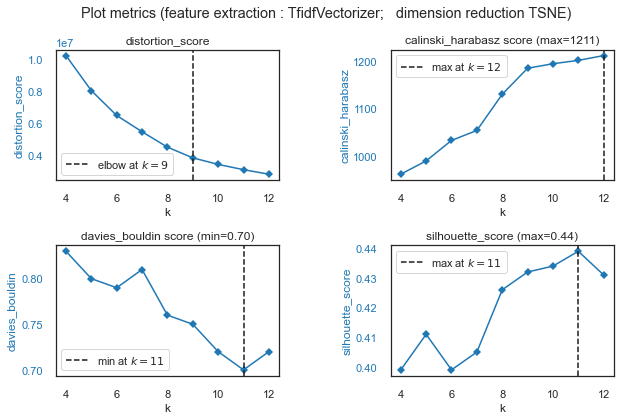

In [91]:

def plot_metrics(df_scores, x_col='k'):
    """
    Plot each clustering metric in df_scores in a subplot
    Plots to show depend on metrics added to df_scores
    Parameters
    ----------
    df_scores   Scores for all permutations of a param_grid (previously calculated)
    x_col       Choice of parameter to compare -by default k, but can show any hyperparameter
    """
    if 'clf' in df_scores.columns and 'preprocessor' in df_scores.columns:
        print(
            f"plotting metrics (clf: {df_scores['clf'][0]}, preprocessor: {df_scores['preprocessor'][0]})")

    METRICS = ['distortion_score', 'calinski_harabasz',
               'davies_bouldin', 'silhouette_score', 'stability_score']
    metrics = cols_in_df(df_scores, METRICS)
    n_plots = len(metrics)
    n_cols = min(n_plots, 2)
    # n_rows = int(ceil(n_plots/n_cols))
    n_rows = n_plots // n_cols + (n_plots % n_cols > 0)
    _ = plt.figure(figsize=(n_cols*5, n_rows*3))
    for n, metric in enumerate(metrics):
        ax = plt.subplot(n_rows, n_cols, n + 1)
        if metric == 'distortion_score':
            plot_elbow_visualiser(
                df_scores, x_col, metric, ax1=ax, time_col='fit time (s)', show_elbow=True)
            plt.title(metric)
        if metric == 'calinski_harabasz':
            plot_elbow_visualiser(df_scores, x_col, metric, ax1=ax)
            plot_vline(df_scores, x_col, metric, ax=ax, line_at='max')
            plt.title(f'{metric} score (max={df_scores[metric].max():.0f})')
        if metric == 'davies_bouldin':
            plot_elbow_visualiser(df_scores, x_col, metric, ax1=ax)
            plot_vline(df_scores, x_col, metric, ax=ax, line_at='min')
            plt.title(f'{metric} score (min={df_scores[metric].min():.2f})')
        if metric == 'silhouette_score':
            titre = f'{metric} (max={df_scores[metric].max():.2f})'
            if 'silhouette_score_std' in df_scores.columns:
                if 'silhouette_sample_sizes' in df_scores.columns:
                    sample_size = int(
                        df_scores['silhouette_sample_sizes'].max())
                    titre += f' 10 samples de {sample_size} pts'
                plt.errorbar(data=df_scores, x=x_col, y='silhouette_score',
                             yerr='silhouette_score_std')
            plot_elbow_visualiser(df_scores, x_col, metric,
                                  ax1=ax, time_col='silhouette_time')
            plot_vline(df_scores, x_col, metric, ax=ax, line_at='max')
            plt.title(titre)
        if metric == 'stability_score':
            titre = f'{metric} (max={df_scores[metric].max():.2f})'
            if 'stability_score_std' in df_scores.columns:
                if 'stability_sample_sizes' in df_scores.columns:
                    sample_size = int(
                        df_scores['stability_sample_sizes'].max())
                    titre += f' 10 samples de {sample_size} pts'
                plt.errorbar(data=df_scores, x=x_col, y='stability_score',
                             yerr='stability_score_std')
            plot_elbow_visualiser(df_scores, x_col, metric,
                                  ax1=ax, time_col='stability_time')
            plot_vline(df_scores, x_col, metric, ax=ax, line_at='max')
            plt.title(titre)

    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.suptitle(
        f"Plot metrics (feature extraction : {df_scores['feature_extraction'][0]};   dimension reduction {df_scores['dimension_reduction'][0]})")


# test
plot_metrics(scores)
to_png()


## 4.4 Visualisation des clusters sur les 'reduced_dimensions'


11


<AxesSubplot:>

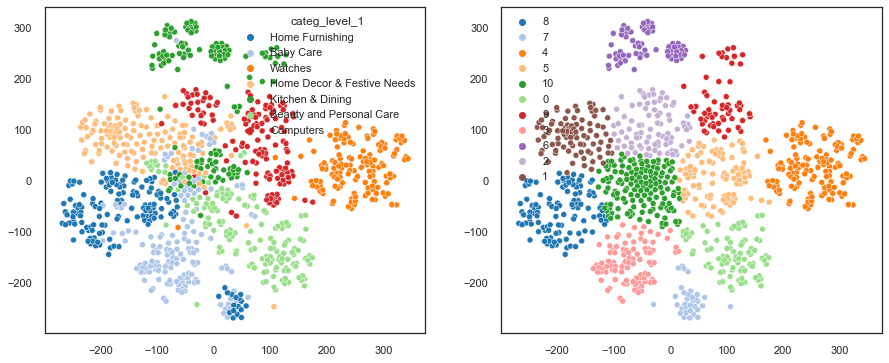

In [92]:
# scores, labels, red_dim = score_model(data_T)
print(pd.Series(labels).nunique())
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sns.scatterplot(
    ax=ax1, x=red_dim[:, 0], y=red_dim[:, 1], hue=pd.Series(y_cat_txt, dtype=str))
sns.scatterplot(
    ax=ax2, x=red_dim[:, 0], y=red_dim[:, 1], hue=pd.Series(labels, dtype=str))


## 4.4 Visualisation des clusters sur les 'reduced_dimensions'


### 4.4.1 Calcul de meilleure correspondance entre la catégorie et le "cluster label"

Les cluster labels attribué par des modélisations (ex. kmeans) sont aléatoires, que fait que des comparaisons entre la catégorie attribuée et les libellés sont difficil à comparer : ils n'auront pas les mêmes couleurs

On essaie de faire correspondre les cluster labels dans la même ordre que categ_true, pour faciliter :

- la matrice de confusion entre la catégorie et cluster
- la comparaison des clusters sur plots tsne/pca (couleurs plus proche)
- les diagrammes Sankey pour montre les relations

Références

- https://sparse-plex.readthedocs.io/en/latest/book/clustering/comparing_clusterings.html
- https://python.plainenglish.io/hungarian-algorithm-introduction-python-implementation-93e7c0890e15
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linear_sum_assignment.html

Comme alternative à KMeans (algorithme publié octobre 2021):

- https://www.researchgate.net/publication/353696146_The_utility_of_clusters_and_a_Hungarian_clustering_algorithm


## Créer la matrice de confusion

Quand la nombre de classes prédit sont identiques au nombre de "vraie" classes, la matrice de confusion est mieux calculé par l'algorithme Hungarian :

- Associer chaque vrai classe au cluster prédit la plus proche dans la diagonale, de façon à maximiser la correspondance entre classes vraies et classes prédit (le score ARI est calculé basé sur cette relation 1 à 1)


### Confusion Matrix - Approche 1 : Maximiser la correspondance entre vrai classe et cluster prédit


In [93]:
def squarify_df(df: pd.DataFrame, val=0):
    rows, cols = df.shape
    if rows > cols:
        # append columns to end of dataframe
        pad_cols = rows-cols
        pad_df = pd.DataFrame(
            np.zeros((rows, pad_cols), dtype=int), index=df.index)
        pad_df.columns = [f'pad_{i}'for i in range(pad_cols)]
        df = df.join(pad_df)
    elif cols > rows:
        # append rows to end of dataframe
        pad_rows = cols-rows
        pad_df = pd.DataFrame(data=np.zeros((cols-rows, cols), dtype=int),
                              columns=range(cols))
        pad_df.index = [f'pad_{i}'for i in range(pad_rows)]
        df = df.append(pad_df)
    return df


df_test_rows = pd.DataFrame([[1, 0, 6], [0, 3, 3]])
df_test_cols = df_test_rows.T
print(df_test_rows.shape)
print(squarify_df(df_test_rows))
print(squarify_df(df_test_cols))


(2, 3)
       0  1  2
0      1  0  6
1      0  3  3
pad_0  0  0  0
   0  1  pad_0
0  1  0      0
1  0  3      0
2  6  3      0


In [94]:
def confusion_matrix_crosstab(y_true, y_pred, normalize=False) -> pd.DataFrame:
    """
    Create confusion matrix as dataframe for string or numeric labels
    - Replacement for sklearn.metrics.confusion_metric
    which does not accept mixed types and returns numpy array
    """
    if not isinstance(y_true, pd.Series):
        y_true = pd.Series(np.array(y_true), name='y_true')

    if not isinstance(y_pred, pd.Series):
        y_pred = pd.Series(np.array(y_pred), name='y_pred')

    if isinstance(y_pred, pd.Series):
        # si les deux sont des series, pd.crosstab utilise leurs indices pour faire le crosstab
        y_pred = y_pred.copy()
        y_pred.index = y_true.index

    # créer le matrice de confusion entre la catégorie et cluster label
    return pd.crosstab(y_true, y_pred, normalize=normalize)


In [95]:
def conf_matrix_labels(categ_true: pd.Series, clust_labels: pd.Series, normalize=False):
    """
    Calcul de meilleure correspondance entre true_categorie et predicted categorie par optimisation de la diagonale
    (Approche 1 : optimiser la diagonale de la matrice de confusion)

    Les cluster labels attribué par kmeans sont aléatoires
    On essaie de mettre les cluster labels dans la même ordre que categ_true,
    pour faciliter :
        - la matrice de confusion entre catégorie et cluster
        - la comparaison des clusters sur plots tsne/pca (couleurs plus proche)
        - les diagrammes Sankey pour montre les relations
    """
    df_matr = confusion_matrix_crosstab(
        categ_true, clust_labels, normalize=normalize)

    # L'algorithme a besoin d'une matrice carré
    n_categ = df_matr.shape[0]
    n_labels = df_matr.shape[1]

    square_matr = squarify_df(df_matr).fillna(0)

    # trouve ordre de colonnes et lignes pour maximiser valeurs dans la diagonale
    rows, cols = scipy.optimize.linear_sum_assignment(
        square_matr.values, maximize=True)

    # Supprimer les lignes/colonnes vides après optimisation de la diagonale
    if len(rows) > n_categ:
        rows = [idx for idx in rows if idx < n_categ]
    if len(cols) > n_labels:
        cols = [idx for idx in cols if idx < n_labels]
    # print(f'len(rows) : {len(rows)}')
    # print(f'len(cols) : {len(cols)}')

    df_opt = df_matr.iloc[:, cols]

    if normalize == False:
        df_opt = df_opt.round(0).astype(int)

    return df_opt


# test
y_true = ['a', 'a', 'a', 'a', 'a', 'b', 'b',
          'b', 'b', 'b', 'c', 'c', 'c', 'c', 'c']
y_pred = [0, 3, 4, 1, 0, 4, 3, 4, 2, 4, 2, 1, 3, 1, 3]

conf_matrix_labels(y_true, y_pred).style.background_gradient(axis=1)


### Affichage de la matrice de confusion


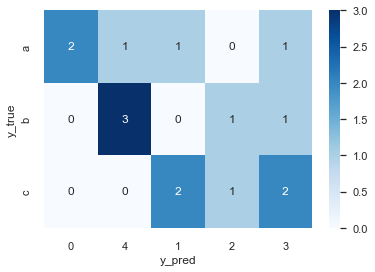

In [96]:
Serie = list or np.ndarray or pd.Series


def plot_confusion_matrix_heatmap(y_true: Serie, y_pred: Serie, cmap='Blues', figsize=(6, 4)):
    """
    plot confusion matrix as heatmap

    Parameters
    ----------
    y_true : labels (number or string list, 1-d array or series)
    y_pred : labels (number or string list, 1-d array or series)
    cmap: colors
    figsize: figure size
    """
    df_cm = conf_matrix_labels(y_true, y_pred)
    plt.figure(figsize=figsize),
    sns.heatmap(df_cm, annot=True, cmap=cmap, fmt='.0f')


# test
# test
y_true = ['a', 'a', 'a', 'a', 'a', 'b', 'b',
          'b', 'b', 'b', 'c', 'c', 'c', 'c', 'c']
y_pred = [0, 3, 4, 1, 0, 4, 3, 4, 2, 4, 2, 1, 3, 1, 3]
plot_confusion_matrix_heatmap(y_true, y_pred)


### Confusion matrix - approche 2 : Associé chaque cluster prédit à un des vraies classes

Quand la nombre de classes prédit n'est pas identique au nombre de "vraie" classes, on peut présenter la matrice de confusion entre labels true et labels prédits de 2 manières :

- Associer chaque vraie classes au cluster prédit la plus proche dans la diagonale (Approche 1 - "Hungarian clustering algorithm"). Les autres clusters moins proches aux vraies classes sont considérés comme des "nouvelles" classes - on les ignore pour le calcul de la matrice de confusion.

- Associer chaque classe prédite au vrai classe la plus proche (approche 2)
  - il se peut que plusieurs classes prédites sont associés a une vraie classe (on les traite comme étant un seul cluster pour le calcul de la matrice de confusion),
  - Il peut avoir des vraies classes sans aucun cluster associé.

Ci-dessous, les fonctions pour approche 2


In [97]:
# from sklearn import metrics
# Serie=list or np.ndarray or pd.Series

def conf_mat_transform(y_true: Serie, y_pred: Serie) -> pd.Series:
    """
    Associate each y_pred label to closest match of y_true label.
    The returned transformed y_pred series will be labelled numerically,
    corresponding to the index in the sorted set of unique y_true labels
    each y_true label may have 0 to many associated y_pred labels
    Parameters
    ----------
    y_true : labels (number or string list, 1-d array or series)
    y_pred : labels (number or string list, 1-d array or series)
    """
    conf_mat = confusion_matrix_crosstab(y_true, y_pred, False).values
    y_predi = preprocessing.LabelEncoder().fit_transform(y_pred)
    corresp = np.argmax(conf_mat, axis=0).astype(int)
    print("Correspondance des clusters : ", corresp)
    # erreur if nb(pred) < nb(true)
    # y_pred_transform = np.apply_along_axis((lambda x: corresp[x]), 0, y_pred)

    # conf_mat_cols=list(conf_mat.columns)
    # conf_mat_ind=list(conf_mat.index)
    # corresp_str = [conf_mat_ind[i] for i in corresp]
    # label_map = dict(zip(conf_mat_cols,corresp_str))
    # y_pred_transform = pd.Series(y_pred).map(label_map).values
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_predi
    y_pred_transform = labels['y_pred'].apply(lambda x: corresp[x])

    if isinstance(y_pred, pd.Series):
        y_pred_transform = pd.Series(
            y_pred_transform, name=f'{y_pred.name} (transformed)')
    return y_pred_transform


# def conf_mat_transform(y_true, y_pred):
#     """attribuer chaque cluster de y_pred à un des groupes de y_true"""
#     conf_mat = metrics.confusion_matrix(y_true, y_pred)

#     corresp = np.argmax(conf_mat, axis=0)
#     # corresp = [3, 1, 2, 0]
#     print("Correspondance des clusters : ", corresp)
#     # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
#     labels = pd.Series(y_true, name="y_true").to_frame()
#     labels['y_pred'] = y_pred
#     labels['y_pred_transform'] = labels['y_pred'].apply(lambda x: corresp[x])

#     return labels['y_pred_transform']


# test
# besoin de new_labels pour classification_report
new_labels = conf_mat_transform(y_true, y_pred)
pd.DataFrame({'new_label': new_labels, 'y_pred': y_pred}
             ).value_counts().sort_index().head()


Correspondance des clusters :  [0 2 1 2 1]


new_label  y_pred
0          0         2
1          2         2
           4         4
2          1         3
           3         4
dtype: int64

### Affichage du rapport de classification


In [98]:
# from sklearn.preprocessing import LabelEncoder
# Serie=list or np.ndarray or pd.Series

def print_classification_report(y_true: Serie, y_pred: Serie, target_names=None):
    """
    Affiche la classification report, sans besoin d'encoder les labels string en numérique
    """
    y_true_unique = sorted(list(set(y_true)))
    if target_names is None:
        target_names = [str(label) for label in y_true_unique]

    is_str_y_true = np.sum([isinstance(label, str)
                           for label in y_true_unique]) > 0
    is_str_y_pred = np.sum([isinstance(label, str)
                           for label in set(y_pred)]) > 0
    mixed_types = (is_str_y_true and not is_str_y_pred) or (
        is_str_y_pred and not is_str_y_pred)
    if mixed_types:
        # classification report requires y_true and y_pred numeric
        y_encoder = preprocessing.LabelEncoder()
        y_true_num = y_encoder.fit_transform(y_true)
        print(metrics.classification_report(y_true_num, y_pred,
              target_names=target_names, zero_division=0))
    else:
        print(metrics.classification_report(y_true, y_pred,
              target_names=target_names, zero_division=0))

# test
# print_classification_report(y_true_num,y_pred)
# print_classification_report(y_true_num,new_labels)
# print_classification_report(y_true,new_labels)
# print_classification_report(y_true,y_pred)


### Affichage des métriques de classification

Pour comparer les modèles, on standardise la presentation des métriques

- Score ARI
- Precision et Recall (Classification Report)
- Matrix de Confusion


combining clusters 3 <  5
[0, 1, 2, 3, 4]
Correspondance des clusters :  [0 2 1 2 1]
ARI = 0.149
              precision    recall  f1-score   support

           a       1.00      0.40      0.57         5
           b       0.67      0.80      0.73         5
           c       0.57      0.80      0.67         5

    accuracy                           0.67        15
   macro avg       0.75      0.67      0.66        15
weighted avg       0.75      0.67      0.66        15

"test_confusion_matrix.png"


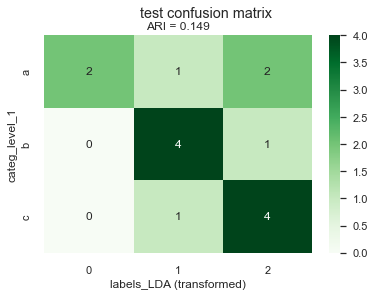

In [99]:
def calc_ARI(labels_true, labels_pred):
    """Calcul l'Adjusted Rand Index score"""
    return np.round(metrics.adjusted_rand_score(labels_true, labels_pred), 4)


def plot_classification_metrics(y_tru_, y_predi_, cmap='Blues', combine=False, target_names=None):
    """
    Plot l'ensemble de classification metrics : score ARI, classification report et confusion matrix
    parameters
    """
    y_true_ = y_tru_.copy()
    y_true_unique = list(set(y_true_))
    y_pred_unique = list(set(y_predi_))
    if (len(y_true_unique) < len(y_pred_unique)) or combine:
        # le nombre de clusters y_true et y_pred est different
        # on associe chaque cluster au vrai label la plus proche
        # certain y_true risque d'avoir aucun y_pred associé
        print(
            f'combining clusters {len(y_true_unique)} <  {len(y_pred_unique)}')
        print(y_pred_unique)
        y_pred1_ = conf_mat_transform(y_true_, y_predi_)
    else:
        # TODO empêcher de fusionner les clusters, mais
        y_pred1_ = conf_mat_transform(y_true_, y_predi_)
    ari = calc_ARI(y_true_, y_pred1_)
    print(f'ARI = {ari:.3f}')
    print_classification_report(y_true_, y_pred1_, target_names=target_names)
    plot_confusion_matrix_heatmap(y_true_, y_pred1_, cmap=cmap)
    return ari


# test
y_true2 = pd.Series(y_true, name='categ_level_1')
y_pred2 = pd.Series(y_pred, name='labels_LDA')
ari = plot_classification_metrics(y_true2, y_pred2, cmap='Greens')
plt.suptitle('test confusion matrix')
plt.title(f'ARI = {ari:.3f}')
to_png()


15 15
Correspondance des clusters :  [0 1 2 0]
ARI = 0.118
              precision    recall  f1-score   support

           a       0.43      1.00      0.60         3
           b       0.50      0.67      0.57         3
           c       0.50      0.67      0.57         3
           d       0.00      0.00      0.00         3
           e       0.00      0.00      0.00         3

    accuracy                           0.47        15
   macro avg       0.29      0.47      0.35        15
weighted avg       0.29      0.47      0.35        15



0.1185

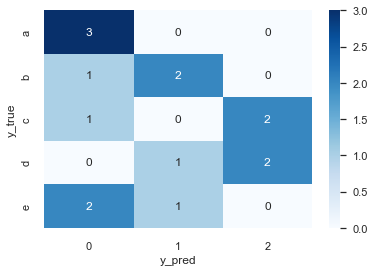

In [100]:
# test
y_true1 = ['a', 'a', 'a', 'b', 'b', 'b', 'c',
           'c', 'c', 'd', 'd', 'd', 'e', 'e', 'e']
y_pred1 = [0, 3, 3, 1, 0, 1, 3, 2, 2, 2, 2, 1, 3, 1, 3]
print(len(y_true1), len(y_pred1))
plot_classification_metrics(y_true1, y_pred1, cmap='Blues', combine=False)


### Visualisation de confusion matrix comme une diagramme Sankey


In [101]:
# import plotly.graph_objects as go
# import plotly.io as pio


def add_alpha(color, alpha):
    (r, g, b) = color
    return f'rgba({r},{g},{b},{alpha})'


def plot_sankey_confusion_diagram(source: pd.Series, target: pd.Series = None,
                                  titre='Sankey confusion diagram',
                                  descriptors=['categories', 'clusters'],
                                  figsize=(2, 1), font_size=14,
                                  to_image=True,
                                  palette='nipy_spectral', alpha=0.5):
    """
    Plot confusion matrix as a Sankey diagram
    Accepts data in form of :
    - two series / lists (series names used as descriptors)
    - confusion matrix as a pandas dataframe (axes names used as descriptors)
    - confusion matrix as a numpy array (use parameter descriptors for source and target)

    Requires plotly,kaleido
    """
    # on peut fournir deux series (y_true, y_pred),
    if isinstance(source, pd.DataFrame) or len(source) < 10:
        ct = source.copy()
        if isinstance(ct, np.ndarray):
            print('ct is numpy array')
            ct = pd.DataFrame(ct)
            ct = ct.rename_axis(descriptors[0], axis=0)
            ct = ct.rename_axis(descriptors[1], axis=1)
    else:
        if isinstance(source, np.ndarray):
            source = pd.Series(source, name=descriptors[0])
        if isinstance(target, np.ndarray):
            target = pd.Series(target, name=descriptors[1])
        ct = pd.crosstab(source, target)

    source_col = ct.index.name if ct.index.name else descriptors[0]
    target_col = ct.T.index.name if ct.T.index.name else descriptors[1]
    print(source_col, target_col)

    ct.index = ct.index.astype(str)
    ct.columns = ct.columns.astype(str)

    # replace source and target labels with unique node_ids
    node_labels = list(ct.index)+list(ct.columns)
    node_ids = range(len(node_labels))
    label_map = dict(zip(node_ids, node_labels))

    # create colors for unique nodes (nodes with same name have same color)
    # uniq_nodes = sorted(list(set(node_labels)))
    uniq_nodes = []
    for node in node_labels:
        if not node in uniq_nodes:
            uniq_nodes.append(node)
    colors = sns.color_palette(palette, n_colors=len(uniq_nodes))
    solid_color_map = dict(zip(uniq_nodes, colors.as_hex()))
    node_colors = list(pd.Series(node_labels).map(solid_color_map))

    # create semi-transparent colors for links (link color same as source node)
    alpha_colors = list([add_alpha(color, alpha) for color in colors])
    alpha_color_map = dict(zip(uniq_nodes, alpha_colors))

    # map (possibly duplicate) node_labels to unique node_ids

    ct.index = node_ids[:len(ct.index)]
    ct.index.name = source_col
    ct.columns = node_ids[-len(ct.columns):]

    # create [source,target,value,color] matrix for links
    data = pd.melt(ct.reset_index(), id_vars=source_col)
    print(data.shape)
    print(data.columns)
    data.columns = [source_col, target_col, 'value']
    data = data[data['value'] > 0]
    data['src_color'] = data[source_col].map(label_map).map(alpha_color_map)

    # send data to plotly figure
    fig = go.Figure(data=[
        go.Sankey(node=dict(label=node_labels, color=node_colors),
                  link=dict(source=data[source_col], target=data[target_col],
                    value=data['value'], color=data['src_color'])
                  )
    ])

    titre = f'{titre} : {source_col} vs. {target_col}'
    fig.update_layout(title_text=titre, title_x=0.5, font_size=font_size)

    if to_image:
        # requires package 'kaleido'
        w, h = figsize
        fig_name = sanitize(titre)
        filename = f'{IMAGE_FOLDER}/{fig_name}.png'
        pio.write_image(fig, file=filename, format="png")
        # pio.write_image(fig, file=filename, format="png", width=w*300, height=h*300, scale=1)
        img = fig.to_image(format="png", width=w, height=h, scale=1)
        return IPython.display.Image(img)
    else:
        fig.show()


### 4.4.2 Clustering KMeans via TSNE, et calcul de metric ARI

Une fois les scores sont calculés, les procédures ci-dessous permet de visualiser


In [102]:
# from sklearn import decomposition
def reducer_pca(features: pd.Series, n_components=0.99) -> np.ndarray:
    """Reduction de dimensions pour rester avec [99%] de la variance expliquée"""
    print(f'Dimensions avant réduction PCA : { features.shape}')
    pca = decomposition.PCA(n_components=n_components)
    if n_components >= 1:
        param_str = f'(n_components = {n_components})'
    else:
        param_str = f'({n_components*100:.0f} % variance explained)'
    feat_pca = pca.fit_transform(features)
    print(f'Dimensions après réduction PCA {param_str} : {feat_pca.shape}')
    return feat_pca


In [103]:
# from sklearn import manifold
# import time


def reducer_tsne(features: pd.Series) -> np.ndarray:
    """
    reduction de dimensions par t-SNE
    Parameters
    ---------
    features  numpy array, pd.Series or pd.DataFrame of shape[m,n]

    Returns
    ---------
    numpy array of shape[m,2]
    """
    print(f'reducer t-SNE, input shape={features.shape}')
    time1 = time.time()
    tsne_model = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000,
                               init='random', learning_rate=200, random_state=RANDOM_SEED)
    X_tsne = tsne_model.fit_transform(features)
    time2 = np.round(time.time() - time1, 0)
    print(f'reducer t-SNE, shape ={X_tsne.shape} time : {time2}')
    return X_tsne


In [104]:
# from sklearn import cluster, metrics
# import time

def calc_ARI(labels_pred, labels_true=y_cat_num):
    """Calcul l'Adjusted Rand Index score"""
    if len(labels_pred) == len(labels_true):
        return np.round(metrics.adjusted_rand_score(labels_true, labels_pred), 4)
    else:
        return -1


def calc_tsne_cluster(features, categories_=list_categories, y_cat_num_=y_cat_num, k=None):
    """
    Calcul Tsne, détermination des clusters et calcul ARI
    entre vraies catégories et n° de clusters
    """
    X_tsne = reducer_tsne(features)

    if k is None or not k > 0:
        k = len(categories_)

    time1 = time.time()
    # Détermination des clusters à partir des données après Tsne
    cls = cluster.KMeans(n_clusters=k, n_init=100,
                         random_state=RANDOM_SEED)
    cls.fit(X_tsne)
    time2 = np.round(time.time() - time1, 0)
    if len(y_cat_num_) == len(cls.labels_):
        ARI = np.round(metrics.adjusted_rand_score(y_cat_num_, cls.labels_), 4)
    else:
        ARI = -1

    print("ARI : ", ARI, "time : ", time2)
    # ajout cls.cluster_centers_ ?
    return ARI, X_tsne, cls.labels_


### 4.2.2 Visualisation des clusters sur les dimensions réduits


In [105]:

#
def plot_clusters_sur_2D(X_tsne_, y_cat_num_, labels_, ARI_, l_cat_=list_categories,
                         bbox_left=-0.05, loc=1,
                         palette='bright',
                         titre1='Représentation des produits par catégories réelles',
                         titre2='Représentation des produits par clusters'):
    """
    Visualisation du Tsne selon les vraies catégories et selon les clusters
    """
    if ARI_ is None:
        ARI_ = calc_ARI(y_cat_num_, labels_)
    if len(y_cat_num_) == len(labels_):
        df_opt = conf_matrix_labels(y_cat_num_, labels_)
        # mettre l'ordre des clusters dans la même ordre que les y_cat
        labels_hue_order = list(df_opt.columns)
        n_labels = len(labels_hue_order)
    else:
        labels_hue_order = None
        n_labels = pd.Series(np.array(labels_)).nunique()
    s_labels = pd.Series(labels_)

    categ_hue_order = sorted(list(pd.Series(y_cat_num_).unique()))
    n_categ = len(categ_hue_order)

    n_max = max(n_labels, n_categ)
    colors = sns.color_palette(palette, n_colors=n_max)
    # print (colors)
    labels_palette = colors[:n_labels]
    categ_palette = colors[:n_categ]
    fig = plt.figure(figsize=(15, 6))

    ax1 = fig.add_subplot(121)
    scatter1 = sns.scatterplot(x=X_tsne_[:, 0], y=X_tsne_[:, 1], ax=ax1,
                               hue=y_cat_num_, hue_order=categ_hue_order, palette=categ_palette)
    ax1.legend(title="Catégorie", bbox_to_anchor=(bbox_left, 0.5), loc=loc)
    plt.title(titre1)

    ax2 = fig.add_subplot(122)
    scatter2 = sns.scatterplot(x=X_tsne_[:, 0], y=X_tsne_[:, 1], ax=ax2,
                               hue=s_labels, hue_order=labels_hue_order, palette=labels_palette)
    ax2.legend(loc="best", title="Clusters")
    plt.title(titre2)
    print("ARI : ", ARI_)
    return fig


## 4.5 Accumulation des performances des modèles


In [106]:
df_resultats = pd.DataFrame()


def add_model_score(df: pd.DataFrame = None, model_name: str = 'none', ARI: float = 0, k: int = 0, **kwargs):
    global df_resultats
    if df is None:
        df = df_resultats
    """ajout les resultats d'un model """
    resultats = dict(model=model_name, ARI=ARI, k=k)
    resultats = dict(**resultats, **kwargs)
    df = df.append(resultats, ignore_index=True)
    df['k'] = df['k'].astype(int)
    return df


# test
add_model_score(pd.DataFrame(), optimizer='adam', k=7)


ARI  k model optimizer
0 0.00  7  none      adam

# 5. Bag-of-Words et TF-IDF


## 5.1 Essaie 1 : Bag of words (BOW)


### Création du bag of words (CountVectorizer)

On veut trouver des mots caractéristiques de chaque groupe


In [107]:
# from sklearn.feature_extraction.text import CountVectorizer

# mots present dans un minimum de 3 produits
cvect = CountVectorizer(stop_words='english', min_df=3)

# On applique à la sentence crée à partir de bag-of-words avec lemmatization
feature = 'sentence_bow_lem'
# cv_fit = cvect.fit(data_T[feature])

cv_transform = cvect.fit_transform(data_T[feature])
print(cv_transform.shape)


(1050, 1382)


la matrice `cv_transform` représent le bag-of-words crée par CountVectorizer:


In [108]:
def show_example_bow():
    print(data_T[feature][40])
    print(data_T[feature][42])
    print(data_T[feature][43])

    df_bow = pd.DataFrame.sparse.from_spmatrix(
        cv_transform,
        columns=cvect.get_feature_names_out(),
        index=data_T.index)
    df_bow = df_bow.join(data_T[['product_name']])
    print('Portion du bag-of-words - vectors')
    return df_bow.loc[40:43, ['boy', 'baby', 'girl', 'grey', 'blue', 'pyjama', 'cotton', 'hair', 'product_name']]


show_example_bow()


key mom kid baby girl printed green top pyjama set fabric cotton brand color greenmom kid baby girl printed green top pyjama set girl pyjama setspecifications mom kid baby girl printed green top pyjama set pattern printed ideal baby girl night suit fabric cotton top pyjama set neck round neck box top pyjama set
key mom kid baby girl printed blue grey top pyjama set fabric cotton brand color blue greymom kid baby girl printed blue grey top pyjama set girl pyjamasetspecifications mom kid baby girl printed blue grey top pyjama set pattern printed ideal baby girl night suit number content pack fabric cotton top pyjama set neck round nack box top pyjama set
key burt bee hair repair shea grapefruit deep conditioner ideal boy girl applied deep conditioning hair condition damaged hair hair dry hairspecifications burt bee hair repair shea grapefruit deep conditioner ml conditioner trait hair condition damaged hair hair dry hair applied deep conditioning ideal boy girl trait brand burt bee quant

boy  baby  girl  grey  blue  pyjama  cotton  hair  \
40    0     4     5     0     0       6       2     0   
41    0     0     0     2     0       0       1     0   
42    0     4     5     3     4       5       2     0   
43    2     0     2     0     0       0       0    10   

                                                    product_name  
40        Mom and Kid Baby Girl's Printed Green Top & Pyjama Set  
41                                Kripa's Printed Cushions Cover  
42   Mom and Kid Baby Girl's Printed Blue, Grey Top & Pyjama Set  
43  Burt s Bees Hair Repair Shea And Grapefruit Deep Conditioner

### Calcul des clusters et affichage


### Uni-grammes

- définir `ngram_range=(1,1)`


Extract_features (CountVectorizer), fit time = 0.08 s
type(features) = <class 'scipy.sparse.csr.csr_matrix'>
converting features from sparse to dense array
features.shape =(1050, 1449)
Reduced dimensions [(1050, 2)] (TSNE), fit time = 14.27 s
k=4, fit: 0.07 s, silhouette= 0.421, ARI = 0.337, cluster sizes (%) = [35 25 24 14]
k=5, fit: 0.11 s, silhouette= 0.454, ARI = 0.361, cluster sizes (%) = [28 25 19 14 12]
k=6, fit: 0.25 s, silhouette= 0.466, ARI = 0.438, cluster sizes (%) = [27 17 15 15 14  9]
k=7, fit: 0.19 s, silhouette= 0.475, ARI = 0.46, cluster sizes (%) = [20 15 14 14 13 12  9]
k=8, fit: 0.16 s, silhouette= 0.466, ARI = 0.459, cluster sizes (%) = [16 14 13 13 13 11 10  7]
k=9, fit: 0.15 s, silhouette= 0.467, ARI = 0.467, cluster sizes (%) = [14 14 13 12 10 10  9  7  7]
k=10, fit: 0.18 s, silhouette= 0.474, ARI = 0.451, cluster sizes (%) = [14 13 12 11  9  9  7  7  7  6]
k=11, fit: 0.33 s, silhouette= 0.485, ARI = 0.428, cluster sizes (%) = [14 14 12 12  9  9  7  7  6  5  2]


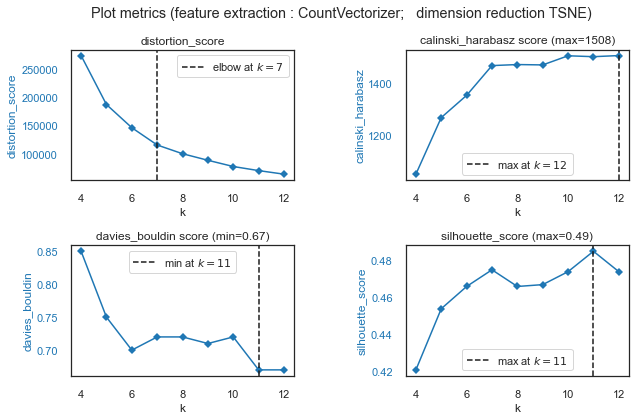

In [109]:
unigram_count_vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=3)
tsne_reducer = manifold.TSNE(n_components=2, perplexity=30,
                             n_iter=2000, init='random', learning_rate=200)

scores1a, labels1a, X_tsne1a, k1a = score_model(data_T, labels_true=y_cat_txt,
                                                feature_extractor=unigram_count_vectorizer,
                                                dimension_reducer=tsne_reducer,
                                                kmin=4, kmax=12)
ARI1a = calc_ARI(y_cat_txt, labels1a)
# add to global scores
df_resultats = add_model_score(
    model_name='BOW (unigrams) + TSNE', ARI=ARI1a, k=k1a)
plot_metrics(scores1a)


In [110]:
# répéter pour k=7 pour retourner les labels pour k=7
scores1a, labels1a, X_tsne1a, k1a = score_model(data_T, labels_true=y_cat_txt,
                                                feature_extractor=unigram_count_vectorizer,
                                                dimension_reducer=tsne_reducer,
                                                kmin=7, kmax=7)

ARI1a = calc_ARI(y_cat_txt, labels1a)
# add to global scores
df_resultats = add_model_score(
    model_name='BOW (unigrams) + TSNE', ARI=ARI1a, k=k1a)


Extract_features (CountVectorizer), fit time = 0.06 s
type(features) = <class 'scipy.sparse.csr.csr_matrix'>
converting features from sparse to dense array
features.shape =(1050, 1449)
Reduced dimensions [(1050, 2)] (TSNE), fit time = 14.08 s
k=7, fit: 0.09 s, silhouette= 0.475, ARI = 0.428, cluster sizes (%) = [22 15 15 14 13 12  7]


Correspondance des clusters :  [6 1 3 2 0 4 5]
ARI = 0.428
              precision    recall  f1-score   support

           0       0.73      0.65      0.69       150
           1       0.68      0.73      0.70       150
           2       0.60      0.56      0.58       150
           3       0.69      0.73      0.71       150
           4       0.35      0.55      0.43       150
           5       0.97      0.49      0.65       150
           6       1.00      0.99      1.00       150

    accuracy                           0.67      1050
   macro avg       0.72      0.67      0.68      1050
weighted avg       0.72      0.67      0.68      1050

"BOW_(unigrams)_+_TSNE_-_confusion_matrix_(ARI=0-428).png"


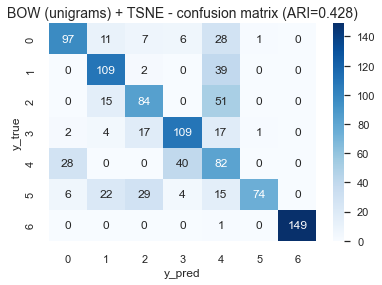

In [111]:
ari_1a = plot_classification_metrics(y_cat_num, labels1a)
plt.title(
    f'BOW (unigrams) + TSNE - confusion matrix (ARI={ari_1a:.3f})', fontsize=14)
to_png()


ARI :  0.428
"Visualisation_des_clusters_(feature_extraction-_Bag-Of-Words(unigrams);_dimension_reduction-_TSNE,_ARI_=_0-428.png"


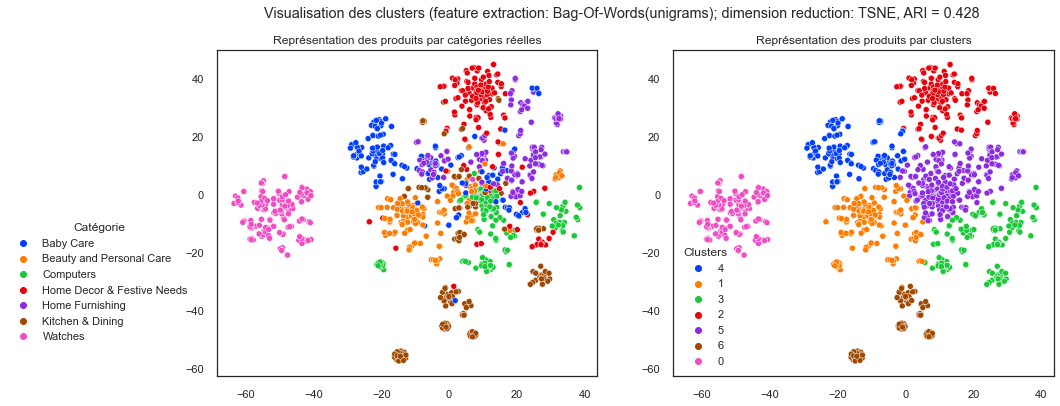

In [112]:

fig = plot_clusters_sur_2D(
    X_tsne1a, y_cat_txt, labels1a, ARI1a, palette='bright')
plt.suptitle(
    f"Visualisation des clusters (feature extraction: Bag-Of-Words(unigrams); dimension reduction: TSNE, ARI = {ARI1a:.3f}")
to_png()


### Bag-of-Words avec reduction de dimensions via PCA

`PCA(n_components=0.99)` - conduire PCA et retenir seulement les composants qui explique 99% de la variance

- on élimine les mots qui sont rares ou très associés entre eux.


Extract_features (CountVectorizer), fit time = 0.06 s
type(features) = <class 'scipy.sparse.csr.csr_matrix'>
converting features from sparse to dense array
features.shape =(1050, 1449)
Reduced dimensions [(1050, 411)] (PCA), fit time = 0.65 s
k=4, fit: 0.1 s, silhouette= 0.264, ARI = 0.008, cluster sizes (%) = [94  2  2  0]
k=5, fit: 0.17 s, silhouette= 0.427, ARI = 0.011, cluster sizes (%) = [91  6  0  0  0]
k=6, fit: 0.17 s, silhouette= 0.391, ARI = 0.009, cluster sizes (%) = [86  8  2  1  0  0]
k=7, fit: 0.21 s, silhouette= -0.036, ARI = 0.144, cluster sizes (%) = [72 14  8  1  1  1  0]
k=8, fit: 0.2 s, silhouette= 0.007, ARI = 0.127, cluster sizes (%) = [69 14  8  2  1  1  1  1]
k=9, fit: 0.21 s, silhouette= 0.013, ARI = 0.161, cluster sizes (%) = [63 14  7  7  2  2  1  0  0]
k=10, fit: 0.22 s, silhouette= 0.274, ARI = 0.034, cluster sizes (%) = [79  7  6  1  1  1  1  0  0  0]
k=11, fit: 0.25 s, silhouette= 0.292, ARI = 0.039, cluster sizes (%) = [76  7  7  2  1  1  1  0  0  0  0]


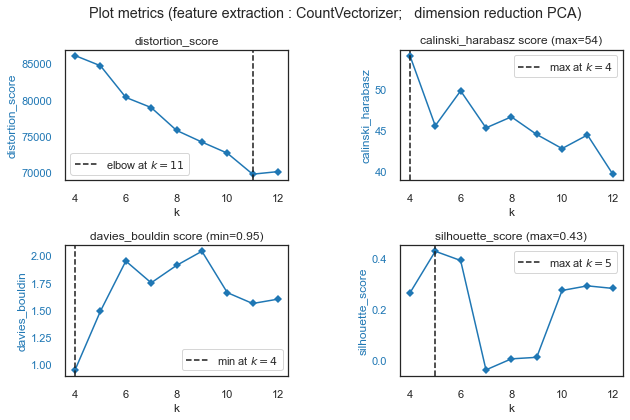

In [113]:
# from sklearn.decomposition import PCA

pca_reducer = decomposition.PCA(n_components=0.99)

scores1b, labels1b, X_tsne1b, k1b = score_model(data_T, labels_true=y_cat_txt,
                                                feature_extractor=unigram_count_vectorizer,
                                                dimension_reducer=pca_reducer,
                                                kmin=4, kmax=12)
ARI1b = calc_ARI(y_cat_txt, labels1b)
# add to global scores
df_resultats = add_model_score(
    model_name='BOW (unigrams) + PCA', ARI=ARI1b, k=k1b)
plot_metrics(scores1b)


Correspondance des clusters :  [6 4 2 5 2]
ARI = 0.016
                            precision    recall  f1-score   support

                 Baby Care       0.00      0.00      0.00       150
  Beauty and Personal Care       0.00      0.00      0.00       150
                 Computers       0.96      0.15      0.25       150
Home Decor & Festive Needs       0.00      0.00      0.00       150
           Home Furnishing       0.51      0.23      0.32       150
          Kitchen & Dining       1.00      0.35      0.51       150
                   Watches       0.17      1.00      0.28       150

                  accuracy                           0.25      1050
                 macro avg       0.38      0.25      0.20      1050
              weighted avg       0.38      0.25      0.20      1050

"BOW_(unigrams)_+_PCA_-_confusion_matrix_(ARI=0-016).png"


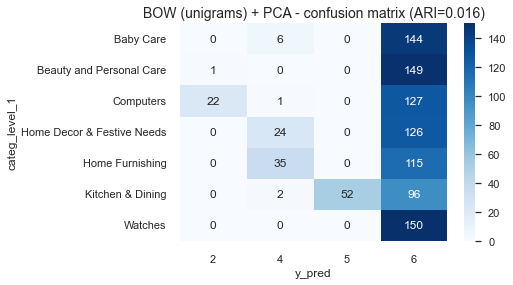

In [114]:
ari_1b = plot_classification_metrics(y_cat_txt, labels1b)
plt.title(
    f'BOW (unigrams) + PCA - confusion matrix (ARI={ari_1b:.3f})', fontsize=14)
to_png()


#### Visualiser les clusters pour k=7


Extract_features (CountVectorizer), fit time = 0.06 s
type(features) = <class 'scipy.sparse.csr.csr_matrix'>
converting features from sparse to dense array
features.shape =(1050, 1449)
Reduced dimensions [(1050, 411)] (PCA), fit time = 0.65 s
k=7, fit: 0.2 s, silhouette= 0.314, ARI = 0.037, cluster sizes (%) = [83  8  4  1  0  0  0]
ARI :  0.0368
"Visualisation_des_clusters_(feature_extraction-_Bag-Of-Words;_dimension_reduction-_PCA;_ARI_=_0-037.png"


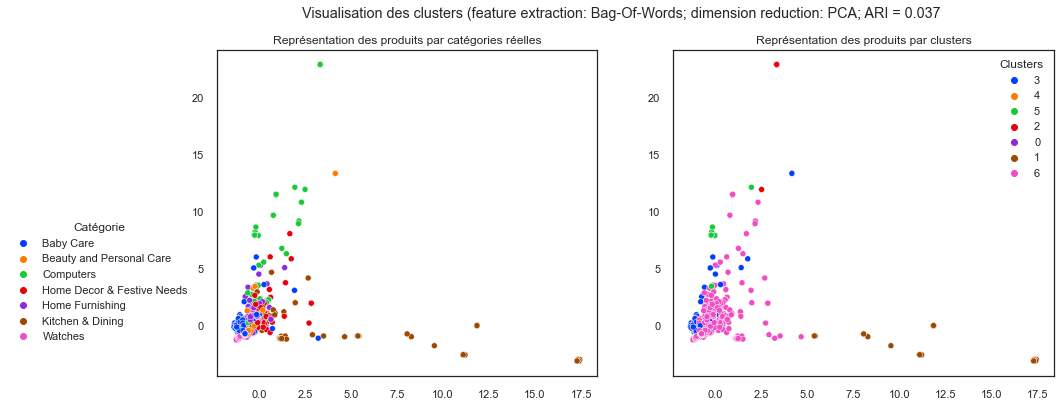

In [115]:
# répéter pour k=7 pour retourner les labels pour k=7
scores1c, labels1c, X_tsne1c, k1c = score_model(data_T, labels_true=y_cat_txt,
                                                feature_extractor=unigram_count_vectorizer,
                                                dimension_reducer=pca_reducer,
                                                kmin=7, kmax=7)

ARI1c = calc_ARI(y_cat_txt, labels1c)
# add to global scores
df_resultats = add_model_score(
    model_name='BOW (unigrams) + PCA', ARI=ARI1c, k=7)

fig = plot_clusters_sur_2D(
    X_tsne1c, y_cat_txt, labels1c, ARI1c, palette='bright')
plt.suptitle(
    f"Visualisation des clusters (feature extraction: Bag-Of-Words; dimension reduction: PCA; ARI = {ARI1c:.3f}")
to_png()


La réduction des dimensions seulement avec PCA ne semble pas très utile.


### Bag-of-Words avec reduction de dimensions via PCA + TSNE

On essaie reduction de dimensions par PCA, suivi par TSNE sur les dimensions réduites (réduction de dimensions en deux étapes)


Extract_features (CountVectorizer), fit time = 0.05 s
type(features) = <class 'scipy.sparse.csr.csr_matrix'>
converting features from sparse to dense array
features.shape =(1050, 1449)
Reduced dimensions [(1050, 2)] (Pipeline), fit time = 15.82 s
k=4, fit: 0.06 s, silhouette= 0.424, ARI = 0.35, cluster sizes (%) = [35 26 23 14]
k=5, fit: 0.16 s, silhouette= 0.411, ARI = 0.416, cluster sizes (%) = [25 25 20 14 13]
k=6, fit: 0.13 s, silhouette= 0.445, ARI = 0.36, cluster sizes (%) = [22 20 17 16 14  8]
k=7, fit: 0.15 s, silhouette= 0.481, ARI = 0.402, cluster sizes (%) = [21 16 14 13 13 12  8]
k=8, fit: 0.2 s, silhouette= 0.482, ARI = 0.475, cluster sizes (%) = [17 14 14 12 12 11 10  7]
k=9, fit: 0.16 s, silhouette= 0.479, ARI = 0.505, cluster sizes (%) = [16 14 12 11 11 10  8  7  7]
k=10, fit: 0.16 s, silhouette= 0.464, ARI = 0.494, cluster sizes (%) = [15 14 11 11  9  8  7  7  7  6]
k=11, fit: 0.19 s, silhouette= 0.48, ARI = 0.492, cluster sizes (%) = [14 14 12 11  9  7  7  7  7  5  2]

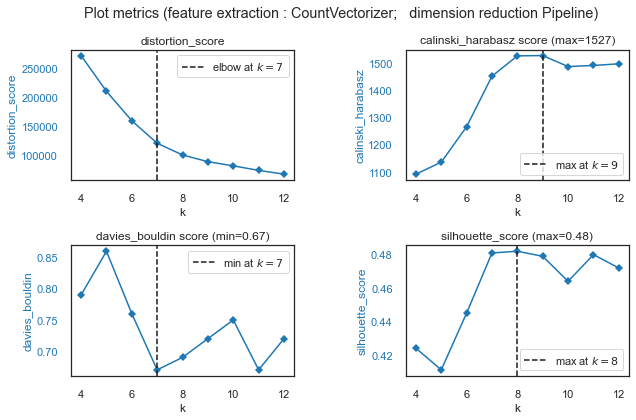

In [116]:
pca_tsne_reducer_pipeline = pipeline.Pipeline(
    steps=[('pca', pca_reducer), ('tsne', tsne_reducer)])

scores1d, labels1d, X_tsne1d, k1d = score_model(data_T, labels_true=y_cat_txt,
                                                feature_extractor=unigram_count_vectorizer,
                                                dimension_reducer=pca_tsne_reducer_pipeline,
                                                kmin=4, kmax=12)
plot_metrics(scores1d)


combining clusters 7 <  8
[0, 1, 2, 3, 4, 5, 6, 7]
Correspondance des clusters :  [4 6 2 3 0 1 5 2]
ARI = 0.459
                            precision    recall  f1-score   support

                 Baby Care       0.72      0.65      0.68       150
  Beauty and Personal Care       0.77      0.66      0.71       150
                 Computers       0.44      0.91      0.60       150
Home Decor & Festive Needs       0.72      0.73      0.72       150
           Home Furnishing       0.88      0.62      0.73       150
          Kitchen & Dining       0.97      0.49      0.65       150
                   Watches       1.00      0.99      1.00       150

                  accuracy                           0.72      1050
                 macro avg       0.79      0.72      0.73      1050
              weighted avg       0.79      0.72      0.73      1050

"BOW_(unigrams)_PCA_+_TSNE_-_confusion_matrix_(ARI=0-459).png"


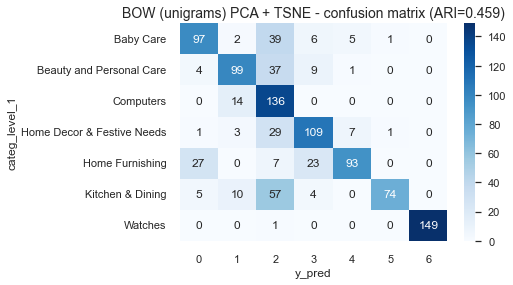

In [117]:
ari_1d = plot_classification_metrics(y_cat_txt, labels1d)
plt.title(
    f'BOW (unigrams) PCA + TSNE - confusion matrix (ARI={ari_1d:.3f})', fontsize=14)
to_png()


Le feature reduction PCA + TSNE crée un meilleure silhouette score que feature reduction avec seulement TSNE


#### Visualise clusters produit par PCA+TSNE


ARI :  0.4753107765868699
"Bag-of-Words_(CountVectorizer),_reducer(PCA_+_TSNE),_ARI_=_0-475.png"


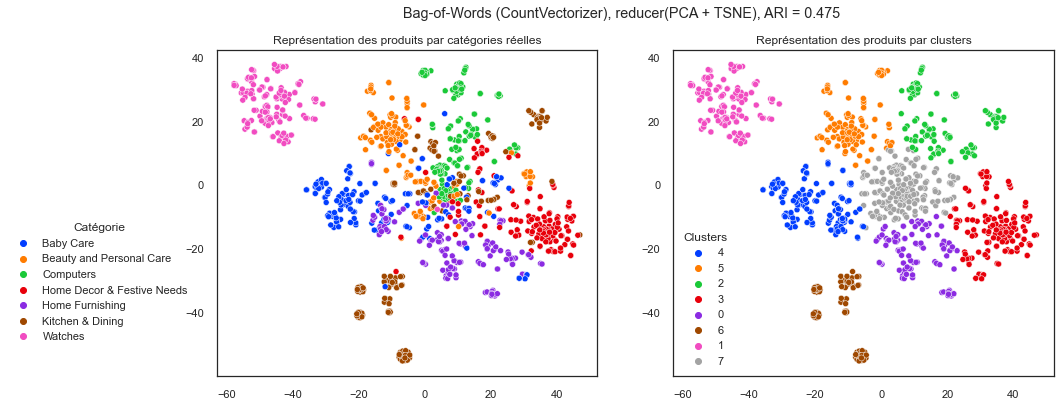

In [118]:

ARI1d = metrics.adjusted_rand_score(
    y_cat_txt, labels1d)

# add to global scores
df_resultats = add_model_score(
    model_name='BOW (unigrams) + PCA + TSNE', ARI=ARI1d, k=k1d)

fig = plot_clusters_sur_2D(
    X_tsne1d, y_cat_txt, labels1d, ARI1d, palette='bright')
plt.suptitle(
    f'Bag-of-Words (CountVectorizer), reducer(PCA + TSNE), ARI = {ARI1d:.3f}')
to_png()


combining clusters 7 <  8
[0, 1, 2, 3, 4, 5, 6, 7]
Correspondance des clusters :  [4 6 2 3 0 1 5 2]
ARI = 0.459
                            precision    recall  f1-score   support

                 Baby Care       0.72      0.65      0.68       150
  Beauty and Personal Care       0.77      0.66      0.71       150
                 Computers       0.44      0.91      0.60       150
Home Decor & Festive Needs       0.72      0.73      0.72       150
           Home Furnishing       0.88      0.62      0.73       150
          Kitchen & Dining       0.97      0.49      0.65       150
                   Watches       1.00      0.99      1.00       150

                  accuracy                           0.72      1050
                 macro avg       0.79      0.72      0.73      1050
              weighted avg       0.79      0.72      0.73      1050

"BOW_(unigrams)_+_PCA_+_TSNE_-_confusion_matrix_(ARI=0-459).png"


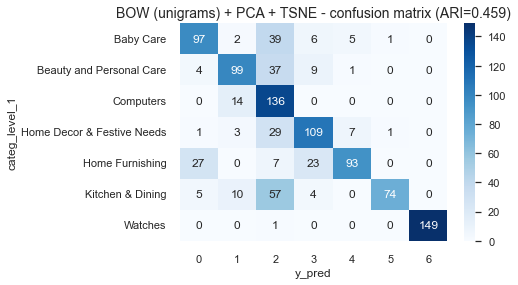

In [119]:
ari_1d = plot_classification_metrics(y_cat_txt, labels1d)
plt.title(
    f'BOW (unigrams) + PCA + TSNE - confusion matrix (ARI={ari_1d:.3f})', fontsize=14)
to_png()


### Bi-grammes


Extract_features (CountVectorizer), fit time = 0.09 s
type(features) = <class 'scipy.sparse.csr.csr_matrix'>
converting features from sparse to dense array
features.shape =(1050, 1851)
Reduced dimensions [(1050, 2)] (TSNE), fit time = 14.24 s
k=4, fit: 0.07 s, silhouette= 0.396, ARI = 0.206, cluster sizes (%) = [46 20 19 14]
k=5, fit: 0.13 s, silhouette= 0.401, ARI = 0.213, cluster sizes (%) = [42 23 19 12  1]
k=6, fit: 0.14 s, silhouette= 0.398, ARI = 0.229, cluster sizes (%) = [36 17 17 16 12  1]
k=7, fit: 0.16 s, silhouette= 0.399, ARI = 0.25, cluster sizes (%) = [32 18 17 16 13  1  0]
k=8, fit: 0.16 s, silhouette= 0.427, ARI = 0.269, cluster sizes (%) = [34 16 15 12 11  9  1  0]
k=9, fit: 0.17 s, silhouette= 0.43, ARI = 0.288, cluster sizes (%) = [32 16 16 11 11  9  0  0  0]
k=10, fit: 0.18 s, silhouette= 0.441, ARI = 0.286, cluster sizes (%) = [30 13 12 12 11  9  8  0  0  0]
k=11, fit: 0.19 s, silhouette= 0.443, ARI = 0.287, cluster sizes (%) = [30 14 12 12 11  9  8  0  0  0  0]
k

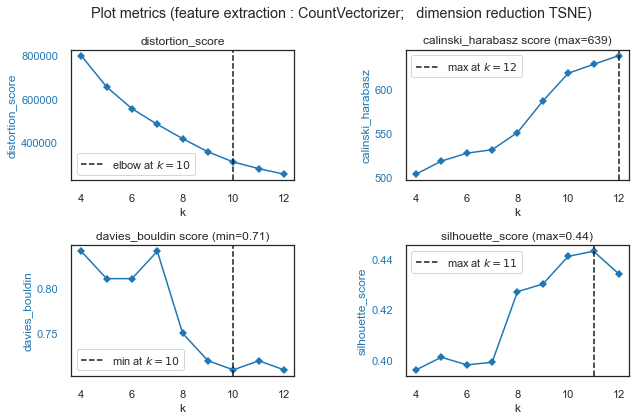

In [120]:
bigram_count_vectorizer = CountVectorizer(ngram_range=(2, 2), min_df=3)

scores1_bigrammes, labels1_bi, X_tsne1_bi, k1_bi = score_model(data_T, labels_true=y_cat_txt,
                                                               feature_extractor=bigram_count_vectorizer,
                                                               dimension_reducer=tsne_reducer,
                                                               kmin=4, kmax=12)
ARI1_bi = calc_ARI(y_cat_txt, labels1_bi)
print(f'Bi-grammes, ARI = {ARI1_bi}')

# add to global scores
df_resultats = add_model_score(
    model_name='BOW (bigrams) + TSNE', ARI=ARI1_bi, k=k1_bi)
plot_metrics(scores1_bigrammes)


### Tri-grammes


Extract_features (CountVectorizer), fit time = 0.08 s
type(features) = <class 'scipy.sparse.csr.csr_matrix'>
converting features from sparse to dense array
features.shape =(1050, 1851)
Reduced dimensions [(1050, 2)] (TSNE), fit time = 15.1 s
k=4, fit: 0.08 s, silhouette= 0.371, ARI = 0.197, cluster sizes (%) = [45 26 18  9]
k=5, fit: 0.12 s, silhouette= 0.352, ARI = 0.219, cluster sizes (%) = [38 24 20 16  1]
k=6, fit: 0.14 s, silhouette= 0.395, ARI = 0.234, cluster sizes (%) = [37 20 18 11 10  1]
k=7, fit: 0.15 s, silhouette= 0.433, ARI = 0.259, cluster sizes (%) = [35 16 13 12 11 10  1]
k=8, fit: 0.15 s, silhouette= 0.436, ARI = 0.261, cluster sizes (%) = [34 16 16 11 10  8  0  0]
k=9, fit: 0.17 s, silhouette= 0.432, ARI = 0.304, cluster sizes (%) = [27 15 14 13 11  8  7  0  0]
k=10, fit: 0.18 s, silhouette= 0.44, ARI = 0.303, cluster sizes (%) = [26 14 12 11 11  7  6  6  0  0]
k=11, fit: 0.17 s, silhouette= 0.446, ARI = 0.282, cluster sizes (%) = [26 13 12 11 11 10  7  3  0  0  0]
k

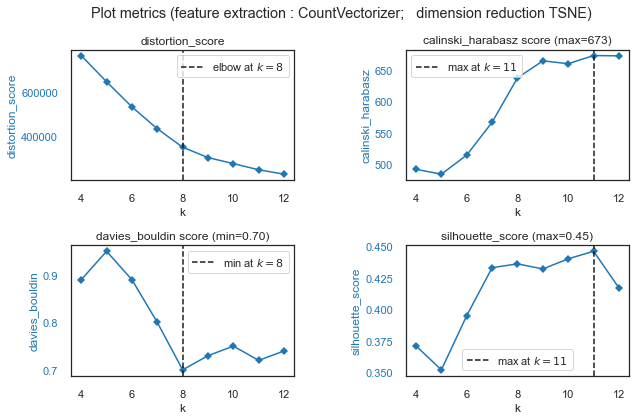

In [121]:
trigram_count_vectorizer = CountVectorizer(ngram_range=(2, 2), min_df=3)

scores1_trigrammes, labels1_tri, X_tsne1_tri, k1_tri = score_model(data_T, labels_true=y_cat_txt,
                                                                   feature_extractor=trigram_count_vectorizer,
                                                                   dimension_reducer=tsne_reducer,
                                                                   kmin=4, kmax=12)
ARI1_tri = calc_ARI(y_cat_txt, labels1_tri)

print(f'Tri-grammes, ARI = {ARI1_tri}')

# add to global scores
df_resultats = add_model_score(
    model_name='BOW (trigrams) + TSNE', ARI=ARI1_tri, k=k1_tri)
plot_metrics(scores1_trigrammes)


### Silhouette Visualisation des meilleurs clusters

Les meilleurs performances sont pour unigram_vectorizer (Bag_of_words) et reduction de dimensions par TSNE.

On regarde l'homogénéité des clusters pour k=7


"Silhouettes_pour_Bag-Of-Words_(+_TSNE_feature_reduction)-Silhouette_score_for_7_clusters_-_0-475.png"


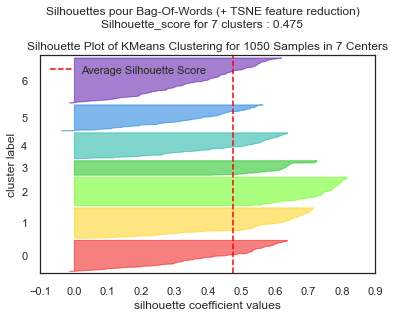

In [122]:
# from yellowbrick.cluster import SilhouetteVisualizer
# from sklearn import cluster

def plot_silhouettes(df: pd.DataFrame, k_clusters=7, titre=''):
    """shortcut to preprocess, fit and run silhouette visualizer"""
    cluster_colors = sns.color_palette('nipy_spectral_r', n_colors=k_clusters)
    estimator = cluster.KMeans(n_clusters=k_clusters, random_state=RANDOM_SEED)
    visualizer = SilhouetteVisualizer(estimator, colors=cluster_colors)
    visualizer.fit(df)
    # ~ 5 minutes
    visualizer.finalize()        # Finalize and render the figure
    subtitre = f'Silhouette_score for {k_clusters} clusters : {visualizer.silhouette_score_:.3f}'
    plt.suptitle(f'{titre}\n{subtitre}', fontsize=12, y=1.05)
    to_png(f'{titre}-{subtitre}')


plot_silhouettes(X_tsne1a, k_clusters=7,
                 titre='Silhouettes pour Bag-Of-Words (+ TSNE feature reduction)')


"Silhouettes_pour_Bag-Of-Words_(PCA_+_TSNE_feature_reduction)-Silhouette_score_for_7_clusters_-_0-481.png"


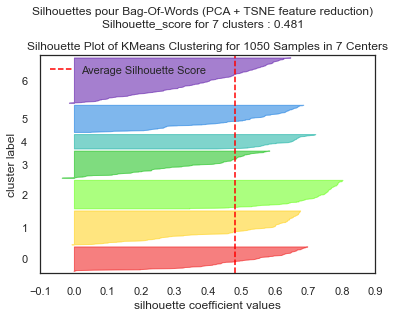

In [123]:
plot_silhouettes(X_tsne1d, k_clusters=7,
                 titre='Silhouettes pour Bag-Of-Words (PCA + TSNE feature reduction)')


### Visualise les meilleurs résultats


In [124]:
print("CountVectorizer : ")
print("-----------------")

data_vectorized = unigram_count_vectorizer.fit_transform(
    data_T['sentence_bow_lem'])

ARI1, X_tsne1, labels1 = calc_tsne_cluster(data_vectorized, k=7)

# add to global scores
df_resultats = add_model_score(
    model_name='BOW (unigrams) + TSNE', ARI=ARI1, k=7)
# Ajout aux libellés
data_T['labels_bow'] = labels1


CountVectorizer : 
-----------------
reducer t-SNE, input shape=(1050, 1449)
reducer t-SNE, shape =(1050, 2) time : 15.0
ARI :  0.4492 time :  1.0


ARI :  0.4492
"Bag-of-Words_(CountVectorizer),_ARI_=_0-449.png"


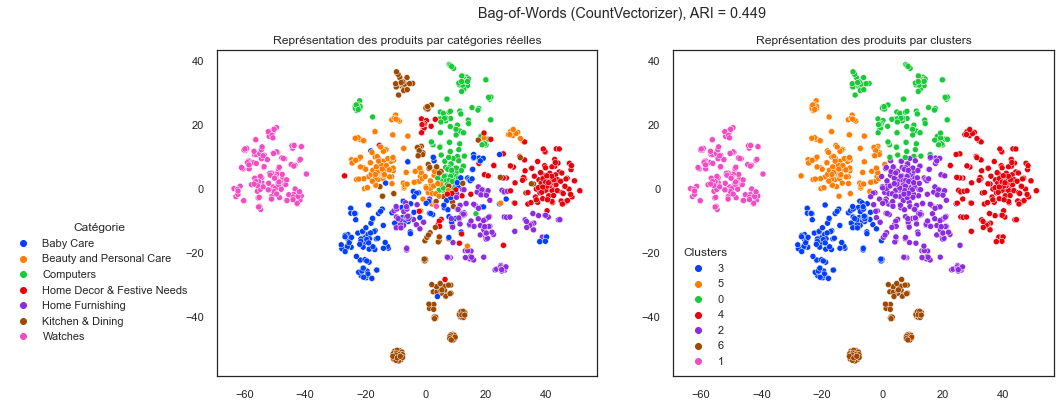

In [125]:
fig = plot_clusters_sur_2D(X_tsne1, y_cat_txt, labels1, ARI1, palette='bright')
plt.suptitle(f'Bag-of-Words (CountVectorizer), ARI = {ARI1:.3f}')
to_png()


categ_level_1 clusters
(49, 3)
Index(['categ_level_1', 'variable', 'value'], dtype='object')


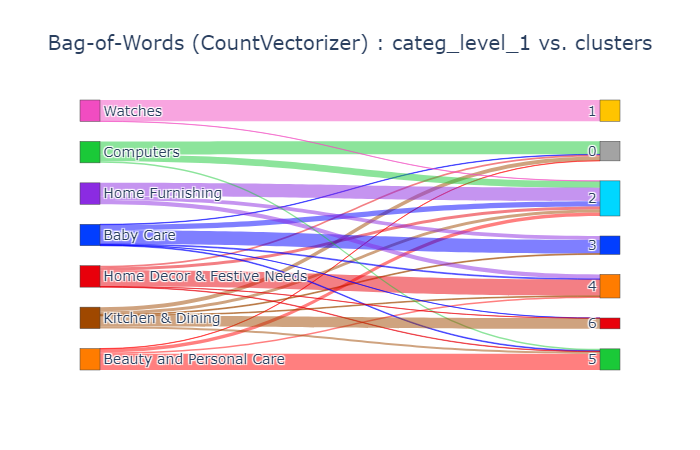

In [126]:
plot_sankey_confusion_diagram(y_cat_txt, labels1,
                              titre='Bag-of-Words (CountVectorizer)', palette='bright')


### Comparaison si on ne retire pas les publicités


CountVectorizer (avec ads): 
-----------------
reducer t-SNE, input shape=(1050, 1454)
reducer t-SNE, shape =(1050, 2) time : 16.0
ARI :  0.3899 time :  1.0
ARI :  0.3899
"Bag-of-Words_avec_Ads_(CountVectorizer),_ARI_=_0-390.png"


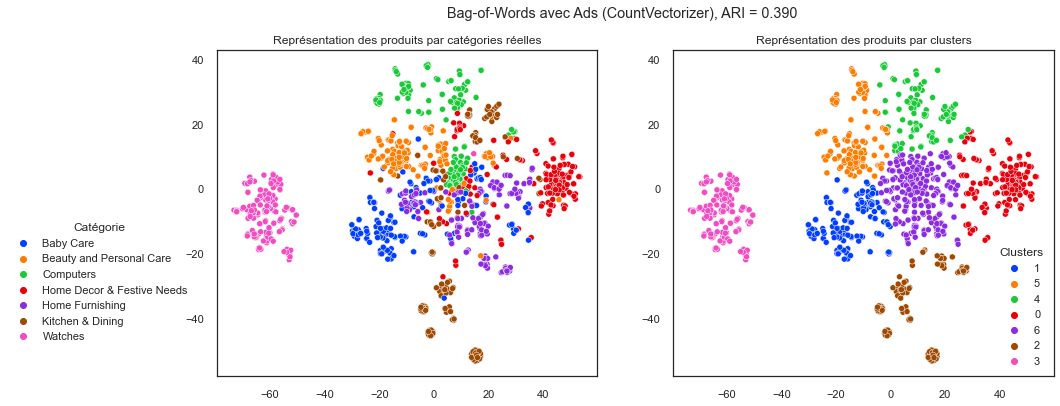

In [127]:
# On applique à la sentence crée à partir de bag-of-words avec lemmatization
feature_ads = 'sentence_bow_lem_ads'

data_ads_vectorized = unigram_count_vectorizer.fit_transform(
    data_T[feature_ads])

print("CountVectorizer (avec ads): ")
print("-----------------")
ARI1_ads, X_tsne1_ads, labels1_ads = calc_tsne_cluster(
    data_ads_vectorized, k=7)

# add to global scores
df_resultats = add_model_score(
    model_name='BOW (avec publicités) + TSNE', ARI=ARI1, k=7)

fig = plot_clusters_sur_2D(X_tsne1_ads, y_cat_txt, labels1_ads, ARI1_ads)
plt.suptitle(f'Bag-of-Words avec Ads (CountVectorizer), ARI = {ARI1_ads:.3f}')
to_png()


#### Evaluation metrics


Correspondance des clusters :  [3 0 5 6 2 1 4]
ARI = 0.390
              precision    recall  f1-score   support

           0       0.71      0.65      0.68       150
           1       0.68      0.68      0.68       150
           2       0.49      0.39      0.44       150
           3       0.68      0.69      0.69       150
           4       0.31      0.49      0.38       150
           5       0.72      0.49      0.58       150
           6       1.00      0.99      1.00       150

    accuracy                           0.63      1050
   macro avg       0.65      0.63      0.63      1050
weighted avg       0.65      0.63      0.63      1050

"BOW_avec_Ads_(CountVectorizer)_-_confusion_matrix_(ARI=0-390).png"


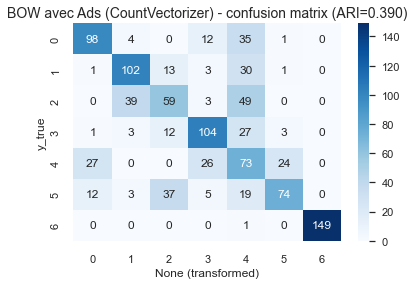

In [128]:
ari_1_ads = plot_classification_metrics(y_cat_num, pd.Series(labels1_ads))
plt.title(
    f'BOW avec Ads (CountVectorizer) - confusion matrix (ARI={ari_1_ads:.3f})', fontsize=14)
to_png()


categ_level_1 clusters
(49, 3)
Index(['categ_level_1', 'variable', 'value'], dtype='object')


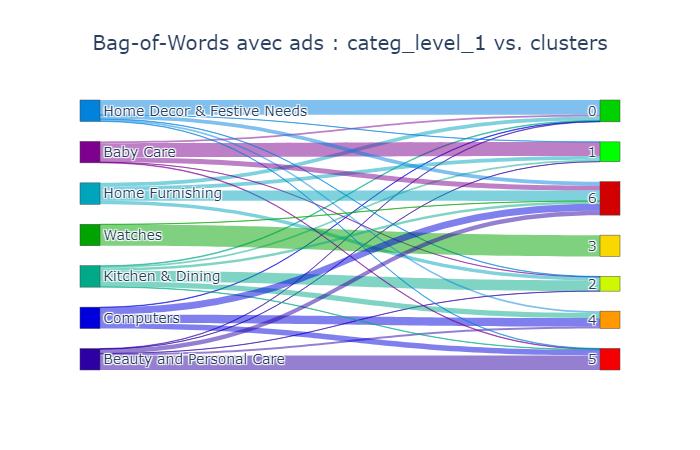

In [129]:
plot_sankey_confusion_diagram(
    y_cat_txt, labels1_ads, titre='Bag-of-Words avec ads')


En effet, les publicités de flipkart :

- crée des markers de catégorie, car seulement certaines catégories contient ces publicités
- crée du bruit qui empêche de distinguer les produits.

On reste sur les descriptions sans publicité qui n'est pas une propriété du produit.


In [130]:
# Cleanup variables
del data_ads_vectorized, data_vectorized, cv_transform


## 5.2 Essaie 2 : TF-IDF

(Term Frequency - Inverse Document Frequency)

### Création de la matrice de mots (Tf-idf)

On fait comme pour le Bag-of-Words


In [131]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# mots present dans un minimum de 3 produits
tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=3)

# On applique à la sentence crée à partir de bag-of-words avec lemmatization
feature = 'sentence_bow_lem'
tfidf_vectors = tfidf_vectorizer.fit_transform(data_T[feature])


#### Enregistrer les Tf-idf features

On sauvegarde les features extraites des textes par Tf-Idf pour ajouter au features extraites des images par VGG-16


In [132]:
save_pickle(tfidf_vectors, 'features_tfidf', OUT_FOLDER)


La matrice `ctf_transform` represent les vectors TF-IDF crée par TfidfVectorizer :


In [133]:
df_tf = pd.DataFrame.sparse.from_spmatrix(
    tfidf_vectors,
    columns=tfidf_vectorizer.get_feature_names_out(),
    index=data_T.index).join(data_T['product_name'])


print(data_T[feature][40])
print(data_T[feature][42])
print(data_T[feature][43])

df_tf.loc[40:45, ['baby', 'girl', 'grey', 'blue', 'pyjama',
                  'cotton', 'hair', 'product_name']]


key mom kid baby girl printed green top pyjama set fabric cotton brand color greenmom kid baby girl printed green top pyjama set girl pyjama setspecifications mom kid baby girl printed green top pyjama set pattern printed ideal baby girl night suit fabric cotton top pyjama set neck round neck box top pyjama set
key mom kid baby girl printed blue grey top pyjama set fabric cotton brand color blue greymom kid baby girl printed blue grey top pyjama set girl pyjamasetspecifications mom kid baby girl printed blue grey top pyjama set pattern printed ideal baby girl night suit number content pack fabric cotton top pyjama set neck round nack box top pyjama set
key burt bee hair repair shea grapefruit deep conditioner ideal boy girl applied deep conditioning hair condition damaged hair hair dry hairspecifications burt bee hair repair shea grapefruit deep conditioner ml conditioner trait hair condition damaged hair hair dry hair applied deep conditioning ideal boy girl trait brand burt bee quant

baby  girl  grey  blue  pyjama  cotton  hair  \
40  0.25  0.31  0.00  0.00    0.65    0.11  0.00   
41  0.00  0.00  0.31  0.00    0.00    0.09  0.00   
42  0.25  0.32  0.29  0.29    0.55    0.12  0.00   
43  0.00  0.09  0.00  0.00    0.00    0.00  0.71   
44  0.00  0.00  0.00  0.00    0.00    0.00  0.00   
45  0.00  0.00  0.00  0.00    0.00    0.00  0.00   

                                                    product_name  
40        Mom and Kid Baby Girl's Printed Green Top & Pyjama Set  
41                                Kripa's Printed Cushions Cover  
42   Mom and Kid Baby Girl's Printed Blue, Grey Top & Pyjama Set  
43  Burt s Bees Hair Repair Shea And Grapefruit Deep Conditioner  
44                                AKUP i-loves-music Ceramic Mug  
45                                AKUP i-love-my-mom Ceramic Mug

### Exécution du modèle (clustering) et visualisation


In [134]:
print("Tf-idf : ")
print("--------")
ARI2, X_tsne2, labels2 = calc_tsne_cluster(tfidf_vectors)
# add to global scores
df_resultats = add_model_score(model_name='TF-IDF + TSNE', ARI=ARI2, k=7)
# Ajout au résultat
data_T['labels_tfidf'] = labels2


Tf-idf : 
--------
reducer t-SNE, input shape=(1050, 1382)
reducer t-SNE, shape =(1050, 2) time : 15.0
ARI :  0.5511 time :  1.0


ARI :  0.5511
"Bag-of-Words_(TF-IDF),_ARI_=_0-551.png"


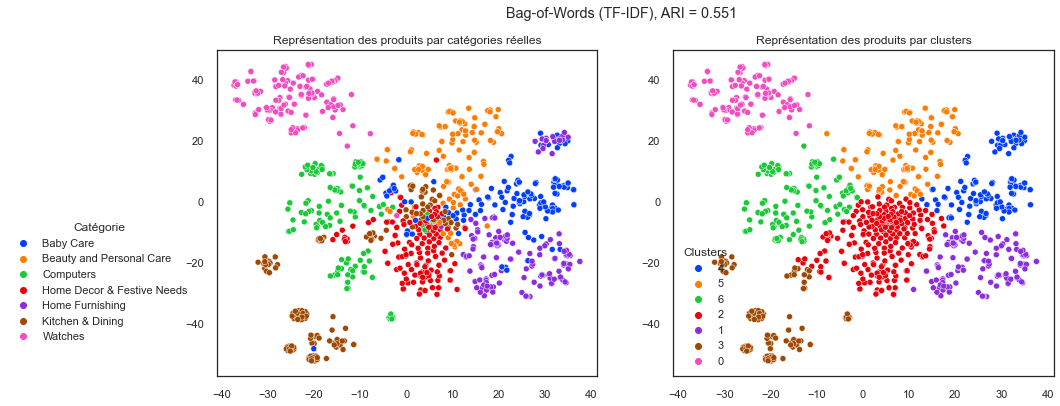

In [135]:
fig = plot_clusters_sur_2D(X_tsne2, y_cat_txt, labels2, ARI2)
plt.suptitle(f'Bag-of-Words (TF-IDF), ARI = {ARI2:.3f}')
to_png()


categ_level_1 clusters
(49, 3)
Index(['categ_level_1', 'variable', 'value'], dtype='object')


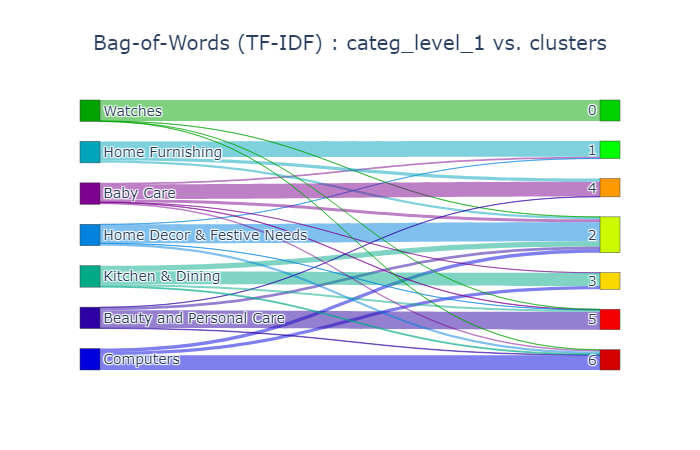

In [136]:
plot_sankey_confusion_diagram(y_cat_txt, labels2,
                              titre='Bag-of-Words (TF-IDF)')


#### Evaluation metrics


Correspondance des clusters :  [6 4 3 5 0 1 2]
ARI = 0.551
                            precision    recall  f1-score   support

                 Baby Care       0.80      0.69      0.74       150
  Beauty and Personal Care       0.87      0.83      0.85       150
                 Computers       0.73      0.69      0.71       150
Home Decor & Festive Needs       0.53      0.88      0.66       150
           Home Furnishing       0.90      0.74      0.81       150
          Kitchen & Dining       0.79      0.61      0.69       150
                   Watches       1.00      0.98      0.99       150

                  accuracy                           0.77      1050
                 macro avg       0.80      0.77      0.78      1050
              weighted avg       0.80      0.77      0.78      1050

"TF-IDF_-_confusion_matrix_(ARI=0-551).png"


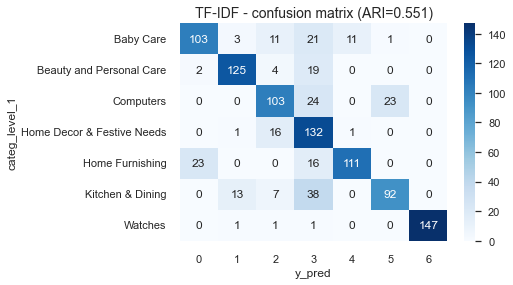

In [137]:
# cls_labels_transform = conf_mat_transform(y_cat_num, labels2)
ari_2 = plot_classification_metrics(y_cat_txt, labels2)
plt.title(f'TF-IDF - confusion matrix (ARI={ari_2:.3f})', fontsize=14)
to_png()


# 6. LDA - (Topic modelling)

- <https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/>

## 6.1 Essaie 3 : LDA - Latent Dirichlet Allocation

On va essaie de trouver les topics (clusters)

- à partir de Bag-Of-Words
- à partir de TF-IDF

Features à créer :

- `topic_LDA_BOW` : catégories créées à partir des 'Bag-of-Words' descriptions
- `topic_LDA_TF` : catégories créées à partir des 'TF-IDF' matrice


### 6.3.1 Essaie 3a : LDA sur Bag-of-Words


In [138]:
count_vectorizer = CountVectorizer(analyzer='word',
                                   ngram_range=(1, 1),
                                   min_df=3,                        # minimum reqd occurrences of a word
                                   stop_words='english',             # remove stop words
                                   lowercase=True,                   # convert all words to lowercase
                                   # num chars > 3
                                   token_pattern='[a-zA-Z0-9]{3,}',
                                   )


# On applique à la sentence crée à partir de bag-of-words avec lemmatization
feature = 'sentence_bow_lem'
data_vectorized = count_vectorizer.fit_transform(data_T[feature])


#### Sparsicity des données vectorizés


In [139]:

# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")


Sparsicity:  1.3153705269089884 %


#### Gridsearch pour les meilleurs paramètres


In [140]:
# from sklearn.decomposition import LatentDirichletAllocation
# from sklearn.model_selection import GridSearchCV

lda = decomposition.LatentDirichletAllocation(random_state=RANDOM_SEED,
                                              max_iter=10,               # Max learning iterations
                                              learning_method='online',
                                              batch_size=128,            # n docs in each learning iter
                                              )

# Cette param_grid prend environ 5 minutes
# Define Search Param
search_params = {
    'n_components': [7, 8, 9, 10],
    'learning_decay': [.5, .7, .9]
    # 'learning_method': ['batch', 'online'],
    # réduire le poids des premieres iterations par l'augmentation de learning offset
    # 'learning_offset': [2, 5, 10, 20, 50, 100],
}

# best params
# param_grid={'learning_decay': [0.9], 'learning_method': ['online'], 'learning_offset': [20]}

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params, verbose=1,
                     cv=2, return_train_score=True)

# Do the Grid Search
model.fit(data_vectorized)


Fitting 2 folds for each of 12 candidates, totalling 24 fits


GridSearchCV(cv=2,
             estimator=LatentDirichletAllocation(learning_method='online',
                                                 random_state=42),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [7, 8, 9, 10]},
             return_train_score=True, verbose=1)

#### Meilleur model performance (perplexity et log-likelihood)

- plus haut log-likelihood
- plus bas perplexity (=exp(-1. \* log-likelihood per word))

Note : perplexity ne considère pas le contexte et les associations sémantiques entre les mots.


In [141]:
# Best Model

best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score (Higher = better)
print("Best Log Likelihood Score: ", model.best_score_)
print("Best Log Likelihood Score: ", best_lda_model.score(data_vectorized))

# Perplexity = exp(-1. * log-likelihood per word) (lower=better)
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

# See model parameters
print(best_lda_model.get_params())


Best Model's Params:  {'learning_decay': 0.9, 'n_components': 8}
Best Log Likelihood Score:  -127346.36186044733
Best Log Likelihood Score:  -200052.3422060237
Model Perplexity:  371.47547101262427
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.9, 'learning_method': 'online', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 8, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': 42, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


#### Compare LDA Model Performance Scores


In [142]:

gridscores = pd.DataFrame(model.cv_results_)
gridscores.head()


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0           1.11          0.20             0.10            0.01   
1           0.88          0.01             0.09            0.01   
2           1.03          0.14             0.10            0.01   
3           0.86          0.06             0.09            0.01   
4           0.95          0.03             0.10            0.01   

  param_learning_decay param_n_components  \
0                 0.50                  7   
1                 0.50                  8   
2                 0.50                  9   
3                 0.50                 10   
4                 0.70                  7   

                                        params  split0_test_score  \
0   {'learning_decay': 0.5, 'n_components': 7}         -134919.28   
1   {'learning_decay': 0.5, 'n_components': 8}         -135892.09   
2   {'learning_decay': 0.5, 'n_components': 9}         -137537.69   
3  {'learning_decay': 0.5, 'n_components': 10}         -138986.26   
4   {'learning_decay': 0.7, 'n_components': 7}         -133921.50   

   split1_test_score  mean_test_score  std_test_score  rank_test_score  \
0         -126815.97       -130867.63         4051.66                7   
1         -127148.98       -131520.54         4371.55                8   
2         -128888.85       -133213.27         4324.42               10   
3         -129844.26       -134415.26         4571.00               12   
4         -126367.22       -130144.36         3777.14                5   

   split0_train_score  split1_train_score  mean_train_score  std_train_score  
0          -101637.57           -98707.89        -100172.73          1464.84  
1          -100510.03           -97427.75         -98968.89          1541.14  
2           -99981.51           -96896.04         -98438.78          1542.73  
3           -99557.49           -97091.46         -98324.48          1233.01  
4          -101577.43           -98477.59        -100027.51          1549.92

"Choosing_Optimal_LDA_Model.png"


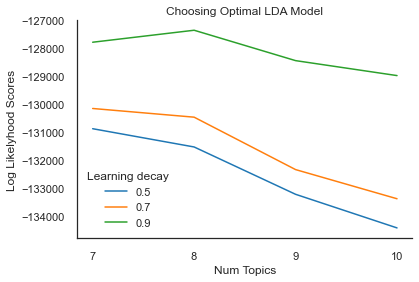

In [143]:
# from matplotlib.ticker import MaxNLocator
def plot_lda_cross_validation(model):

    gridscores = pd.DataFrame(model.cv_results_)

    ax = sns.lineplot(data=gridscores, x='param_n_components',
                      y='mean_test_score', hue='param_learning_decay', palette='tab10')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    sns.despine()
    plt.title("Choosing Optimal LDA Model")
    plt.xlabel("Num Topics")
    plt.ylabel("Log Likelyhood Scores")
    plt.legend(title='Learning decay', loc='best')


plot_lda_cross_validation(model)
to_png()


In [144]:
# Create Document - Topic Matrix
lda_output = model.best_estimator_.transform(data_vectorized)
# n_topics=lda_output.n_components
n_topics = lda_output.shape[1]
# column names
topics = [f'Topic {i}' for i in range(0, n_topics)]
# Make the pandas dataframe
df_topics = pd.DataFrame(np.round(lda_output, 2),
                         columns=topics,
                         index=data_T.index)

# Get dominant topic for each document
df_topics['pred_topic'] = np.argmax(df_topics.values, axis=1)
df_data_topics = df_topics.join(data_T[['product_name', 'categ_level_1']])
df_data_topics.head()


Topic 0  Topic 1  Topic 2  Topic 3  Topic 4  Topic 5  Topic 6  Topic 7  \
0     0.00     0.00     0.00     0.00     0.00     0.00     0.99     0.00   
1     0.05     0.61     0.00     0.00     0.00     0.00     0.00     0.33   
2     0.01     0.47     0.00     0.07     0.00     0.00     0.08     0.35   
3     0.00     0.99     0.00     0.00     0.00     0.00     0.00     0.00   
4     0.00     0.90     0.07     0.00     0.00     0.00     0.03     0.00   

   pred_topic  \
0           6   
1           1   
2           1   
3           1   
4           1   

                                                      product_name  \
0       Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
1                                       Sathiyas Cotton Bath Towel   
2                              Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet   
4            Jaipur Print Cotton Floral King sized Double Bedsheet   

     categ_level_1  
0  Home Furnishing  
1        Baby Care  
2        Baby Care  
3  Home Furnishing  
4  Home Furnishing

In [145]:

df_data_topics['pred_topic'].value_counts()


6    237
0    236
7    201
3    122
1    112
2     62
4     49
5     31
Name: pred_topic, dtype: int64

#### Comparaison de predicted topic et catégorie level 1


In [146]:
# pd.crosstab(df_data_topics['categ_level_1'],
#             df_data_topics['pred_topic'])
conf_matrix_labels(df_data_topics['categ_level_1'],
                   df_topics['pred_topic']).style.background_gradient(axis=1)


In [147]:

ARI3a = calc_ARI(df_data_topics['categ_level_1'], df_data_topics['pred_topic'])
print(ARI3a)
# add to global scores
df_resultats = add_model_score(
    model_name='LDA(BOW) topics', ARI=ARI3a, k=n_topics)
data_T['labels_LDA1'] = df_data_topics['pred_topic']


0.3349


#### Evaluation metrics - LDA (BOW)


combining clusters 7 <  8
[0, 1, 2, 3, 4, 5, 6, 7]
Correspondance des clusters :  [6 5 2 1 5 5 3 0]
ARI = 0.356
                            precision    recall  f1-score   support

                 Baby Care       0.53      0.71      0.60       150
  Beauty and Personal Care       0.43      0.35      0.39       150
                 Computers       0.84      0.35      0.49       150
Home Decor & Festive Needs       0.48      0.76      0.59       150
           Home Furnishing       0.00      0.00      0.00       150
          Kitchen & Dining       0.57      0.73      0.64       150
                   Watches       0.64      1.00      0.78       150

                  accuracy                           0.56      1050
                 macro avg       0.50      0.56      0.50      1050
              weighted avg       0.50      0.56      0.50      1050

"LDA(BOW)_topics_-_confusion_matrix_(ARI=0-356).png"


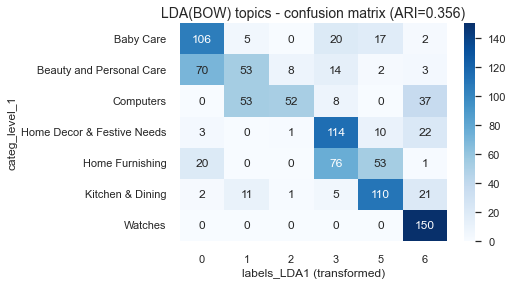

In [148]:
ari_3a = plot_classification_metrics(y_cat_txt, data_T['labels_LDA1'])
plt.title(
    f'LDA(BOW) topics - confusion matrix (ARI={ari_3a:.3f})', fontsize=14)
to_png()


ARI :  0.3349
"LDA_sur_Bag-of-Words,_ARI_=_0-335.png"


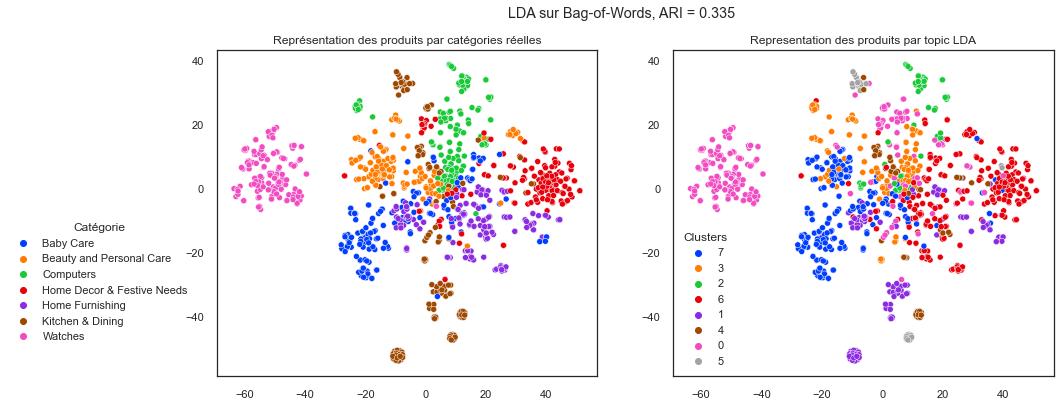

In [149]:
# X_tsne1 sont les dimensions réduites de la variable "data_vectorized", déjà calculés ci-dessus
# ARI1, X_tsne1, labels1 = calc_tsne_cluster(data_vectorized, k=7)
fig = plot_clusters_sur_2D(X_tsne1, y_cat_txt,
                           data_T['labels_LDA1'], ARI3a)
fig.axes[1].set_title('Representation des produits par topic LDA')
plt.suptitle(f'LDA sur Bag-of-Words, ARI = {ARI3a:.3f}')
to_png()


In [150]:
def get_topic_words(model, words, nb_words=10):
    for idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -nb_words - 1: -1]
        top_features = [words[i] for i in top_features_ind]
        # weights = topic[top_features_ind]
        # for n in range(nb_words):
        #     top_features[n]=f'{top_features[n]}[{weights[n]:.0f}]'
        text = ", ".join(top_features)
        print(f'Topic {idx+1}: {text}')


get_topic_words(model.best_estimator_, cvect.get_feature_names_out())


Topic 1: velvet, amazing, marvel, leaf, washable, device, spread, large, variety, cold
Topic 2: ml, cell, couple, majesty, tee, deployment, gen, reversible, lmli, presented
Topic 3: klub, variety, position, actual, bath, hz, promise, grey, boy, pmr
Topic 4: shock, ordering, coloured, scrubbing, model, season, minute, traditional, décor, bootie
Topic 5: space, juice, pair, perfectly, adaptor, line, highest, plug, sonata, cut
Topic 6: ml, pair, bright, international, cmspecifications, livingroom, aero, gen, smallest, promise
Topic 7: set, special, uv, deployment, highest, plain, haveli, cold, method, bowl
Topic 8: awesome, cost, scrubbing, geometric, extremely, operating, hook, box, neck, container


"LDA_sur_bag-of-words,_top_10_mots_pour_chaque_topic.png"


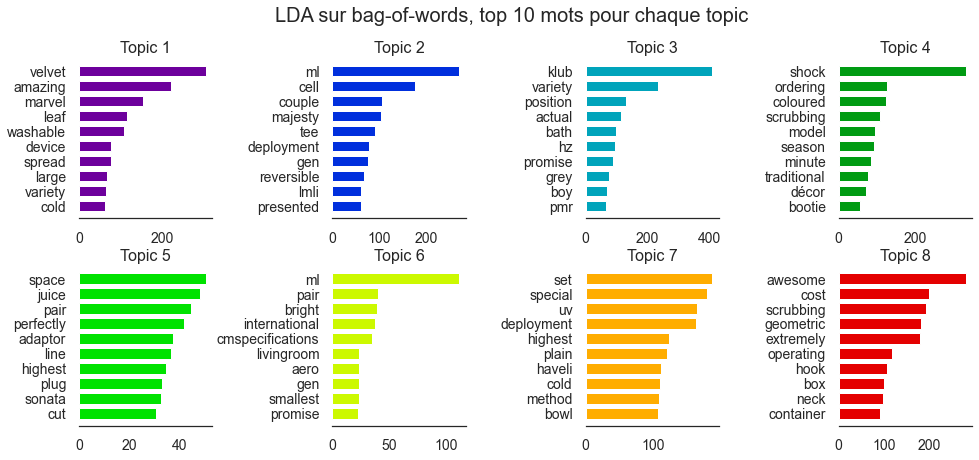

In [151]:
def plot_topic_words(model, topics, titre='', n_top_words=10, cmap='nipy_spectral'):
    """
    plot top words by topic/category
    from <https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html>
    """
    nb_topics = len(model.components_)
    colors = sns.color_palette(cmap, n_colors=nb_topics).as_hex()
    n_cols = 4
    n_rows = nb_topics // n_cols + (nb_topics % n_cols > 0)
    _ = plt.figure(figsize=(n_cols*4, n_rows*3))
    # for n, category in enumerate(categories):
    for topic_idx, topic in enumerate(model.components_):
        ax = plt.subplot(n_rows, n_cols, topic_idx + 1)
        top_features_ind = topic.argsort()[: -n_top_words - 1: -1]
        top_features = [topics[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax.barh(top_features, weights, height=0.7, color=colors[topic_idx])
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 16})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=14)
        ax.grid(visible=False)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.suptitle(titre, fontsize=20, y=1.02)


plot_topic_words(model=model.best_estimator_, topics=cvect.get_feature_names_out(),
                 titre='LDA sur bag-of-words, top 10 mots pour chaque topic')
to_png()


unique words: 1663
unique words: 793
unique words: 620
unique words: 1021
unique words: 607
unique words: 135
unique words: 1917
unique words: 1330
"Top_mots_par_fréquence_dans_chaque_topic_(LDA,_Bag-of-Words).png"


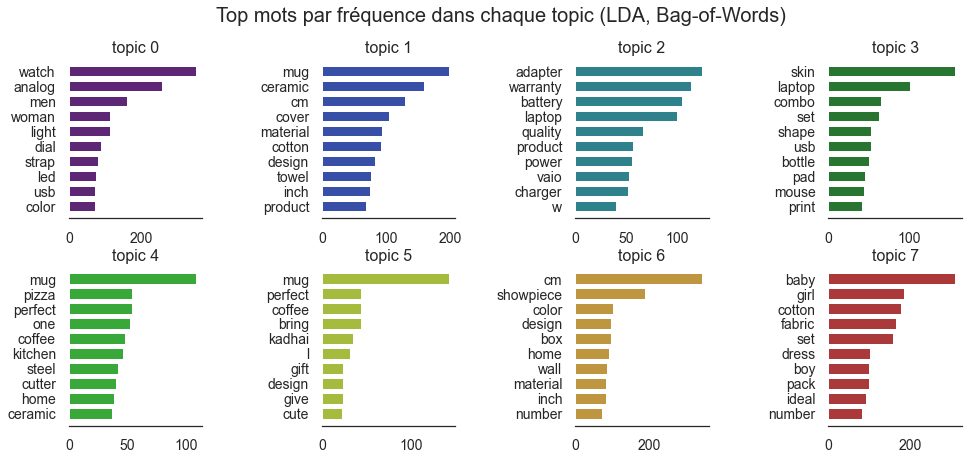

In [152]:
def plot_top_words_from_data(df=data_T, feature='sentence_bow_lem', label_col='labels_LDA1',
                             titre='', label_prefix='cluster', nb_words=10, cmap='nipy_spectral'):
    label_names = df[label_col].unique()
    nb_labels = len(label_names)
    colors = sns.color_palette(cmap, n_colors=nb_labels, desat=0.5).as_hex()
    n_cols = 4
    n_rows = nb_labels // n_cols + (nb_labels % n_cols > 0)
    _ = plt.figure(figsize=(n_cols*4, n_rows*3))
    for idx, label in enumerate(sorted(label_names)):
        label_data = df[df[label_col] == label]
        freq_words = (get_corpus_freq(label_data[feature], nb=nb_words)
                      .to_frame('count')
                      .rename_axis('word')
                      .reset_index()
                      )
        # print(f"Topic {label}: {freq_words['word'].tolist()}")
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        ax.barh(data=freq_words, y='word', width='count',
                height=0.7, color=colors[idx])
        label_title = f'{label_prefix} {label}' if len(
            str(label)) < 3 else label
        ax.set_title(label_title, fontdict={"fontsize": 16})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=14)
        ax.grid(visible=False)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.suptitle(titre, fontsize=20, y=1.02)


plot_top_words_from_data(
    data_T, feature='sentence_bow_lem', label_col='labels_LDA1',
    label_prefix='topic', titre='Top mots par fréquence dans chaque topic (LDA, Bag-of-Words)')
to_png()


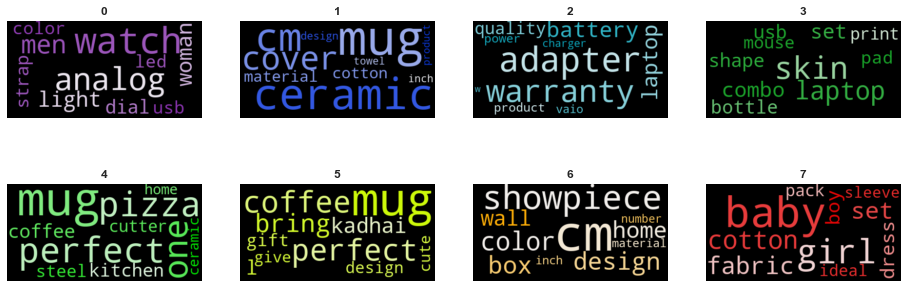

In [153]:
plot_wordclouds_by_categ(
    data_T, feature='sentence_bow_lem', categ_col='labels_LDA1', nb=10)


### 6.3.2 Essaie 3b : LDA sur TF-IDF


In [154]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.decomposition import LatentDirichletAllocation
# from sklearn.model_selection import GridSearchCV


tfidf_vectorizer = TfidfVectorizer(analyzer='word',
                                   min_df=3,                        # minimum reqd occurrences of a word
                                   stop_words='english',             # remove stop words
                                   lowercase=True,                   # convert all words to lowercase
                                   # num chars > 3
                                   token_pattern='[a-zA-Z0-9]{3,}',
                                   )


# On applique aux sentences crée à partir de bag-of-words avec lemmatization
feature = 'sentence_bow_lem'
tfidf_vectors = tfidf_vectorizer.fit_transform(data_T[feature])

lda = decomposition.LatentDirichletAllocation(random_state=RANDOM_SEED,
                                              max_iter=10,               # Max learning iterations
                                              learning_method='online',
                                              batch_size=128,            # n docs in each learning iter
                                              )

# Cette param_grid prend environ 5 minutes
# Define Search Param
search_params = {
    'n_components': [7, 8, 9, 10],
    'learning_decay': [.5, .7, .9]
    # 'learning_method': ['batch', 'online'],
    # réduire le poids des premieres iterations par l'augmentation de learning offset
    # 'learning_offset': [2, 5, 10, 20, 50, 100],
}

# best params
# param_grid={'learning_decay': [0.9], 'learning_method': ['online'], 'learning_offset': [20]}

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params, verbose=1,
                     cv=2, return_train_score=True)

# Do the Grid Search
model.fit(tfidf_vectors)

print(model.best_params_)


Fitting 2 folds for each of 12 candidates, totalling 24 fits
{'learning_decay': 0.9, 'n_components': 7}


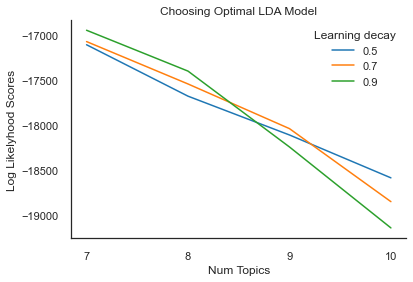

In [155]:
plot_lda_cross_validation(model)


In [156]:
lda_model: decomposition.LatentDirichletAllocation = model.best_estimator_
lda_output = lda_model.transform(tfidf_vectors)

# nb_topics=lda_output.shape[1]
nb_topics = lda_model.components_.shape[0]

# column names
topics = [f'Topic {i}' for i in range(0, nb_topics)]
df_topics = pd.DataFrame(np.round(lda_output, 2),
                         columns=topics, index=data_T.index)
# Get dominant topic for each document
df_topics['pred_topic'] = np.argmax(df_topics.values, axis=1)
print(df_topics.head())

df_data_topics = data_T.join(df_topics)
df_data_topics['pred_topic'].value_counts()


   Topic 0  Topic 1  Topic 2  Topic 3  Topic 4  Topic 5  Topic 6  pred_topic
0     0.02     0.16     0.46     0.02     0.02     0.02     0.29           2
1     0.06     0.51     0.31     0.03     0.03     0.03     0.03           1
2     0.02     0.14     0.02     0.02     0.02     0.02     0.74           6
3     0.02     0.02     0.03     0.02     0.02     0.02     0.85           6
4     0.02     0.02     0.02     0.02     0.02     0.02     0.86           6


6    287
1    225
0    189
2    139
3    105
5     59
4     46
Name: pred_topic, dtype: int64

In [157]:
labels_true = cat_encoder.fit_transform(df_data_topics['categ_level_1'])
labels_pred = df_data_topics['pred_topic']
data_T['labels_LDA2'] = labels_pred
data_T['labels_LDA2'] = data_T['labels_LDA2'].astype(str)


In [158]:
data_T.columns


Index(['product_name', 'product_category_tree', 'pid', 'image', 'description',
       'brand', 'categ_level_1', 'categ_level_2', 'categ_level_3',
       'categ_level_4', 'categ_level_5', 'categ_level_6', 'categ_level_7',
       'sentence_bow', 'sentence_bow_lem', 'product_name_bow_lem',
       'sentence_bow_lem_ads', 'sentence_dl', 'length_bow', 'length_dl',
       'labels_bow', 'labels_tfidf', 'labels_LDA1', 'labels_LDA2'],
      dtype='object')

In [159]:
conf_matrix_labels(data_T['categ_level_1'],
                   data_T['labels_LDA2']).style.background_gradient(axis=1)


In [160]:
ARI3b = calc_ARI(df_data_topics['categ_level_1'], labels_pred)
print(ARI3b)
# add to global scores
df_resultats = add_model_score(
    model_name='LDA(TF_IDF) topics', ARI=ARI3b, k=nb_topics)


0.3623


7
7
Correspondance des clusters :  [6 5 0 1 2 2 3]
ARI = 0.368
                            precision    recall  f1-score   support

                 Baby Care       0.65      0.60      0.62       150
  Beauty and Personal Care       0.90      0.63      0.75       150
                 Computers       0.65      0.45      0.53       150
Home Decor & Festive Needs       0.43      0.82      0.56       150
           Home Furnishing       0.00      0.00      0.00       150
          Kitchen & Dining       0.48      0.72      0.58       150
                   Watches       0.78      0.99      0.87       150

                  accuracy                           0.60      1050
                 macro avg       0.56      0.60      0.56      1050
              weighted avg       0.56      0.60      0.56      1050

"LDA_(TF-IDF)_topics_-_confusion_matrix_(ARI=0-368).png"


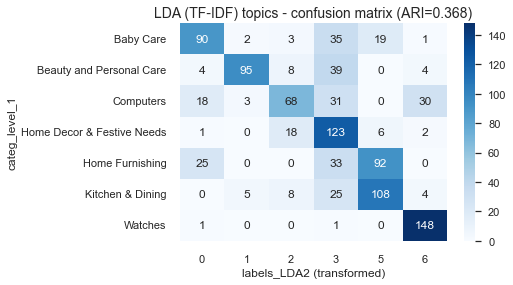

In [161]:
print(data_T['categ_level_1'].nunique())
print(data_T['labels_LDA2'].nunique())

ari_3b2 = plot_classification_metrics(
    data_T['categ_level_1'], data_T['labels_LDA2'])
plt.title(
    f'LDA (TF-IDF) topics - confusion matrix (ARI={ari_3b2:.3f})', fontsize=14)
to_png()


reducer t-SNE, input shape=(1050, 1352)
reducer t-SNE, shape =(1050, 2) time : 12.0
ARI :  0.4646 time :  1.0
0.4646
ARI :  0.3623
"LDA_sur_TF-IDF,_ARI_=_0-362.png"


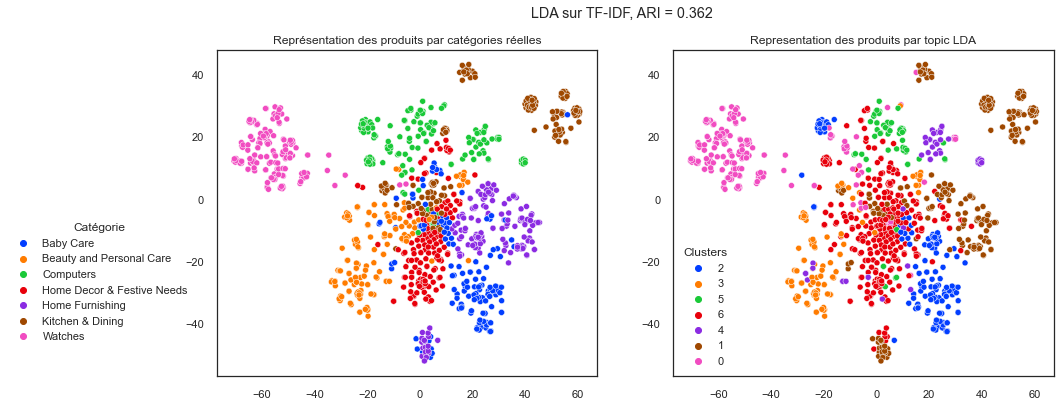

In [162]:
ARI3b2, X_tsne3b, labels3b = calc_tsne_cluster(tfidf_vectors)
print(ARI3b2)

fig = plot_clusters_sur_2D(X_tsne3b, y_cat_txt,
                           data_T['labels_LDA2'], ARI3b)
fig.axes[1].set_title('Representation des produits par topic LDA')
plt.suptitle(f'LDA sur TF-IDF, ARI = {ARI3b:.3f}')
to_png()


categ_level_1 clusters
(49, 3)
Index(['categ_level_1', 'variable', 'value'], dtype='object')


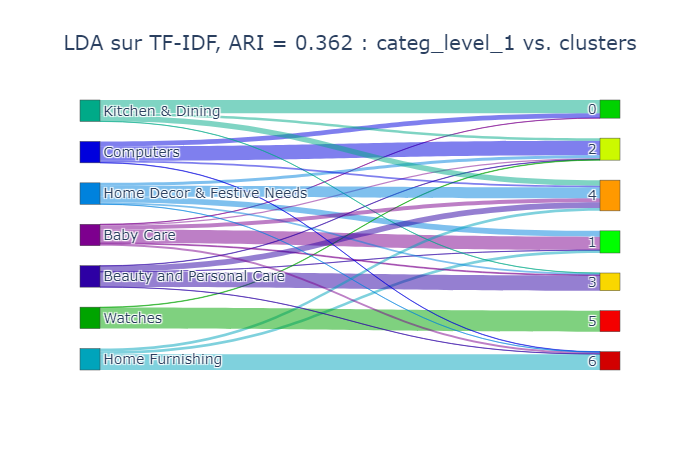

In [163]:

plot_sankey_confusion_diagram(y_cat_txt, labels3b,
                              titre=f'LDA sur TF-IDF, ARI = {ARI3b:.3f}')


Topic 1: watch, analog, men, woman, dial, sonata, boy, strap, maximum, resistant
Topic 2: mug, ceramic, towel, kadhai, abstract, blanket, single, double, cushion, quilt
Topic 3: baby, polyester, girl, eyelet, fabric, curtain, cotton, aroma, comfort, dress
Topic 4: combo, set, spf, denver, eye, kit, lip, cream, wild, deodorant
Topic 5: router, tenda, wireless, trendnet, asus, buddha, lipstick, yardley, wifi, extender
Topic 6: usb, led, light, bulb, port, hub, rice, apple, power, inch
Topic 7: showpiece, sticker, skin, laptop, vinyl, shape, inch, pad, mouse, print
"LDA_sur_bag-of-words,_top_10_mots_pour_chaque_topic.png"


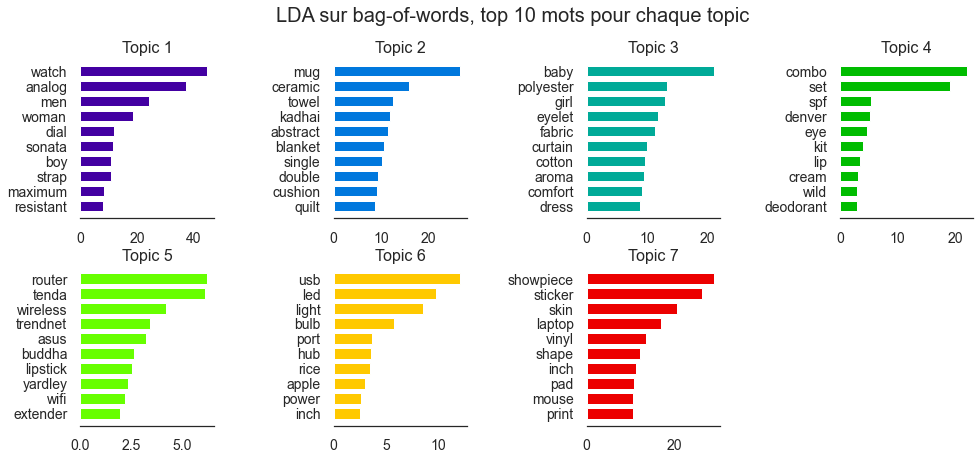

In [164]:

get_topic_words(model=model.best_estimator_,
                words=tfidf_vectorizer.get_feature_names_out())
plot_topic_words(model=model.best_estimator_, topics=tfidf_vectorizer.get_feature_names_out(),
                 titre='LDA sur bag-of-words, top 10 mots pour chaque topic')
to_png()


unique words: 905
unique words: 1243
unique words: 1104
unique words: 442
unique words: 121
unique words: 384
unique words: 3133
"LDA_sur_TF-IDF,_top_10_mots_pour_chaque_topic.png"


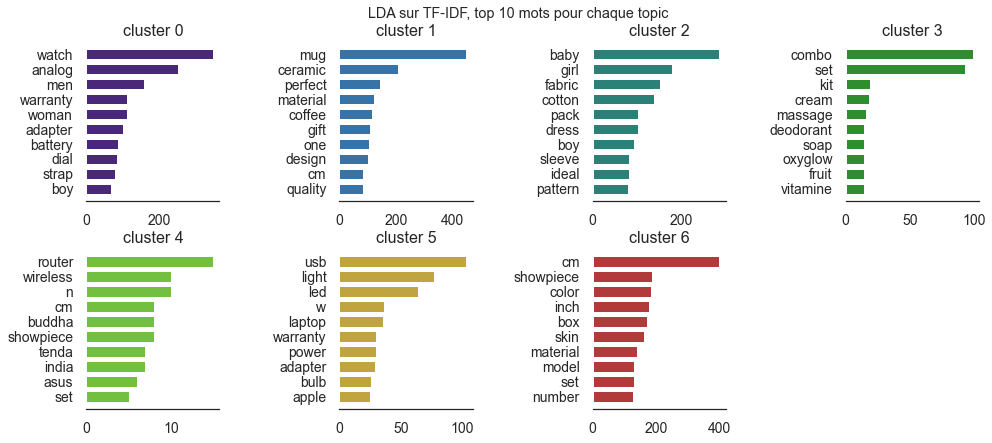

In [165]:
plot_top_words_from_data(
    data_T, feature='sentence_bow_lem', label_col='labels_LDA2', nb_words=10)
plt.suptitle('LDA sur TF-IDF, top 10 mots pour chaque topic')
to_png()


"LDA_sur_TF-IDF,_10_mots_plus_fréquents_dans_les_descriptions_des_produits_de_chaque_topic.png"


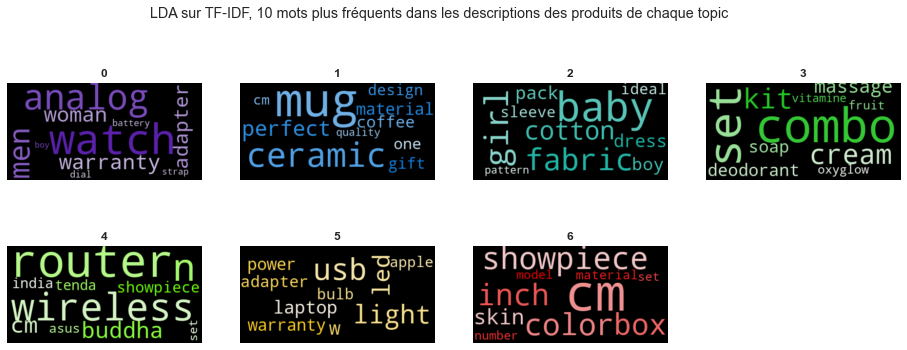

In [166]:
plot_wordclouds_by_categ(
    data_T, feature='sentence_bow_lem', categ_col='labels_LDA2', nb=10)
plt.suptitle(
    'LDA sur TF-IDF, 10 mots plus fréquents dans les descriptions des produits de chaque topic')
to_png()


### Prediction d'un topic


In [167]:
# from sklearn.decomposition import LatentDirichletAllocation

def predict_topic(text,
                  preprocessor=transform_bow_lem_fct,
                  feature_extractor=tfidf_vectorizer,
                  dimension_reducer=best_lda_model
                  ):

    # Step 1: Clean text and convert to words
    mytext_2 = transform_bow_lem_fct(text)
    print(mytext_2)

    # Step 2: Extract features
    if feature_extractor:
        # try:
        # feature_extractor.check_is_fitted()
        mytext_3 = feature_extractor.transform([mytext_2])
        # except:

        # return 'feature_extractor is not fitted'

    # Step 3: Reduce dimensions/predict Transform
    if isinstance(dimension_reducer, decomposition.LatentDirichletAllocation):
        topic_probability_scores = dimension_reducer.transform(mytext_3)
        topic = list(np.argmax(topic_probability_scores, axis=1))

        return topic, topic_probability_scores


print(predict_topic('analog watch battery'))
print(predict_topic('soap cream massage'))


analog watch battery
([0], array([[0.47535865, 0.04611937, 0.24792719, 0.04611895, 0.04611899,
        0.04611898, 0.04611895, 0.04611893]]))
soap cream massage
([3], array([[0.04576569, 0.0457661 , 0.04576528, 0.67964116, 0.04576528,
        0.04576528, 0.0457653 , 0.0457659 ]]))


# 7. Word2Vec

Word2vec est basé sur l'id

- <https://www.tensorflow.org/tutorials/text/word2vec>

## 7.1 Essaie 4 : Word2Vec sur phrases lemmatizes


In [168]:
# import tensorflow as tf

# from tensorflow.keras.preprocessing.sequence import pad_sequences

# from tensorflow.keras.models import Model
# for Word2Vec
# import gensim


### Création du modèle Word2Vec


In [169]:
# longueur des phrases
_ = calc_length_bow(data_T)


max length bow : 347
max length dl : 560


In [170]:
w2v_size = 300
w2v_window = 5
w2v_min_count = 1
w2v_epochs = 100
maxlen = 50  # adapt to length of sentences
sentences = data_T['sentence_bow_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]


In [171]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                   vector_size=w2v_size,
                                   seed=42,
                                   workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(
    sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")


Build & train Word2Vec model ...
Vocabulary size: 4931
Word2Vec trained


In [172]:
# fit a 2d PCA model to the vectors
X = w2v_model.wv.get_normed_vectors()
# pca = PCA(n_components=0.95)
# result = pca.fit_transform(X)

X_red = reducer_pca(X)


Dimensions avant réduction PCA : (4931, 300)
Dimensions après réduction PCA (99 % variance explained) : (4931, 83)


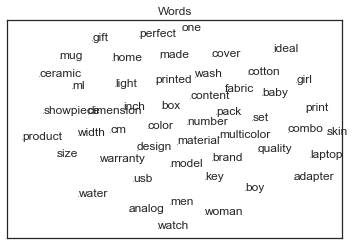

In [173]:
# from sklearn.manifold import TSNE

def plot_top_word_vectors(w2v_model_, X_, max_w=50):
    tsne_model = manifold.TSNE(perplexity=40, n_components=2,
                               init='pca', learning_rate=200, n_iter=1000, random_state=23)
    X_tsne = tsne_model.fit_transform(X_[:max_w, :])
    # Plot the t-SNE output
    _, ax = plt.subplots()
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], s=1)
    ax.set_title('Words')
    ax.grid(False)
    ax.set_yticklabels([])  # Hide ticks
    ax.set_xticklabels([])  # Hide ticks

    words = list(w2v_model_.wv.index_to_key)
    for i, word in enumerate(words):
        if i < max_w:
            plt.annotate(word, xy=(X_tsne[i, 0], X_tsne[i, 1]))
    plt.show()


plot_top_word_vectors(w2v_model, X, max_w=50)


In [174]:
keys = ['baby', 'soap', 'laptop', 'showpiece', 'curtain', 'kitchen', 'watch']
embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2v_model.wv.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(w2v_model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

tsne_model_en_2d = manifold.TSNE(
    perplexity=30, n_components=2, init='pca', learning_rate=200, n_iter=3500, random_state=32)
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16, 9))
    colors = sns.color_palette('Dark2', n_colors=len(labels)).as_hex()
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label, s=1)
        for i, word in enumerate(words):
            plt.annotate(word, color=color, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=20)
    plt.legend(loc=4)
    plt.grid(False)
    plt.show()
# tsne_plot_similar_words(keys, embeddings_en_2d, word_clusters)


reducer t-SNE, input shape=(70, 300)
reducer t-SNE, shape =(70, 2) time : 1.0
ARI :  -1 time :  1.0
-1
"Representation_des_top_mots_par_cluster.png"


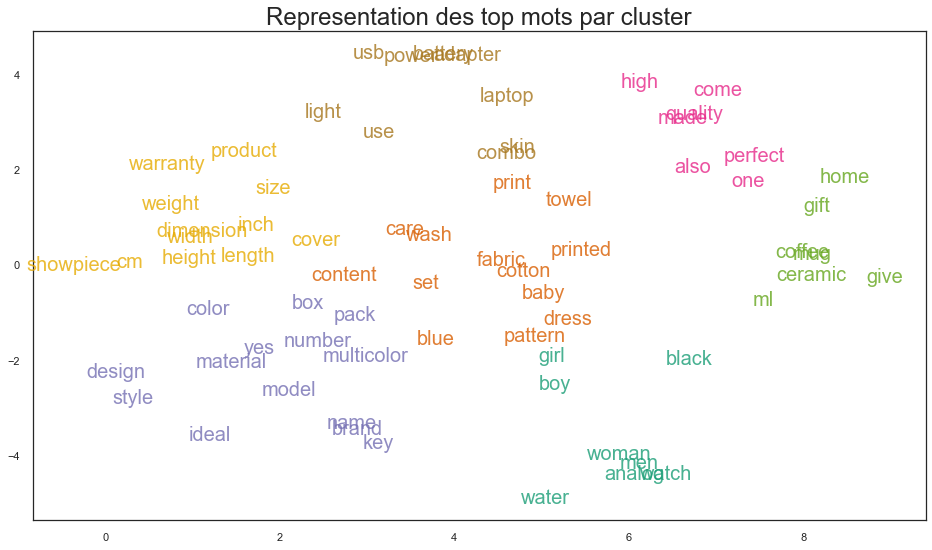

In [175]:
max_w = 70
ARI4a, X_tsne4a, labels4a = calc_tsne_cluster(X[:max_w, :])
print(ARI4a)

_, ax = plt.subplots(figsize=(16, 9))

sns.scatterplot(x=X_tsne4a[:, 0], y=X_tsne4a[:, 1],
                hue=labels4a, palette='Dark2', s=1, ax=ax, alpha=0.2, legend=None)

colors = sns.color_palette('Dark2', n_colors=len(labels)).as_hex()
words = list(w2v_model.wv.index_to_key)[:max_w]
i = 0

for word, label in zip(words, labels4a):
    plt.annotate(word, color=colors[label], alpha=0.8, size=20,
                 ha='center', va='center',
                 xy=(X_tsne4a[i, 0], X_tsne4a[i, 1]))
    i += 1

plt.grid(False)
plt.title('Representation des top mots par cluster', fontsize=24)
to_png()


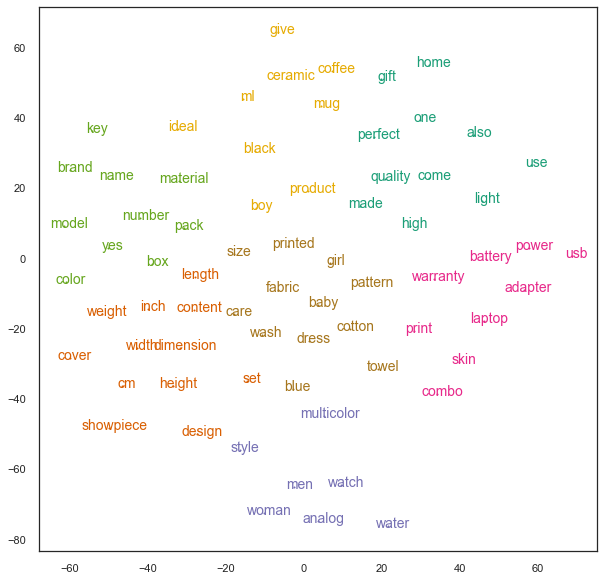

In [176]:
def tsne_plot(model, max_w=70):
    """Creates and TSNE model and plots it"""
    labels = []
    tokens = []

    # for word in model.wv:
    #     tokens.append(model.wv.get_vector(word))
    #     labels.append(word.index_to_key)

    tokens_all = model.wv.get_normed_vectors()
    labels_all = model.wv.index_to_key

    tokens = tokens_all[:max_w]
    labels = labels_all[:max_w]

    tsne_model = manifold.TSNE(
        perplexity=40, n_components=2, learning_rate=200, n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    clf = cluster.KMeans(n_clusters=7)
    clf.fit(new_values)
    label_color_id = clf.labels_
    colors = sns.color_palette('Dark2', n_colors=7)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(10, 10))
    for i in range(len(x)):
        plt.scatter(x[i], y[i], color=colors[label_color_id[i]], s=1)
        plt.annotate(labels[i],
                     color=colors[label_color_id[i]],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     fontsize=14,
                     ha='center',
                     va='center')
    plt.grid(False)
    # plt.show()

    # Add the word to the groups and focus on specific sets.


tsne_plot(w2v_model)


### Préparation des sentences (tokenization)


In [177]:
print("Fit Tokenizer ...")
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = tf.keras.preprocessing.sequence.pad_sequences(
    tokenizer.texts_to_sequences(sentences),
    maxlen=maxlen, padding='post')

num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)


Fit Tokenizer ...
Number of unique words: 4932


## Création de la matrice d'embedding


In [178]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
# w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i = 0
j = 0

for word, idx in word_index.items():
    i += 1
    if word in w2v_words:
        j += 1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]

word_rate = np.round(j/i, 4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))


Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (4932, 300)


In [179]:
for i, key in enumerate(word_index.keys()):
    if i < 5:
        print(f'{key} : {word_index[key]}')


cm : 1
mug : 2
watch : 3
color : 4
baby : 5


## Création du modèle d'embedding


In [180]:
# Création du modèle

# input = tf.keras.layers.Input(shape=(len(x_sentences), maxlen), dtype='float64')
word_input = tf.keras.layers.Input(shape=(maxlen,), dtype='float64')
word_embedding = tf.keras.layers.Embedding(input_dim=vocab_size,
                                           output_dim=w2v_size,
                                           weights=[embedding_matrix],
                                           input_length=maxlen)(word_input)
word_vec = tf.keras.layers.GlobalAveragePooling1D()(word_embedding)
embed_model = tf.keras.models.Model([word_input], word_vec)

embed_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 300)           1479600   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 1,479,600
Trainable params: 1,479,600
Non-trainable params: 0
_________________________________________________________________


## Exécution du modèle


In [181]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape


(1050, 300)

In [182]:
ARI4, X_tsne4, labels4 = calc_tsne_cluster(embeddings)
# add to global scores
df_resultats = add_model_score(
    model_name='Word2Vec', ARI=ARI4, k=pd.Series(labels4).nunique())
data_T['labels_W2V'] = labels4


reducer t-SNE, input shape=(1050, 300)
reducer t-SNE, shape =(1050, 2) time : 14.0
ARI :  0.4816 time :  1.0


#### Evaluation metrics


Correspondance des clusters :  [1 3 6 0 2 5 4]
ARI = 0.482
                            precision    recall  f1-score   support

                 Baby Care       0.48      0.67      0.56       150
  Beauty and Personal Care       0.78      0.72      0.75       150
                 Computers       0.63      0.91      0.74       150
Home Decor & Festive Needs       0.81      0.67      0.73       150
           Home Furnishing       0.66      0.64      0.65       150
          Kitchen & Dining       0.97      0.42      0.59       150
                   Watches       0.99      0.99      0.99       150

                  accuracy                           0.72      1050
                 macro avg       0.76      0.72      0.72      1050
              weighted avg       0.76      0.72      0.72      1050

"Word2Vec_-_confusion_matrix_(ARI=0-482).png"


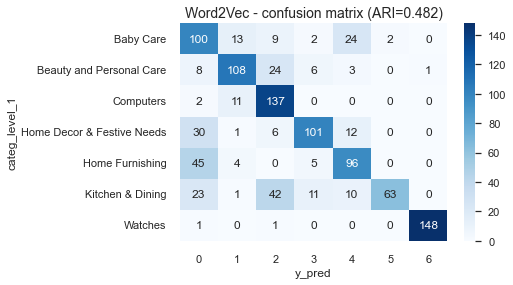

In [183]:
ari_4 = plot_classification_metrics(data_T['categ_level_1'], labels4)
plt.title(f'Word2Vec - confusion matrix (ARI={ari_4:.3f})', fontsize=14)
to_png()


ARI :  0.4816
"Word2Vec,_ARI_=_0-482.png"


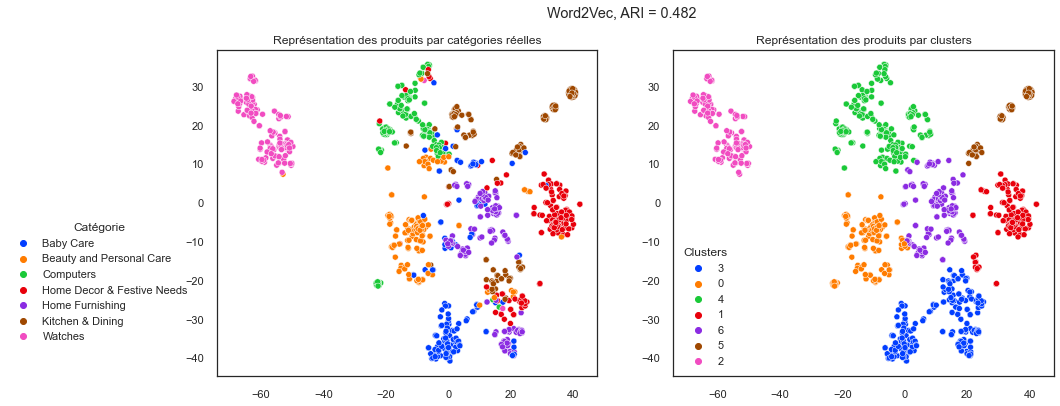

In [184]:
fig = plot_clusters_sur_2D(X_tsne4, y_cat_txt, labels4, ARI4)
plt.suptitle(f'Word2Vec, ARI = {ARI4:.3f}')
to_png()


In [185]:
# cleanup keras model
del embed_model
del embeddings
tf.keras.backend.clear_session()


# 8. BERT


In [186]:

# from transformers import AutoTokenizer
# import os
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.preprocessing.text import Tokenizer
# import tensorflow as tf
# import tensorflow_hub as hub

print(tf.keras.__version__)

# Bert
# from transformers import *

os.environ["TF_KERAS"] = '1'


2.8.0


In [187]:

print(tf.__version__)
print("Num GPUs Available: ", len(
    tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())


2.8.0
Num GPUs Available:  0
True


## 8.1 BERT - Fonctions communes


In [188]:
# import time
# import transformers

# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length):
    input_ids = []
    token_type_ids = []
    attention_mask = []
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens=True,
                                              max_length=max_length,
                                              padding='max_length',
                                              return_attention_mask=True,
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")

        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0],
                             bert_inp['token_type_ids'][0],
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)

    return input_ids, token_type_ids, attention_mask, bert_inp_tot


# Fonction de création des features
def feature_BERT_fct(model, model_type: str, sentences, max_length, b_size, mode='HF'):
    """Fonction de création des features"""
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = transformers.AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size):
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size],
                                                                               bert_tokenizer, max_length)

        if mode == 'HF':    # Bert HuggingFace
            outputs = model.predict(
                [input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode == 'TFhub':  # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids": input_ids,
                                 "input_mask": attention_mask,
                                 "input_type_ids": token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']

        if step == 0:
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else:
            last_hidden_states_tot = np.concatenate(
                (last_hidden_states_tot, last_hidden_states))

    features_bert = np.array(last_hidden_states_tot).mean(axis=1)

    time2 = np.round(time.time() - time1, 0)
    print("temps traitement : ", time2)

    return features_bert, last_hidden_states_tot


## 8.2 Essaie 5 : BERT HuggingFace


### Model 'bert-base-uncased'

- Downloads 511 Mb pretrained model


In [189]:
# from transformers import TFAutoModel

max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = transformers.TFAutoModel.from_pretrained(model_type)
sentences = data_T['sentence_dl'].to_list()


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [190]:
# Création des features
# downloads bert features
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,
                                                         max_length, batch_size, mode='HF')


temps traitement :  147.0


In [191]:
ARI5, X_tsne5, labels5 = calc_tsne_cluster(features_bert)
# add to global scores
df_resultats = add_model_score(
    model_name='Bert HuggingFace', ARI=ARI5, k=pd.Series(labels5).nunique())
data_T['labels_berthf'] = labels5


reducer t-SNE, input shape=(1050, 768)
reducer t-SNE, shape =(1050, 2) time : 14.0
ARI :  0.389 time :  1.0


#### Evaluation metrics


Correspondance des clusters :  [5 1 6 3 2 0 2]
ARI = 0.407
                            precision    recall  f1-score   support

                 Baby Care       0.63      0.69      0.66       150
  Beauty and Personal Care       0.45      0.51      0.48       150
                 Computers       0.61      0.98      0.75       150
Home Decor & Festive Needs       0.53      0.54      0.53       150
           Home Furnishing       0.00      0.00      0.00       150
          Kitchen & Dining       0.44      0.53      0.48       150
                   Watches       1.00      0.94      0.97       150

                  accuracy                           0.60      1050
                 macro avg       0.52      0.60      0.55      1050
              weighted avg       0.52      0.60      0.55      1050

"Bert_HuggingFace_-_confusion_matrix_(ARI=0-407).png"


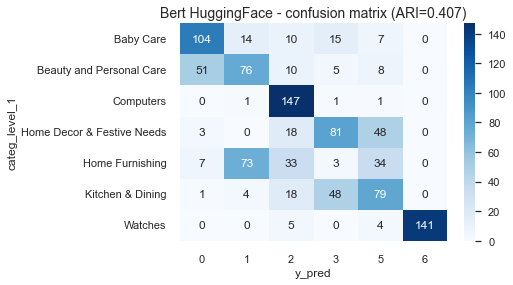

In [192]:
ari_5 = plot_classification_metrics(data_T['categ_level_1'], labels5)
plt.title(
    f'Bert HuggingFace - confusion matrix (ARI={ari_5:.3f})', fontsize=14)
to_png()


ARI :  0.389
"BERT_HuggingFace,_ARI_=_0-389.png"


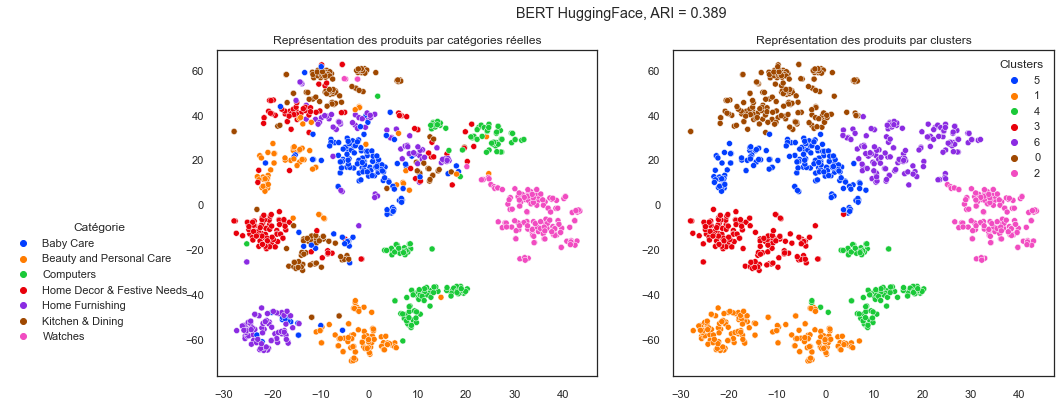

In [193]:
plot_clusters_sur_2D(X_tsne5, y_cat_txt, labels5, ARI5)
plt.suptitle(f'BERT HuggingFace, ARI = {ARI5:.3f}')
to_png()


In [194]:
# cleanup keras model
del model
del features_bert
tf.keras.backend.clear_session()


## 8.3 Essaie 6 : BERT hub Tensorflow


In [195]:
# import tensorflow_hub as hub


# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
# downloads 500Mb de model
small_model_url = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = tensorflow_hub.KerasLayer(model_url, trainable=True)


In [196]:
sentences = data_T['sentence_dl'].to_list()


In [197]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,
                                                         max_length, batch_size, mode='TFhub')


temps traitement :  157.0


In [198]:
ARI6, X_tsne6, labels6 = calc_tsne_cluster(features_bert)
# add to global scores
df_resultats = add_model_score(
    model_name='BERT Hub (base uncased)', ARI=ARI6, k=pd.Series(labels6).nunique())
data_T['labels_berthub'] = labels6


reducer t-SNE, input shape=(1050, 768)
reducer t-SNE, shape =(1050, 2) time : 18.0
ARI :  0.3586 time :  2.0


#### Evaluation metrics (BERT uncased)


Correspondance des clusters :  [5 3 2 6 2 4 0]
ARI = 0.344
                            precision    recall  f1-score   support

                 Baby Care       0.61      0.71      0.66       150
  Beauty and Personal Care       0.00      0.00      0.00       150
                 Computers       0.45      0.84      0.58       150
Home Decor & Festive Needs       0.47      0.54      0.50       150
           Home Furnishing       0.68      0.49      0.57       150
          Kitchen & Dining       0.47      0.53      0.50       150
                   Watches       0.98      0.94      0.96       150

                  accuracy                           0.58      1050
                 macro avg       0.52      0.58      0.54      1050
              weighted avg       0.52      0.58      0.54      1050

"Bert_base_uncased_-_confusion_matrix_(ARI=0-344).png"


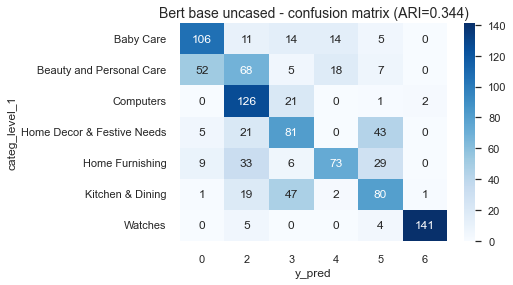

In [199]:
ari_6 = plot_classification_metrics(data_T['categ_level_1'], labels6)
plt.title(
    f'Bert base uncased - confusion matrix (ARI={ari_6:.3f})', fontsize=14)
to_png()


ARI :  0.3586
BERT model_url : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
"BERT_Hub_(base_uncased),_ARI_=_0-359.png"


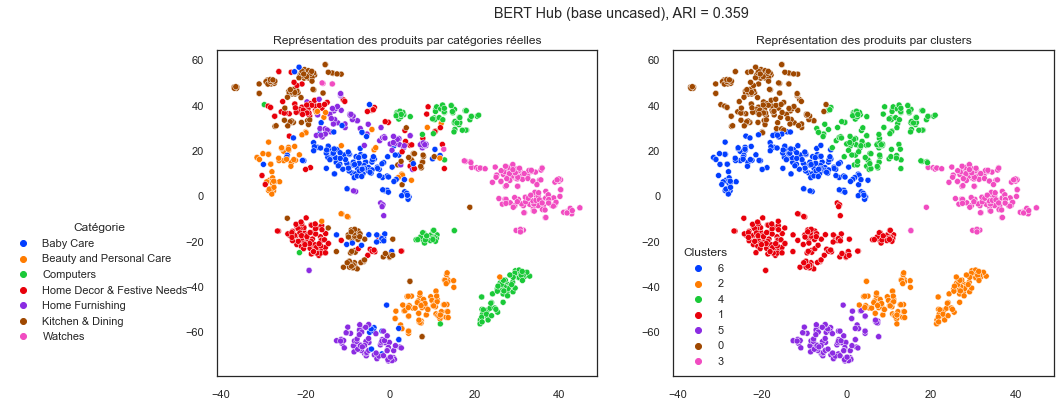

In [200]:
plot_clusters_sur_2D(X_tsne6, y_cat_txt, labels6, ARI6)
print(f'BERT model_url : {model_url}')
plt.suptitle(f'BERT Hub (base uncased), ARI = {ARI6:.3f}')

to_png()


In [201]:
# cleanup keras model
del model
del bert_layer
del features_bert
tf.keras.backend.clear_session()


# 9. USE - Universal Sentence Encoder

## 9.1 Essaie 7 : USE - Universal Sentence Encoder


In [202]:
# import tensorflow as tf

# Bert
# import transformers
os.environ["TF_KERAS"] = '1'


In [203]:

print(tf.__version__)
print("Num GPUs Available: ", len(
    tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())


2.8.0
Num GPUs Available:  0
True


In [204]:
# import tensorflow_hub as hub
USE_model_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
# 1Gb model
embed = tensorflow_hub.load(USE_model_url)


In [205]:
def feature_USE_fct(sentences, b_size):
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size):
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step == 0:
            features = feat
        else:
            features = np.concatenate((features, feat))

    time2 = np.round(time.time() - time1, 0)
    print(f'feature_USE_fct, time_taken = {time2} s')
    return features


In [206]:
batch_size = 10
sentences = data_T['sentence_dl'].to_list()


In [207]:
features_USE = feature_USE_fct(sentences, batch_size)


feature_USE_fct, time_taken = 2.0 s


In [208]:
ARI7, X_tsne7, labels7 = calc_tsne_cluster(features_USE)
# add to global scores
df_resultats = add_model_score(
    model_name='BERT Hub (base uncased)', ARI=ARI7, k=pd.Series(labels7).nunique())
data_T['labels_USE'] = labels7


reducer t-SNE, input shape=(1050, 512)
reducer t-SNE, shape =(1050, 2) time : 13.0
ARI :  0.4627 time :  1.0


#### Evaluation metrics (USE)


Correspondance des clusters :  [6 4 2 3 1 0 4]
ARI = 0.443
                            precision    recall  f1-score   support

                 Baby Care       0.93      0.62      0.74       150
  Beauty and Personal Care       0.54      0.51      0.52       150
                 Computers       0.80      0.68      0.73       150
Home Decor & Festive Needs       0.49      0.69      0.58       150
           Home Furnishing       0.45      0.95      0.61       150
          Kitchen & Dining       0.00      0.00      0.00       150
                   Watches       0.99      1.00      0.99       150

                  accuracy                           0.64      1050
                 macro avg       0.60      0.64      0.60      1050
              weighted avg       0.60      0.64      0.60      1050

"Universal_Sentence_Encoder_-_confusion_matrix_(ARI=0-443).png"


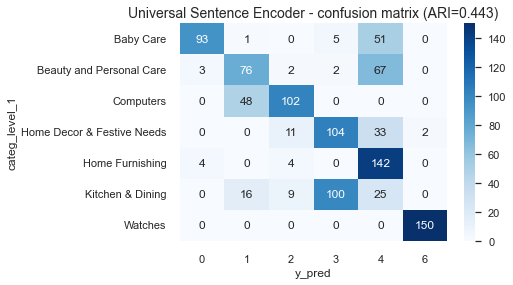

In [209]:
ari_7 = plot_classification_metrics(data_T['categ_level_1'], labels7)
plt.title(
    f'Universal Sentence Encoder - confusion matrix (ARI={ari_7:.3f})', fontsize=14)
to_png()


ARI :  0.4627
USE model_url : https://tfhub.dev/google/universal-sentence-encoder/4
"USE_-_Universal_Sentence_Encoder,_ARI_=_0-463.png"


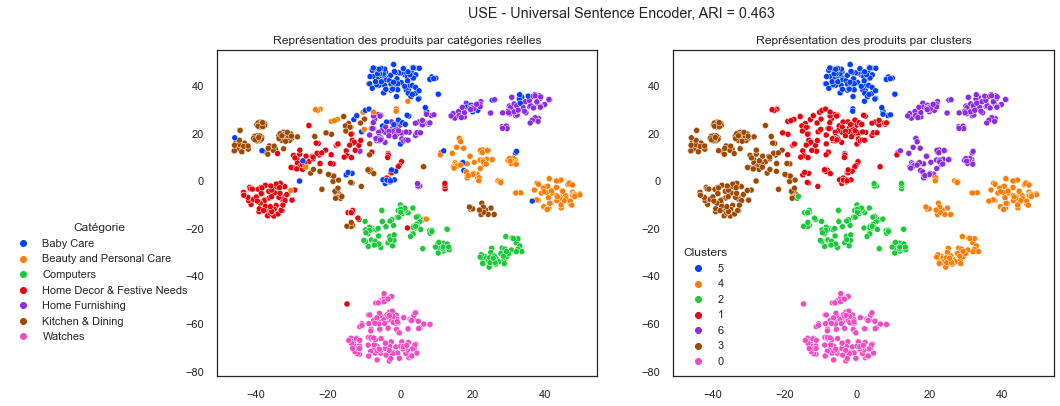

In [210]:
plot_clusters_sur_2D(X_tsne7, y_cat_txt, labels7, ARI7)

USE_model_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
print(f'USE model_url : {USE_model_url}')
plt.suptitle(f'USE - Universal Sentence Encoder, ARI = {ARI7:.3f}')
to_png()


In [212]:
# cleanup keras model
del embed
del features_USE
tf.keras.backend.clear_session()


# 10. Supervised labelling avec un réseau neuronal simple

Le meilleur score (plus rapide) a été avec TF-IDF

On va entrainer un réseau neuronal pour voir si on peut améliorer les prédictions

Note : ce modèle utilise un vocabulaire très limité à nos échantillons, et peut-être ne peux pas généraliser à d'autres produits.

Si c'est le cas, il faut remplacer le tokenizer par un Embedding Layer comme dans le model Word2Vec ci-dessous. Dans ce cas, on peut faire du Transfer Learning


In [213]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.preprocessing.text import Tokenizer

# from sklearn.preprocessing import LabelEncoder
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.model_selection import train_test_split

# Top 1000 mots present dans un minimum de 3 produits
# tfidf_vectorizer = TfidfVectorizer(max_features=1000,
# stop_words='english', min_df=3)

# On applique au sentence crée à partir de bag-of-words avec lemmatization
# feature = 'sentence_bow_lem'
# tfidf_vectors = tfidf_vectorizer.fit_transform(data_T[feature])


# documents = data_T['description']
# documents = data_T['sentence_dl']
documents = data_T['sentence_bow_lem']
labels = data_T['categ_level_1']

# train_documents,test_documents, train_labels, test_labels= train_test_split(documents,labels, stratify=labels,train_size=0.8)
train_documents, test_documents, train_labels, test_labels = train_test_split(
    documents, labels, train_size=0.8)

# preprocess
# Avec TF-IDF, on a besoin de créer un grand matrix éparse des fréquences des mots
# Pour cette etude, ça marche
# Mais si on avait 50000 produits, peut-être le top 1000 terms ne suffit pas pour les grouper
vocab_size = 1000
tokenize = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size)
tokenize.fit_on_texts(train_documents)

# word_frequencies
x_train = tokenize.texts_to_matrix(train_documents, mode='tfidf')
x_test = tokenize.texts_to_matrix(test_documents, mode='tfidf')
print(x_train.shape)


encoder = preprocessing.LabelEncoder()
encoder.fit(train_labels)
y_train = encoder.transform(train_labels)
y_test = encoder.transform(test_labels)
num_labels = labels.nunique()

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(
    512, input_shape=(vocab_size,), activation='relu'))
model.add(tf.keras.layers.Dense(num_labels, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


(840, 1000)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               512512    
                                                                 
 dense_1 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 516,103
Trainable params: 516,103
Non-trainable params: 0
_________________________________________________________________


In [214]:
history = model.fit(x_train, y_train,
                    batch_size=16,
                    epochs=10,
                    verbose=1,
                    validation_data=(x_test, y_test))


Epoch 1/10
53/53 [==============================] - 1s 8ms/step - loss: 0.8524 - accuracy: 0.7714 - val_loss: 0.4899 - val_accuracy: 0.9048
Epoch 2/10
53/53 [==============================] - 0s 4ms/step - loss: 0.1692 - accuracy: 0.9702 - val_loss: 0.4031 - val_accuracy: 0.9143
Epoch 3/10
53/53 [==============================] - 0s 5ms/step - loss: 0.0997 - accuracy: 0.9917 - val_loss: 0.3884 - val_accuracy: 0.9000
Epoch 4/10
53/53 [==============================] - 0s 4ms/step - loss: 0.0717 - accuracy: 0.9940 - val_loss: 0.3935 - val_accuracy: 0.8905
Epoch 5/10
53/53 [==============================] - 0s 4ms/step - loss: 0.0561 - accuracy: 0.9952 - val_loss: 0.3949 - val_accuracy: 0.8857
Epoch 6/10
53/53 [==============================] - 0s 4ms/step - loss: 0.0459 - accuracy: 0.9952 - val_loss: 0.4017 - val_accuracy: 0.8810
Epoch 7/10
53/53 [==============================] - 0s 5ms/step - loss: 0.0395 - accuracy: 0.9952 - val_loss: 0.4047 - val_accuracy: 0.8762
Epoch 8/10
53/53 [==

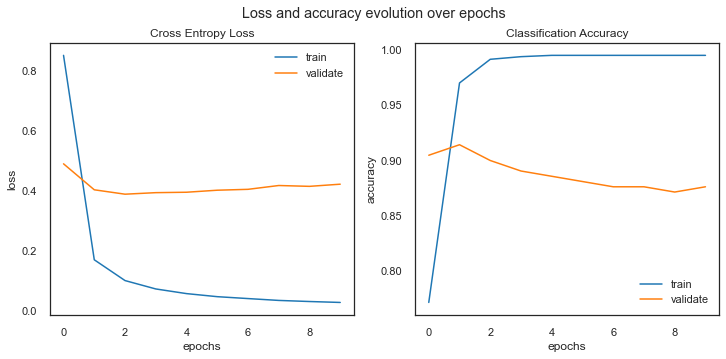

In [215]:

def plot_diagnostic_learning_curves(history):
    """Plot summary diagnostics from history of model training"""
    colors = sns.color_palette('tab10')
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    # plot loss
    ax1 = axs[0]
    ax1.set_title('Cross Entropy Loss')
    ax1.plot(history.history['loss'], c=colors[0], label='train')
    ax1.plot(history.history['val_loss'], c=colors[1], label='validate')
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('loss')
    ax1.legend()
    # plot accuracy
    ax2 = axs[1]
    ax2.set_title('Classification Accuracy')
    ax2.plot(history.history['accuracy'], c=colors[0], label='train')
    ax2.plot(history.history['val_accuracy'], c=colors[1], label='validate')
    ax2.legend()
    ax2.set_xlabel('epochs')
    ax2.set_ylabel('accuracy')
    fig.suptitle('Loss and accuracy evolution over epochs')


plot_diagnostic_learning_curves(history)


In [216]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])


21/21 [==============================] - 0s 1ms/step - loss: 0.4218 - accuracy: 0.8762
Test score: 0.42182502150535583
Test accuracy: 0.8761904835700989


### Calculate predicted labels


In [217]:
predictions = pd.DataFrame({})
for i in range(5):
    prediction = model.predict(np.array([x_test[i]]))
    print(prediction)
    print(np.argmax(prediction[0]))
    text_labels = encoder.classes_
    predicted_label = encoder.inverse_transform(
        [np.argmax(prediction[0]).sum()])
    predicted_weight = np.round(100 * prediction[0].max(), 2)
    print(test_documents.iloc[i][:50], "...")
    print(f'Actual label: {test_labels.iloc[i]}')
    print(f'Predicted label: {predicted_label} ({predicted_weight:.0f}%)')


[[5.1528611e-13 2.6127900e-15 3.7234286e-13 3.4577158e-15 4.2423200e-15
  1.0000000e+00 3.8439791e-15]]
5
prithish better husband double color ceramic mug m ...
Actual label: Kitchen & Dining
Predicted label: ['Kitchen & Dining'] (100%)
[[7.5237833e-02 5.4330099e-03 4.7214939e-03 4.6095042e-03 9.0144777e-01
  7.6687490e-03 8.8162482e-04]]
4
art box floral single dohar multicolor ...
Actual label: Home Furnishing
Predicted label: ['Home Furnishing'] (90%)
[[2.0103459e-03 9.8790514e-01 4.4108131e-03 8.4197178e-04 3.6798427e-03
  8.0515508e-04 3.4677656e-04]]
1
nike original combo set ...
Actual label: Beauty and Personal Care
Predicted label: ['Beauty and Personal Care'] (99%)
[[5.3126219e-04 2.1921685e-03 9.9589539e-01 4.6862109e-04 4.6820921e-04
  3.0077621e-04 1.4362051e-04]]
2
rega gateway md md mdu cell laptop battery ...
Actual label: Computers
Predicted label: ['Computers'] (100%)
[[1.2810976e-04 3.3451524e-04 9.9932361e-01 4.1822601e-05 9.5176314e-05
  6.4969012e-05 1.1845024e-05

In [218]:
def calc_pred_label(x_, model_, encoder_, documents_):
    predictions = np.array(model_.predict(x_))
    text_labels = encoder_.classes_

    # print(predictions[:4])
    predicted_labels = []
    predicted_weights = []
    for i, prediction in enumerate(predictions):
        predicted_label = text_labels[np.argmax(prediction)]
        predicted_labels.append(predicted_label)
        predicted_weights.append(np.round(np.max(prediction)*100, 2))

    pred_labels = pd.Series(
        predicted_labels, index=documents_.index).rename('predicted')
    pred_weights = pd.Series(
        predicted_weights, index=documents_.index).rename('pred_weight')
    return pred_labels, pred_weights


test_pred_labels, test_pred_weights = calc_pred_label(
    x_test, model, encoder, test_documents)
train_pred_labels, train_pred_weights = calc_pred_label(
    x_train, model, encoder, train_documents)

print(list(test_pred_labels[:10]))
print(list(test_labels[:10]))


['Kitchen & Dining', 'Home Furnishing', 'Beauty and Personal Care', 'Computers', 'Computers', 'Watches', 'Beauty and Personal Care', 'Kitchen & Dining', 'Home Furnishing', 'Home Decor & Festive Needs']
['Kitchen & Dining', 'Home Furnishing', 'Beauty and Personal Care', 'Computers', 'Computers', 'Watches', 'Beauty and Personal Care', 'Kitchen & Dining', 'Home Decor & Festive Needs', 'Home Decor & Festive Needs']


In [219]:
ARI8 = calc_ARI(test_labels, test_pred_labels)
print(ARI8)
df_resultats = add_model_score(model_name='supervised TF-IDF', ARI=ARI8, k=7)


0.7244


#### Evaluation metrics - TF-IDF supervisée


Correspondance des clusters :  [0 1 2 3 4 5 6]
ARI = 0.724
                            precision    recall  f1-score   support

                 Baby Care       0.74      0.85      0.79        33
  Beauty and Personal Care       0.84      0.87      0.85        30
                 Computers       0.83      1.00      0.91        24
Home Decor & Festive Needs       0.90      0.82      0.86        33
           Home Furnishing       0.97      0.79      0.87        39
          Kitchen & Dining       0.92      0.92      0.92        26
                   Watches       1.00      0.96      0.98        25

                  accuracy                           0.88       210
                 macro avg       0.88      0.89      0.88       210
              weighted avg       0.88      0.88      0.88       210

"TF-IDF_supervisée_-_confusion_matrix_(ARI=0-724).png"


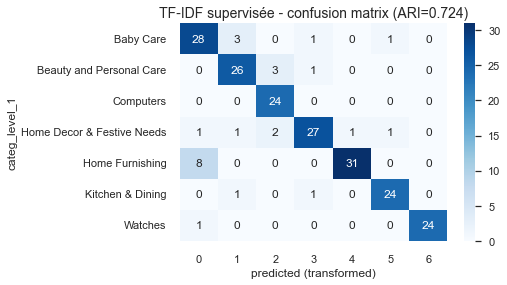

In [220]:
ari_8 = plot_classification_metrics(test_labels, test_pred_labels)
plt.title(
    f'TF-IDF supervisée - confusion matrix (ARI={ari_8:.3f})', fontsize=14)
to_png()


categ_level_1 predicted
(49, 3)
Index(['categ_level_1', 'variable', 'value'], dtype='object')


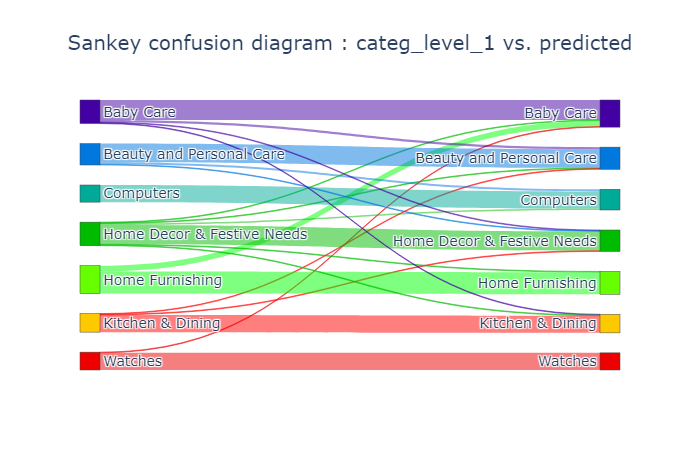

In [221]:

plot_sankey_confusion_diagram(source=test_labels, target=test_pred_labels)


In [222]:
conf_matrix_labels(test_labels, test_pred_labels).style.background_gradient()


### Misclassified texts

On regroupe les données train et test pour voir des misclassifications


In [223]:
pred_labels = pd.concat([test_pred_labels, train_pred_labels], axis=0)
pred_weights = pd.concat([test_pred_weights, train_pred_weights], axis=0)


In [224]:
df_pred = pd.concat([labels, pred_labels, pred_weights], axis=1).join(
    documents).join(data_T['description'])
df_pred.head()


categ_level_1        predicted  pred_weight  \
0  Home Furnishing  Home Furnishing       100.00   
1        Baby Care        Baby Care        95.29   
2        Baby Care        Baby Care       100.00   
3  Home Furnishing  Home Furnishing       100.00   
4  Home Furnishing  Home Furnishing       100.00   

                                                                                      sentence_bow_lem  \
0  key elegance polyester multicolor abstract eyelet door curtain floral curtainelegance polyester ...   
1  sathiyas cotton bath towel bath towel red yellow blue bath towel machine washable yes material c...   
2  key eurospa cotton terry face towel set size small height inch gsm eurospa cotton terry face tow...   
3  key santosh royal fashion cotton printed king sized double bedsheet royal bedsheet perfact weddi...   
4  key jaipur print cotton floral king sized double bedsheet cottonjaipur print cotton floral king ...   

                                                                                           description  
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...  
1  Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...  
2  Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa ...  
3  Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet P...  
4  Key Features of Jaipur Print Cotton Floral King sized Double Bedsheet 100% cotton,Jaipur Print C...

In [225]:
misclassified = df_pred['categ_level_1'] != df_pred['predicted']
print(misclassified.sum())
df_pred[misclassified].head()


30


categ_level_1                 predicted  pred_weight  \
7                       Watches                 Baby Care        68.12   
36   Home Decor & Festive Needs  Beauty and Personal Care       100.00   
80   Home Decor & Festive Needs          Kitchen & Dining        45.09   
114                   Baby Care  Beauty and Personal Care        41.83   
250  Home Decor & Festive Needs                 Computers        58.03   

                                                                                        sentence_bow_lem  \
7    star ufttswbkbr analog watch boy whether way work travelling abroad family lifestyle accessory l...   
36   myesquire ceramic burner pot lemongrass liquid air freshener ml illuminate every corner living r...   
80   key vareesha wooden key holder hand made using wrought iron mango wood color brown material shee...   
114                                                   offering lollipop lane tiddly wink safari bath set   
250                                                                                  true bong true bong   

                                                                                             description  
7    T STAR UFT-TSW-005-BK-BR Analog Watch  - For Boys\r\n                         Price: Rs. 399\r\n...  
36   Myesquire Ceramic Burner Pot Lemongrass Liquid Air Freshener (30 ml)\r\n                        ...  
80   Key Features of VarEesha Wooden Key Holder Hand made using wrought iron and mango wood Color - B...  
114  Flipkart.com is offering Lollipop Lane Tiddly Wink Safari Bath Set for only for Rs 2950 | Flipka...  
250  Buy TRUE Bong for Rs.549 online. TRUE Bong at best prices with FREE shipping & cash on delivery....

Sans l'image, il sera difficile pour un human de classifier ces items. Donc ce n'est pas nécessairement intéressant de faire du transfert learning sur ces items.


In [226]:
# cleanup
del model
tf.keras.backend.clear_session()


### Classification Supervisée avec propre Word Embeddings

Note : utilisant seulement le vocabulaire des documents présent, on crée un 'overfit' (beaucoup de biais) sur les produits déjà présents.

Pourtant, si on n'arrive pas à classifier un item automatiquement via unsupervised classification (text+ images), on peut utiliser ce modèle pour proposer une catégorie / sous-catégorie plus probable

- https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/


In [227]:
# sequences ready for word_embedding input
x_train_for_embed = tokenize.texts_to_sequences(train_documents)
x_test_for_embed = tokenize.texts_to_sequences(test_documents)

max_words = 50
x_train = tf.keras.preprocessing.sequence.pad_sequences(
    x_train_for_embed, maxlen=max_words)
x_test = tf.keras.preprocessing.sequence.pad_sequences(
    x_test_for_embed, maxlen=max_words)
embedding_dim = 4
print(x_train.shape)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(
    vocab_size, embedding_dim, input_length=max_words))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(7, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


(840, 50)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 4)             4000      
                                                                 
 flatten (Flatten)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 7)                 1407      
                                                                 
Total params: 5,407
Trainable params: 5,407
Non-trainable params: 0
_________________________________________________________________


In [228]:

history = model.fit(x_train, y_train,
                    batch_size=16,
                    epochs=100,
                    verbose=0,
                    validation_data=(x_test, y_test))


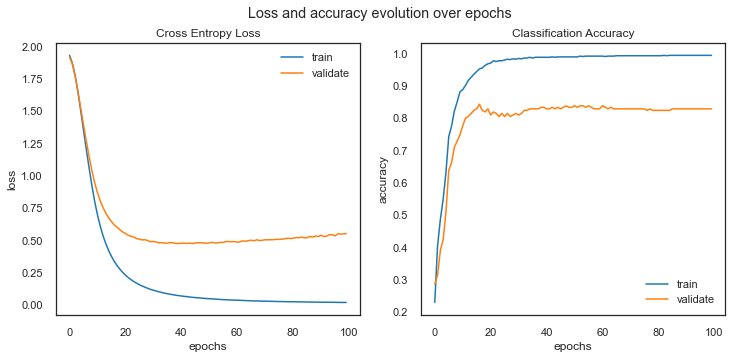

In [229]:
plot_diagnostic_learning_curves(history)


In [230]:
test_pred_labels, test_pred_weights = calc_pred_label(
    x_test, model, encoder, test_documents)
train_pred_labels, train_pred_weights = calc_pred_label(
    x_train, model, encoder, train_documents)

print(list(test_pred_labels[:10]))
print(list(test_labels[:10]))


['Kitchen & Dining', 'Home Furnishing', 'Beauty and Personal Care', 'Computers', 'Computers', 'Watches', 'Beauty and Personal Care', 'Kitchen & Dining', 'Home Decor & Festive Needs', 'Home Decor & Festive Needs']
['Kitchen & Dining', 'Home Furnishing', 'Beauty and Personal Care', 'Computers', 'Computers', 'Watches', 'Beauty and Personal Care', 'Kitchen & Dining', 'Home Decor & Festive Needs', 'Home Decor & Festive Needs']


#### Evaluation metrics - Word Embedding supervisée


Correspondance des clusters :  [0 1 2 3 4 5 6]
ARI = 0.640
                            precision    recall  f1-score   support

          Kitchen & Dining       0.68      0.79      0.73        33
           Home Furnishing       0.79      0.77      0.78        30
  Beauty and Personal Care       0.79      0.96      0.87        24
                 Computers       0.91      0.88      0.89        33
                   Watches       0.87      0.69      0.77        39
Home Decor & Festive Needs       0.81      0.85      0.83        26
                 Baby Care       1.00      0.96      0.98        25

                  accuracy                           0.83       210
                 macro avg       0.84      0.84      0.84       210
              weighted avg       0.84      0.83      0.83       210

"Word_Embedding_supervisée_-_confusion_matrix_(ARI=0-640).png"


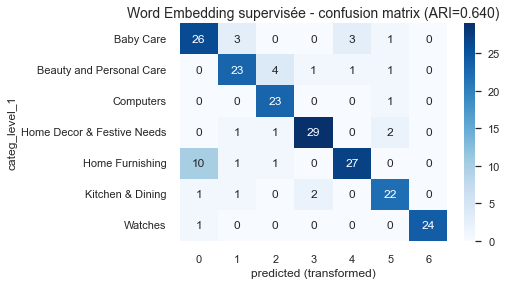

In [231]:

ari_9 = plot_classification_metrics(
    test_labels, test_pred_labels, target_names=test_labels.unique())
plt.title(
    f'Word Embedding supervisée - confusion matrix (ARI={ari_9:.3f})', fontsize=14)
to_png()


In [232]:
df_resultats = add_model_score(
    model_name='Word Embedding supervisée', ARI=ari_9, k=7)


In [233]:
conf_matrix_labels(test_labels, test_pred_labels).style.background_gradient()


# Résultats

## 11.1 Résumé des résultats


In [234]:
df_resultats = df_resultats.sort_values(by='ARI', ascending=False)
df_resultats.to_csv(f'{OUT_FOLDER}/nlp_resultats.csv')
df_resultats


ARI   k                         model
16 0.72   7             supervised TF-IDF
17 0.64   7     Word Embedding supervisée
9  0.55   7                 TF-IDF + TSNE
12 0.48   7                      Word2Vec
4  0.48   8   BOW (unigrams) + PCA + TSNE
15 0.46   7       BERT Hub (base uncased)
7  0.45   7         BOW (unigrams) + TSNE
8  0.45   7  BOW (avec publicités) + TSNE
0  0.43  11         BOW (unigrams) + TSNE
1  0.43   7         BOW (unigrams) + TSNE
13 0.39   7              Bert HuggingFace
11 0.36   7            LDA(TF_IDF) topics
14 0.36   7       BERT Hub (base uncased)
10 0.33   8               LDA(BOW) topics
5  0.31  11          BOW (bigrams) + TSNE
6  0.31  11         BOW (trigrams) + TSNE
3  0.04   7          BOW (unigrams) + PCA
2  0.02   5          BOW (unigrams) + PCA

## 11.2 Enregistrement des résultats

Enregistre données avec les libellés produits par chaque modèle


In [235]:
# data_T.to_csv(f'{OUT_FOLDER}/data_text_labelled.csv')
